In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# read in relevant dataset

df_01 = pd.read_csv("df_modelling_std_01_labels.csv").drop(columns=["Unnamed: 0"])

In [3]:
df_01.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_7,age_8_9,age_10_14,age_15,age_16_17,age_18_19,...,toWork_carVan,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,Class_2_status,Class_3_status,GEN_Class2,GEN_Class3
0,E01000001,0.854701,0.037677,-1.731343,-1.986667,-1.702703,-1.606870,-1.454545,-1.309735,-1.136842,...,-1.108180,-0.915629,3.578703,-0.142289,8.831109,-0.068483,STB,STB,NON-GEN,NON-GEN
1,E01000002,-0.256410,0.056527,-1.377399,-1.713333,-1.099099,-1.438931,-1.439394,-1.725664,-1.684211,...,-1.089724,-0.891658,3.246082,-0.020480,7.867334,2.147109,STB,STB,NON-GEN,NON-GEN
2,E01000003,0.316239,1.373138,-1.053305,-1.226667,-1.090090,-1.923664,-1.242424,-0.646018,0.284211,...,-1.214237,-1.145030,1.368383,0.296554,9.162056,0.126062,STB,STB,NON-GEN,NON-GEN
3,E01000005,-3.649573,0.695312,0.289979,0.000000,0.342342,0.248092,0.515152,0.221239,-0.389474,...,-1.131680,-0.773892,0.463543,-0.016153,6.427513,0.594204,STB,STB,NON-GEN,NON-GEN
4,E01000006,0.606838,-0.222276,0.349680,-0.533333,0.261261,0.034351,0.469697,0.168142,0.894737,...,-0.176290,0.522624,0.580377,-0.270168,0.478177,-0.009858,IUP,IUP,NON-GEN,NON-GEN


In [4]:
# drop cluster unnecessary feature columns for this stage

df_01 = df_01.drop(columns=["LSOA11CD","Class_2_status","Class_3_status","GEN_Class3"])

In [5]:
# split the dataframe into 2 - (1) input data to be crunched and (2) labels for verfication

df_01_data = df_01.drop(["GEN_Class2"],1)
df_01_labels = df_01[["GEN_Class2"]]

In [6]:
df_01_data.head()

,Pop_size,avg_pop_churn,age_0_4,age_5_7,age_8_9,age_10_14,age_15,age_16_17,age_18_19,age_20_24,...,toWork_underground_light_rail,toWork_train,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other
0,0.854701,0.037677,-1.731343,-1.986667,-1.702703,-1.606870,-1.454545,-1.309735,-1.136842,-0.257426,...,0.263259,-0.366414,-0.893246,-0.378079,-1.108180,-0.915629,3.578703,-0.142289,8.831109,-0.068483
1,-0.256410,0.056527,-1.377399,-1.713333,-1.099099,-1.438931,-1.439394,-1.725664,-1.684211,-0.660066,...,0.179981,-0.444810,-0.660327,-0.838531,-1.089724,-0.891658,3.246082,-0.020480,7.867334,2.147109
2,0.316239,1.373138,-1.053305,-1.226667,-1.090090,-1.923664,-1.242424,-0.646018,0.284211,0.085809,...,0.270512,-0.313932,-0.515927,-0.203144,-1.214237,-1.145030,1.368383,0.296554,9.162056,0.126062
3,-3.649573,0.695312,0.289979,0.000000,0.342342,0.248092,0.515152,0.221239,-0.389474,0.059406,...,0.518704,-0.332282,0.159427,-1.406440,-1.131680,-0.773892,0.463543,-0.016153,6.427513,0.594204
4,0.606838,-0.222276,0.349680,-0.533333,0.261261,0.034351,0.469697,0.168142,0.894737,0.075908,...,0.466272,0.357612,-0.187429,-0.359832,-0.176290,0.522624,0.580377,-0.270168,0.478177,-0.009858


In [7]:
df_01_labels.head()

,GEN_Class2
0,NON-GEN
1,NON-GEN
2,NON-GEN
3,NON-GEN
4,NON-GEN


In [8]:
# split the data into training and test sets

x_train, x_test, y_train, y_test = train_test_split(df_01_data, df_01_labels, test_size=0.3, stratify = df_01_labels, random_state=42)

## Building the Baseline Algorithms

### 1) Balanced Random Forest Classifier

In [9]:
# initialise model

brf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

In [10]:
# parameter space for checking by GridSearchCV

param_grid_brf = { 
    'n_estimators': range(100, 4601, 500),
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

In [11]:
# search for optimal hyperparameters

CV_brf = GridSearchCV(estimator=brf, param_grid=param_grid_brf, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
CV_brf.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 32.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BalancedRandomForestClassifier(bootstrap=True,
                                                      class_weight='balanced',
                                                      criterion='gini',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_samples_leaf=2,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      oo

In [12]:
# extract optimal hyperparameters

CV_brf.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 600}

In [13]:
# do a finer-grained search for optimal hyperparameters within a narrowed down parameter space derived above

param_grid_brf2 = { 
    'n_estimators': range(200, 1001, 100),
    'max_features': ['auto'],
    'criterion' :['entropy']
}

In [14]:
# search for optimal hyperparameters

CV_brf2 = GridSearchCV(estimator=brf, param_grid=param_grid_brf2, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
CV_brf2.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BalancedRandomForestClassifier(bootstrap=True,
                                                      class_weight='balanced',
                                                      criterion='gini',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_samples_leaf=2,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      oo

In [15]:
# extract best parameters

CV_brf2.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 600}

In [16]:
# model based on best paramters

brf2=BalancedRandomForestClassifier(random_state=42, max_features='auto', n_estimators= 600, criterion='entropy', n_jobs=-1, verbose=3, class_weight="balanced")

In [17]:
# evaluate the model's performance

scores = cross_val_score(brf2, x_train, y_train.values.ravel(), cv=5, scoring = 'f1_weighted')
print ("mean validation - F1 Weighted score:", "F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
brf2 = brf2.fit(x_train, y_train.values.ravel())
y_pred = brf2.predict(x_test)
f1 = f1_score(y_test, y_pred, average = "weighted")
print ('Wighted F1 score on Test set:', f1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | ela

mean validation - F1 Weighted score: F1 score: 0.85 (+/- 0.02)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 5 of 600
building tree 4 of 600
building tree 7 of 600
building tree 8 of 600
building tree 6 of 600
building tree 9 of 600
building tree 12 of 600building tree 11 of 600
building tree 10 of 600
building tree 13 of 600

building tree 15 of 600
building tree 14 of 600
building tree 16 of 600
building tree 17 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 19 of 600building tree 18 of 600

building tree 21 of 600building tree 20 of 600

building tree 22 of 600
building tree 24 of 600
building tree 23 of 600
building tree 25 of 600
building tree 26 of 600building tree 27 of 600building tree 28 of 600


building tree 29 of 600
building tree 30 of 600
building tree 32 of 600
building tree 31 of 600
building tree 33 of 600
building tree 34 of 600building tree 35 of 600

building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600
building tree 44 of 600
building tree 45 of 600
building tree 46 of 600
building tree 47 of 600
building tree 49 of 600
building tree 48 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 56 of 600
building tree 55 of 600
building tree 57 of 600
building tree 59 of 600
building tree 60

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s



building tree 139 of 600
building tree 141 of 600
building tree 142 of 600building tree 140 of 600building tree 138 of 600


building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600building tree 147 of 600
building tree 149 of 600

building tree 148 of 600
building tree 150 of 600
building tree 152 of 600
building tree 151 of 600
building tree 153 of 600
building tree 155 of 600
building tree 154 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 166 of 600
building tree 165 of 600
building tree 167 of 600
building tree 169 of 600
building tree 170 of 600building tree 168 of 600
building tree 171 of 600building tree 172 of 600


building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.5s


building tree 278 of 600
building tree 279 of 600
building tree 282 of 600building tree 281 of 600

building tree 283 of 600
building tree 280 of 600
building tree 285 of 600
building tree 284 of 600
building tree 286 of 600
building tree 287 of 600
building tree 288 of 600
building tree 290 of 600building tree 289 of 600

building tree 291 of 600
building tree 292 of 600
building tree 293 of 600
building tree 295 of 600building tree 294 of 600

building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 299 of 600
building tree 301 of 600building tree 300 of 600

building tree 303 of 600
building tree 302 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 307 of 600building tree 308 of 600

building tree 309 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600building tree 310 of 600

building tree 314 of 600building tree 315 of 600

building tree 316 of 600
building tree 317 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.6s


building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600building tree 532 of 600

building tree 533 of 600
building tree 534 of 600
building tree 536 of 600building tree 535 of 600

building tree 537 of 600
building tree 539 of 600
building tree 540 of 600building tree 538 of 600

building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 545 of 600
building tree 544 of 600
building tree 546 of 600building tree 548 of 600

building tree 547 of 600
building tree 550 of 600
building tree 549 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600building tree 554 of 600

building tree 555 of 600
building tree 556 of 600
building tree 557 of 600
building tree 558 of 600
building tree 559 of 600
building tree 562 of 600building tree 560 of 600

building tree 561 of 600
building tree 563 of 600
building tree 565 of 600
building tree 564 of 600
building tree 566 of 600
building tree 567 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s


Wighted F1 score on Test set: 0.8621860102164329


[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.3s finished


In [18]:
print('The geometric mean of Balanced RandomForest classifier on the test set is {}'.format(geometric_mean_score(y_test.values.ravel(),y_pred)))

The geometric mean of Balanced RandomForest classifier on the test set is 0.8129230095113819


In [19]:
# visualise results using a simple confusion matrix

unique_label = np.unique(y_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:GEN  pred:NON-GEN
true:GEN            80            20
true:NON-GEN       235          1116


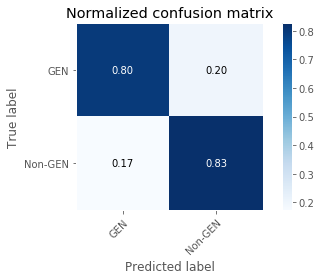

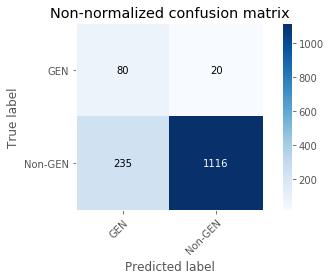

In [20]:
# plot a better visualisation using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    plt.grid(None)
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=["GEN","Non-GEN"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=["GEN","Non-GEN"], normalize=False,
                      title='Non-normalized confusion matrix')

### 2) Balanced Adaboost Classifier

In [21]:
# initialise model

ada=RUSBoostClassifier(random_state=42)

In [22]:
# parameter space for checking by GridSearchCV

param_grid_ada = { 
    'n_estimators': range(100, 4601, 500),
    'learning_rate':[.001,0.01,.1]
}

In [23]:
# search for optimal hyperparameters

CV_ada = GridSearchCV(estimator=ada, param_grid=param_grid_ada, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
CV_ada.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 45.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RUSBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42, replacement=False,
                                          sampling_strategy='auto'),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': range(100, 4601, 500)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=3)

In [24]:
# extract optimal hyperparameters

CV_ada.best_params_

{'learning_rate': 0.1, 'n_estimators': 3100}

In [25]:
# do a finer-grained search for optimal hyperparameters within a narrowed down parameter space derived above

param_grid_ada2 = { 
    'n_estimators': range(2700, 3400, 100),
    'learning_rate':[0.1]
}

In [26]:
# search for optimal hyperparameters

CV_ada2 = GridSearchCV(estimator=ada, param_grid=param_grid_ada2, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
CV_ada2.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed: 13.8min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 14.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RUSBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42, replacement=False,
                                          sampling_strategy='auto'),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1],
                         'n_estimators': range(2700, 3400, 100)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=3)

In [27]:
# extract optimal hyperparameters

CV_ada2.best_params_

{'learning_rate': 0.1, 'n_estimators': 2800}

In [28]:
# model based on best paramters

ada2=RUSBoostClassifier(random_state=42,learning_rate= 0.1, n_estimators= 2800)

In [29]:
# evaluate model's performance

scores = cross_val_score(ada2, x_train, y_train.values.ravel(), cv=5, scoring = 'f1_weighted',n_jobs=-1)
print ("mean validation - F1 Weighted score:", "F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
ada2 = ada2.fit(x_train, y_train.values.ravel())
y_pred_1 = ada2.predict(x_test)
f1 = f1_score(y_test, y_pred_1, average="weighted")
print ('Wighted F1 score on Test set:', f1)

mean validation - F1 Weighted score: F1 score: 0.93 (+/- 0.02)
Wighted F1 score on Test set: 0.926946933149552


In [30]:
print('The geometric mean of Balanced Adaboost classifier on the test set is {}'.format(geometric_mean_score(y_test.values.ravel(),y_pred_1)))

The geometric mean of Balanced Adaboost classifier on the test set is 0.6719834864560126


In [31]:
# visualise results using a simple confusion matrix

unique_label = np.unique(y_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred_1, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:GEN  pred:NON-GEN
true:GEN            47            53
true:NON-GEN        53          1298


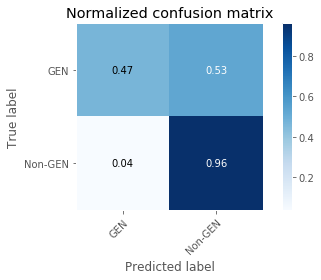

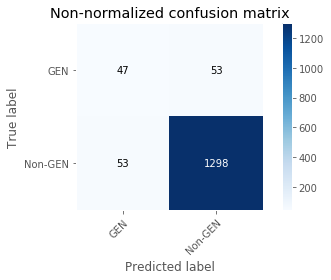

In [32]:
# plot a better visualisation using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_1, classes=["GEN","Non-GEN"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_1, classes=["GEN","Non-GEN"], normalize=False,
                      title='Non-normalized confusion matrix')

## Extract Feature Importance from the Model

In [33]:
# extract feature importance

feature_importance = pd.DataFrame(brf2.feature_importances_,index=df_01_data.columns).reset_index()

In [34]:
feature_importance.head()

,index,0
0,Pop_size,0.006209
1,avg_pop_churn,0.014527
2,age_0_4,0.005302
3,age_5_7,0.005146
4,age_8_9,0.005117


In [35]:
# rename dataframe

feature_importance=feature_importance.rename(columns={"index":"Variable", 0:"var_impt"})

In [36]:
feature_importance.sort_values(by = "var_impt", ascending=False)

,Variable,var_impt
62,Median_HsePrice_EndYr,0.049421
96,NS-SEC_3,0.027523
81,hse_converted_shared,0.024448
117,toWork_home,0.021501
105,Males_FTime_31_48hrs,0.020372
122,toWork_carVan,0.017493
98,NS-SEC_5,0.017281
61,Median_HsePrice_BaseYr,0.015723
87,Administrative_secretarial_occup,0.015697
1,avg_pop_churn,0.014527


In [37]:
# checkpoint - output file

#impt_features = pd.DataFrame(feature_importance.sort_values(by = "var_impt", ascending=False).iloc[0:10,0])
#impt_features.to_csv("impt_features.csv")

In [38]:
# read in file with the variable codes and categories

var_code = pd.read_csv("variable_codes.csv")

In [39]:
var_code.head()

,Variable,Category,Code
0,avg_pop_churn,Pop. Churn,1
1,Pop_size,Pop. & Demographics,2
2,age_0_4,Pop. & Demographics,2
3,age_5_7,Pop. & Demographics,2
4,age_8_9,Pop. & Demographics,2


In [40]:
# merge these datasets

feature_importance = feature_importance.merge(var_code, left_on="Variable", right_on="Variable")

[Text(0, 0.5, 'Importance')]

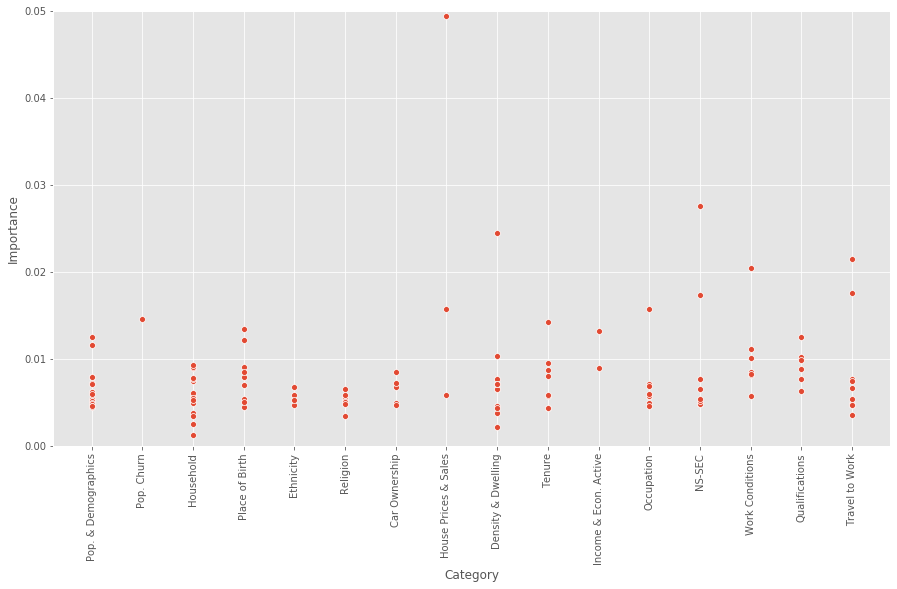

In [41]:
# visualise the most important variables

plt.figure(figsize=(15,8))
plt.ylim(0, 0.05)
plt.xticks(rotation=90)

ax = sns.scatterplot(x="Category", y="var_impt", data=feature_importance)
ax.set(ylabel='Importance')

# uncomment for loop below to annotate the chart
# for line in range(0,feature_importance.shape[0]):
#     ax.text(feature_importance.Category[line], feature_importance.var_impt[line], feature_importance.Variable[line], horizontalalignment='left', size='small', color='black')

## Feature Engineering - Variable Pruning 

In [42]:
# test to establish the optimal quantum of least important variables to be removed

f1_array = []
geo_mean_array=[]
no_to_drop = range(1,65)

for i in range(len(no_to_drop)):
    to_drop = feature_importance.sort_values(by = "var_impt", ascending=False)[-no_to_drop[i]:len(feature_importance)]
    to_drop_list = to_drop.reset_index().iloc[:,1]
    
    df_01_data_dropped = df_01_data[:]
    df_01_data_dropped = df_01_data_dropped.drop(columns=to_drop_list)
    x_train_dropped, x_test_dropped, y_train, y_test = train_test_split(df_01_data_dropped, df_01_labels, stratify=df_01_labels, test_size=0.3, random_state=42)
    brf2 = brf2.fit(x_train_dropped, y_train.values.ravel())
    y_pred = brf2.predict(x_test_dropped)
    f1 = f1_score(y_test, y_pred, average="weighted")
    f1_array.append(f1)
    geo_mean = geometric_mean_score(y_test.values.ravel(),y_pred)
    geo_mean_array.append(geo_mean)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 4 of 600
building tree 3 of 600
building tree 8 of 600
building tree 1 of 600
building tree 7 of 600
building tree 2 of 600
building tree 6 of 600
building tree 5 of 600
building tree 9 of 600
building tree 12 of 600
building tree 10 of 600
building tree 13 of 600
building tree 11 of 600
building tree 15 of 600
building tree 14 of 600building tree 16 of 600

building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 20 of 600

building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600building tree 30 of 600

building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600building tree 36 of 600

building tree 38 of 600building tree 37 of 600

building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 44 of 600
building tree 42 of 600
building tree 46 of 600building tree 43 of 600

building tree 45 of 600
building tree 48 of 600
building tree 47 of 600
building tree 49 of 600
building tree 51 of 600
building tree 50 of 600
building tree 54 of 600
building tree 53 of 600
building tree 52 of 600
building tree 55 of 600
building tree 56 of 600building tree 57 of 600

building tree 59 of 600building tree 58 of 600

building tree 60 of 600building tree 61 of 600

building tree 6

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s



building tree 151 of 600
building tree 152 of 600
building tree 154 of 600building tree 155 of 600

building tree 153 of 600building tree 156 of 600

building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 162 of 600building tree 163 of 600

building tree 161 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 169 of 600
building tree 168 of 600
building tree 170 of 600building tree 172 of 600

building tree 171 of 600
building tree 174 of 600building tree 173 of 600

building tree 175 of 600
building tree 177 of 600building tree 176 of 600

building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600
building tree 186 of 600
building tree 187 of 600
building tree 188 of 600
building tree 189 of 600
building tree 192 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 278 of 600building tree 279 of 600building tree 277 of 600


building tree 280 of 600
building tree 281 of 600
building tree 283 of 600
building tree 282 of 600
building tree 284 of 600
building tree 285 of 600building tree 286 of 600

building tree 288 of 600
building tree 287 of 600building tree 289 of 600

building tree 293 of 600building tree 290 of 600

building tree 294 of 600building tree 292 of 600

building tree 291 of 600
building tree 295 of 600
building tree 297 of 600
building tree 296 of 600
building tree 298 of 600
building tree 299 of 600
building tree 301 of 600building tree 300 of 600

building tree 302 of 600
building tree 304 of 600building tree 303 of 600

building tree 305 of 600building tree 306 of 600

building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 314 of 600
building tree 313 of 600
building tree 315 of 600
building tree 317 of 600b

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 536 of 600building tree 537 of 600building tree 535 of 600


building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600building tree 544 of 600

building tree 545 of 600building tree 547 of 600

building tree 546 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600building tree 554 of 600

building tree 556 of 600
building tree 555 of 600
building tree 557 of 600
building tree 558 of 600
building tree 559 of 600building tree 560 of 600

building tree 561 of 600
building tree 562 of 600
building tree 563 of 600
building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 567 of 600
building tree 568 of 600
building tree 569 of 600
building tree 570 of 600
building tree 571 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 4 of 600
building tree 1 of 600
building tree 5 of 600
building tree 6 of 600building tree 7 of 600

building tree 8 of 600
building tree 3 of 600
building tree 2 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 15 of 600
building tree 13 of 600
building tree 14 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 22 of 600building tree 20 of 600building tree 23 of 600


building tree 21 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600building tree 27 of 600building tree 28 of 600building tree 29 of 600



building tree 30 of 600
building tree 31 of 600building tree 32 of 600

building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600building tree 38 of 600

building tree 37 of 600
building tree 40 of 600building tree 39 of 600

building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 62 of 600
building tree 61 of 600
building tree 63 of 600
building tree 64 of 600
building tree 66 of 600
building tree 65 of 600
building tree 67 of 600
building tree 68 of 600
building tree 69 of 600
building tree 70 of 600
building tree 72 of 600building tree 71 of 600

building tree 73 of 600
building tree 74 of 600
building tree 75 of 600building tree 76 of 600

building tree 77 of 600building tree 78 of 600

building tree 79 of 600
building tree 80 of 600
building tree 82 of 600
building tree 81 of 600
building tree 83 of 600
building tree 84 of 600
building tree 86 of 600building tree 85 of 600

building tree 87 of 600
building tree 88 of 600
building tree 89 of 600
building tree 90 of 600building tree 91 of 600building tree 92 of 600


building tree 94 of 600
building tree 93 of 600
building tree 95 of 600
building tree 96 of 600
building tree 97 of 600
building tree 98 of 600
building tree 100 of 600
building tree 99 of 600
building tree 101 of 600
building tree 

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s


building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600building tree 155 of 600

building tree 157 of 600
building tree 158 of 600
building tree 156 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 163 of 600
building tree 162 of 600
building tree 164 of 600
building tree 165 of 600
building tree 167 of 600
building tree 166 of 600
building tree 168 of 600
building tree 170 of 600building tree 169 of 600

building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600building tree 175 of 600

building tree 177 of 600
building tree 176 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600building tree 184 of 600

building tree 183 of 600
building tree 185 of 600
building tree 187 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 309 of 600

building tree 308 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600building tree 318 of 600

building tree 317 of 600
building tree 316 of 600
building tree 319 of 600
building tree 320 of 600
building tree 323 of 600building tree 321 of 600

building tree 322 of 600
building tree 324 of 600
building tree 325 of 600building tree 326 of 600

building tree 327 of 600
building tree 328 of 600
building tree 331 of 600building tree 329 of 600

building tree 330 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 520 of 600
building tree 522 of 600
building tree 524 of 600building tree 523 of 600

building tree 525 of 600
building tree 528 of 600
building tree 526 of 600
building tree 527 of 600
building tree 529 of 600
building tree 531 of 600
building tree 530 of 600
building tree 532 of 600building tree 533 of 600

building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600building tree 541 of 600

building tree 540 of 600
building tree 545 of 600
building tree 543 of 600building tree 542 of 600

building tree 544 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600building tree 549 of 600

building tree 550 of 600
building tree 551 of 600
building tree 552 of 600building tree 553 of 600
building tree 554 of 600

building tree 555 of 600
building tree 556 of 600
building tree 557 of 600
building tree 558 of 600
building tree 559 of 600
building tree 561 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 4 of 600
building tree 8 of 600building tree 3 of 600
building tree 5 of 600

building tree 6 of 600
building tree 7 of 600
building tree 2 of 600
building tree 1 of 600
building tree 9 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 10 of 600
building tree 16 of 600building tree 15 of 600
building tree 14 of 600

building tree 17 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 19 of 600
building tree 24 of 600building tree 18 of 600building tree 21 of 600


building tree 22 of 600building tree 23 of 600

building tree 20 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600building tree 28 of 600

building tree 30 of 600
building tree 32 of 600
building tree 31 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 41 of 600
building tree 40 of 600
building tree 42 of 600
building tree 43 of 600building tree 44 of 600

building tree 45 of 600
building tree 47 of 600building tree 46 of 600building tree 49 of 600


building tree 48 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 57 of 600
building tree 58 of 600
building tree 55 of 600
building tree 56 of 600
building tree 59

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s


building tree 142 of 600
building tree 145 of 600
building tree 143 of 600
building tree 144 of 600
building tree 147 of 600building tree 146 of 600

building tree 148 of 600
building tree 149 of 600
building tree 151 of 600
building tree 150 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 163 of 600
building tree 160 of 600
building tree 161 of 600
building tree 164 of 600
building tree 162 of 600
building tree 165 of 600building tree 166 of 600

building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 172 of 600building tree 171 of 600

building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 179 of 600building tree 177 of 600

building tree 178 of 600
building tree 180 of 600
building tree 181 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s




building tree 304 of 600
building tree 306 of 600
building tree 305 of 600
building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 311 of 600
building tree 310 of 600
building tree 313 of 600
building tree 312 of 600building tree 314 of 600

building tree 315 of 600
building tree 316 of 600
building tree 319 of 600building tree 318 of 600

building tree 317 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600building tree 324 of 600

building tree 323 of 600
building tree 325 of 600
building tree 327 of 600
building tree 326 of 600
building tree 328 of 600
building tree 329 of 600
building tree 331 of 600
building tree 330 of 600
building tree 332 of 600building tree 333 of 600

building tree 334 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 60

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 505 of 600
building tree 506 of 600
building tree 507 of 600
building tree 508 of 600
building tree 509 of 600
building tree 510 of 600
building tree 512 of 600
building tree 511 of 600
building tree 513 of 600
building tree 514 of 600
building tree 515 of 600
building tree 516 of 600
building tree 517 of 600
building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 521 of 600
building tree 522 of 600
building tree 523 of 600
building tree 524 of 600
building tree 525 of 600
building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 533 of 600building tree 532 of 600

building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 539 of 600
building tree 538 of 600
building tree 540 of 600
building tree 541 of 600
building tree 543 of 600
building tree 542 of 600building tree 544 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 600
building tree 4 of 600
building tree 2 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600building tree 3 of 600

building tree 8 of 600
building tree 9 of 600building tree 12 of 600

building tree 10 of 600
building tree 11 of 600building tree 14 of 600

building tree 13 of 600building tree 15 of 600

building tree 16 of 600
building tree 17 of 600
building tree 20 of 600
building tree 21 of 600
building tree 18 of 600
building tree 19 of 600
building tree 22 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 23 of 600building tree 24 of 600

building tree 25 of 600building tree 26 of 600

building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 32 of 600
building tree 31 of 600
building tree 33 of 600
building tree 35 of 600
building tree 36 of 600building tree 34 of 600

building tree 37 of 600
building tree 39 of 600building tree 38 of 600

building tree 40 of 600
building tree 41 of 600
building tree 43 of 600
building tree 42 of 600building tree 44 of 600

building tree 47 of 600
building tree 46 of 600
building tree 45 of 600
building tree 48 of 600
building tree 49 of 600
building tree 51 of 600
building tree 50 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600
building tree 56 of 600
building tree 57 of 600
building tree 58 of 600
building tree 60 of 600building tree 59 of 600

building tree 61 of 600
building tree 62 of 600
building tree 64 of 600building tree 63 

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 155 of 600
building tree 157 of 600building tree 156 of 600

building tree 158 of 600
building tree 159 of 600
building tree 162 of 600
building tree 161 of 600
building tree 160 of 600
building tree 164 of 600building tree 165 of 600

building tree 163 of 600
building tree 167 of 600
building tree 166 of 600
building tree 169 of 600
building tree 168 of 600
building tree 170 of 600building tree 171 of 600

building tree 172 of 600building tree 173 of 600

building tree 174 of 600
building tree 175 of 600building tree 176 of 600building tree 177 of 600


building tree 178 of 600
building tree 179 of 600building tree 180 of 600

building tree 181 of 600
building tree 182 of 600
building tree 184 of 600
building tree 183 of 600
building tree 186 of 600
building tree 185 of 600
building tree 188 of 600
building tree 187 of 600
building tree 190 of 600
building tree 189 of 600
building tree 191 of 600building tree 192 of 600

building tree 193 of 600
building tree 194 of 600b

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 283 of 600building tree 284 of 600building tree 282 of 600


building tree 285 of 600
building tree 286 of 600
building tree 287 of 600
building tree 288 of 600
building tree 292 of 600
building tree 290 of 600
building tree 289 of 600
building tree 291 of 600
building tree 293 of 600
building tree 294 of 600
building tree 295 of 600
building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 299 of 600
building tree 300 of 600building tree 301 of 600

building tree 302 of 600
building tree 303 of 600
building tree 305 of 600
building tree 304 of 600
building tree 308 of 600building tree 307 of 600

building tree 309 of 600building tree 306 of 600

building tree 310 of 600
building tree 312 of 600
building tree 311 of 600
building tree 313 of 600
building tree 314 of 600
building tree 317 of 600building tree 315 of 600building tree 316 of 600


building tree 318 of 600
building tree 319 of 600
building tree 322 of 600
building tree 320 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s


building tree 522 of 600
building tree 525 of 600
building tree 524 of 600
building tree 526 of 600
building tree 528 of 600
building tree 527 of 600
building tree 529 of 600building tree 530 of 600

building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 537 of 600
building tree 535 of 600
building tree 536 of 600
building tree 538 of 600
building tree 539 of 600building tree 540 of 600

building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600
building tree 549 of 600
building tree 547 of 600building tree 548 of 600

building tree 551 of 600building tree 550 of 600

building tree 552 of 600
building tree 553 of 600
building tree 554 of 600building tree 555 of 600

building tree 556 of 600
building tree 557 of 600
building tree 558 of 600
building tree 559 of 600
building tree 561 of 600building tree 560 of 600

building tree 562 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 8 of 600
building tree 4 of 600
building tree 3 of 600
building tree 1 of 600
building tree 2 of 600
building tree 6 of 600building tree 7 of 600
building tree 5 of 600

building tree 9 of 600
building tree 10 of 600
building tree 12 of 600
building tree 11 of 600
building tree 13 of 600
building tree 16 of 600
building tree 15 of 600building tree 14 of 600

building tree 17 of 600
building tree 19 of 600
building tree 18 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 21 of 600
building tree 20 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600
building tree 28 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600building tree 36 of 600

building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 42 of 600
building tree 41 of 600
building tree 44 of 600
building tree 45 of 600
building tree 43 of 600
building tree 46 of 600
building tree 47 of 600building tree 48 of 600

building tree 49 of 600
building tree 51 of 600
building tree 50 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600
building tree 57 of 600building tree 56 of 600

building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s



building tree 147 of 600
building tree 150 of 600
building tree 148 of 600
building tree 149 of 600building tree 151 of 600

building tree 152 of 600
building tree 153 of 600building tree 154 of 600

building tree 155 of 600
building tree 157 of 600
building tree 156 of 600
building tree 161 of 600
building tree 158 of 600
building tree 159 of 600building tree 160 of 600

building tree 163 of 600
building tree 162 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 172 of 600
building tree 171 of 600
building tree 173 of 600building tree 174 of 600

building tree 176 of 600
building tree 175 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600building tree 182 of 600

building tree 183 of 600
building tree 184 of 600building tree 185 of 600

building tree 186 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 303 of 600
building tree 301 of 600
building tree 304 of 600
building tree 307 of 600
building tree 306 of 600
building tree 305 of 600
building tree 308 of 600
building tree 310 of 600
building tree 309 of 600
building tree 311 of 600
building tree 313 of 600building tree 312 of 600building tree 314 of 600


building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600building tree 323 of 600

building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 329 of 600building tree 328 of 600

building tree 330 of 600
building tree 331 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600building tree 341 of 600

building tree 340 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s


building tree 503 of 600
building tree 504 of 600
building tree 505 of 600
building tree 506 of 600
building tree 507 of 600
building tree 508 of 600
building tree 510 of 600
building tree 509 of 600
building tree 512 of 600
building tree 511 of 600
building tree 513 of 600
building tree 514 of 600building tree 515 of 600

building tree 516 of 600
building tree 517 of 600
building tree 520 of 600
building tree 518 of 600
building tree 519 of 600
building tree 521 of 600
building tree 523 of 600
building tree 522 of 600
building tree 524 of 600
building tree 525 of 600
building tree 527 of 600
building tree 526 of 600
building tree 528 of 600
building tree 530 of 600
building tree 532 of 600building tree 531 of 600

building tree 529 of 600
building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600building tree 537 of 600

building tree 538 of 600
building tree 540 of 600building tree 539 of 600

building tree 541 of 600
building tree 542 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 4 of 600
building tree 1 of 600building tree 3 of 600

building tree 6 of 600building tree 2 of 600
building tree 7 of 600
building tree 8 of 600

building tree 5 of 600
building tree 9 of 600
building tree 12 of 600
building tree 11 of 600
building tree 10 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600building tree 18 of 600

building tree 19 of 600
building tree 22 of 600building tree 21 of 600
building tree 20 of 600

building tree 24 of 600
building tree 23 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600
building tree 28 of 600
building tree 30 of 600
building tree 31 of 600building tree 33 of 600

building tree 32 of 600
building tree 34 of 600
building tree 36 of 600
building tree 35 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 41 of 600
building tree 40 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 63 of 600
building tree 65 of 600
building tree 64 of 600
building tree 66 of 600
building tree 67 of 600
building tree 68 of 600
building tree 69 of 600
building tree 70 of 600
building tree 71 of 600
building tree 73 of 600
building tree 72 of 600
building tree 74 of 600
building tree 76 of 600
building tree 75 of 600
building tree 77 of 600
building tree 78 of 600
building tree 79 of 600
building tree 81 of 600building tree 80 of 600

building tree 82 of 600building tree 83 of 600

building tree 84 of 600
building tree 85 of 600
building tree 86 of 600
building tree 87 of 600building tree 88 of 600

building tree 89 of 600building tree 90 of 600

building tree 91 of 600
building tree 93 of 600
building tree 94 of 600
building tree 92 of 600
building tree 95 of 600
building tree 96 of 600
building tree 97 of 600
building tree 98 of 600
building tree 100 of 600
building tree 99 of 600
building tree 101 of 600
building tree 102 of 600
building tree 103 of 600
building tr

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 149 of 600building tree 150 of 600

building tree 148 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 160 of 600
building tree 159 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 166 of 600
building tree 165 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 171 of 600
building tree 170 of 600
building tree 173 of 600
building tree 172 of 600
building tree 174 of 600
building tree 176 of 600
building tree 177 of 600building tree 175 of 600

building tree 178 of 600
building tree 179 of 600
building tree 181 of 600building tree 180 of 600

building tree 182 of 600
building tree 184 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 312 of 600
building tree 314 of 600
building tree 315 of 600
building tree 317 of 600
building tree 316 of 600
building tree 318 of 600
building tree 320 of 600
building tree 319 of 600
building tree 321 of 600building tree 322 of 600

building tree 324 of 600
building tree 323 of 600
building tree 325 of 600
building tree 327 of 600building tree 326 of 600

building tree 328 of 600
building tree 329 of 600
building tree 331 of 600building tree 330 of 600

building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 345 of 600
building tree 343 of 600
building tree 344 of 600
building tree 347 of 600
building tree 346 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s



building tree 510 of 600
building tree 513 of 600
building tree 514 of 600
building tree 512 of 600
building tree 515 of 600
building tree 516 of 600building tree 517 of 600

building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 522 of 600
building tree 521 of 600
building tree 523 of 600building tree 524 of 600

building tree 526 of 600
building tree 527 of 600building tree 525 of 600

building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 533 of 600
building tree 531 of 600
building tree 532 of 600
building tree 534 of 600
building tree 536 of 600
building tree 535 of 600
building tree 537 of 600
building tree 538 of 600
building tree 540 of 600
building tree 539 of 600
building tree 541 of 600
building tree 542 of 600
building tree 544 of 600
building tree 543 of 600
building tree 545 of 600
building tree 546 of 600
building tree 548 of 600
building tree 547 of 600
building tree 550 of 600building tree 549 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 3 of 600building tree 5 of 600

building tree 6 of 600
building tree 1 of 600
building tree 8 of 600building tree 7 of 600
building tree 4 of 600

building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 14 of 600building tree 15 of 600
building tree 13 of 600

building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 22 of 600
building tree 20 of 600
building tree 21 of 600
building tree 19 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600
building tree 28 of 600
building tree 31 of 600
building tree 30 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600building tree 36 of 600

building tree 37 of 600
building tree 38 of 600
building tree 40 of 600
building tree 39 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s


building tree 146 of 600
building tree 147 of 600
building tree 149 of 600
building tree 150 of 600building tree 148 of 600

building tree 151 of 600
building tree 153 of 600
building tree 152 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 161 of 600
building tree 160 of 600
building tree 162 of 600
building tree 164 of 600
building tree 163 of 600
building tree 165 of 600
building tree 167 of 600
building tree 166 of 600
building tree 169 of 600building tree 168 of 600

building tree 170 of 600
building tree 171 of 600
building tree 173 of 600
building tree 172 of 600
building tree 174 of 600
building tree 175 of 600building tree 177 of 600

building tree 178 of 600
building tree 176 of 600
building tree 179 of 600
building tree 181 of 600
building tree 180 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 186 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 306 of 600
building tree 307 of 600
building tree 308 of 600
building tree 310 of 600building tree 309 of 600

building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 317 of 600
building tree 315 of 600
building tree 316 of 600
building tree 319 of 600building tree 318 of 600

building tree 320 of 600
building tree 321 of 600
building tree 324 of 600
building tree 322 of 600
building tree 323 of 600building tree 325 of 600

building tree 327 of 600
building tree 329 of 600building tree 326 of 600

building tree 328 of 600
building tree 330 of 600
building tree 331 of 600
building tree 332 of 600
building tree 333 of 600building tree 334 of 600building tree 335 of 600


building tree 337 of 600building tree 336 of 600

building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 344 of 600
building tree 343 of 600
building tree 345 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s



building tree 506 of 600building tree 505 of 600

building tree 507 of 600
building tree 509 of 600building tree 511 of 600building tree 510 of 600


building tree 508 of 600
building tree 512 of 600
building tree 514 of 600building tree 513 of 600

building tree 515 of 600
building tree 516 of 600
building tree 517 of 600
building tree 518 of 600
building tree 519 of 600building tree 520 of 600

building tree 522 of 600building tree 521 of 600

building tree 523 of 600
building tree 525 of 600building tree 524 of 600

building tree 526 of 600
building tree 528 of 600
building tree 527 of 600
building tree 530 of 600building tree 531 of 600

building tree 529 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 536 of 600
building tree 535 of 600
building tree 537 of 600
building tree 538 of 600
building tree 540 of 600
building tree 539 of 600
building tree 541 of 600
building tree 542 of 600
building tree 544 of 600
building tree 543 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 1 of 600
building tree 2 of 600
building tree 6 of 600
building tree 5 of 600
building tree 8 of 600
building tree 3 of 600building tree 4 of 600building tree 7 of 600


building tree 10 of 600
building tree 9 of 600
building tree 11 of 600
building tree 13 of 600building tree 15 of 600

building tree 12 of 600
building tree 14 of 600
building tree 16 of 600
building tree 17 of 600
building tree 19 of 600
building tree 18 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 38 of 600
building tree 36 of 600building tree 39 of 600

building tree 37 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 162 of 600
building tree 161 of 600building tree 163 of 600

building tree 165 of 600building tree 164 of 600

building tree 166 of 600
building tree 168 of 600
building tree 167 of 600
building tree 169 of 600
building tree 170 of 600
building tree 172 of 600
building tree 173 of 600building tree 174 of 600building tree 171 of 600


building tree 175 of 600
building tree 177 of 600
building tree 176 of 600building tree 178 of 600

building tree 179 of 600
building tree 181 of 600
building tree 180 of 600
building tree 182 of 600
building tree 183 of 600building tree 184 of 600

building tree 186 of 600
building tree 187 of 600building tree 185 of 600
building tree 188 of 600

building tree 189 of 600
building tree 190 of 600
building tree 192 of 600building tree 191 of 600

building tree 193 of 600
building tree 194 of 600
building tree 195 of 600
building tree 197 of 600
building tree 196 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 314 of 600
building tree 317 of 600
building tree 318 of 600
building tree 320 of 600
building tree 319 of 600
building tree 322 of 600
building tree 321 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 327 of 600
building tree 326 of 600
building tree 328 of 600
building tree 330 of 600building tree 329 of 600

building tree 331 of 600
building tree 332 of 600
building tree 334 of 600
building tree 333 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 341 of 600
building tree 343 of 600building tree 340 of 600
building tree 342 of 600

building tree 345 of 600building tree 344 of 600

building tree 348 of 600
building tree 346 of 600building tree 347 of 600

building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 355 of 600building tree 354 of 600



[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s




building tree 517 of 600
building tree 519 of 600
building tree 520 of 600
building tree 522 of 600
building tree 521 of 600
building tree 523 of 600
building tree 524 of 600
building tree 525 of 600
building tree 526 of 600
building tree 528 of 600
building tree 527 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 533 of 600
building tree 532 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 539 of 600building tree 538 of 600

building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 547 of 600building tree 548 of 600
building tree 546 of 600

building tree 550 of 600
building tree 549 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600building tree 555 of 600

building tree 556 of 600
building tree 557 of 60

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 4 of 600building tree 2 of 600building tree 5 of 600


building tree 7 of 600building tree 6 of 600

building tree 8 of 600building tree 1 of 600

building tree 3 of 600
building tree 9 of 600
building tree 12 of 600building tree 13 of 600

building tree 10 of 600building tree 11 of 600

building tree 15 of 600
building tree 14 of 600
building tree 16 of 600
building tree 18 of 600building tree 17 of 600

building tree 21 of 600
building tree 20 of 600
building tree 19 of 600
building tree 22 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 24 of 600
building tree 23 of 600
building tree 25 of 600
building tree 26 of 600
building tree 28 of 600
building tree 27 of 600
building tree 29 of 600
building tree 30 of 600building tree 31 of 600

building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 37 of 600
building tree 36 of 600
building tree 39 of 600
building tree 38 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 44 of 600
building tree 45 of 600
building tree 43 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600building tree 49 of 600
building tree 50 of 600

building tree 51 of 600
building tree 53 of 600
building tree 54 of 600building tree 52 of 600

building tree 55 of 600
building tree 59 of 600building tree 58 of 600

building tree 56 of 600
building tree 57 of 600
building tree 60 of 600
building tree 61 of 600
building tree 63 of 600
building tree 62 of 600
building tree 6

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s


building tree 148 of 600
building tree 149 of 600
building tree 151 of 600
building tree 150 of 600building tree 152 of 600

building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 169 of 600
building tree 170 of 600
building tree 168 of 600
building tree 173 of 600building tree 171 of 600

building tree 174 of 600
building tree 172 of 600
building tree 175 of 600
building tree 177 of 600building tree 176 of 600

building tree 178 of 600
building tree 179 of 600building tree 180 of 600

building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 186 of 600
building tree 185 of 600
building tree 187 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 311 of 600
building tree 310 of 600
building tree 312 of 600
building tree 315 of 600
building tree 314 of 600
building tree 313 of 600building tree 316 of 600

building tree 317 of 600
building tree 318 of 600
building tree 320 of 600
building tree 319 of 600
building tree 322 of 600
building tree 321 of 600building tree 323 of 600

building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 328 of 600building tree 327 of 600

building tree 329 of 600
building tree 330 of 600
building tree 331 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600building tree 335 of 600

building tree 336 of 600
building tree 337 of 600
building tree 338 of 600building tree 339 of 600

building tree 340 of 600
building tree 341 of 600
building tree 344 of 600
building tree 342 of 600building tree 343 of 600

building tree 345 of 600
building tree 346 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s


building tree 510 of 600
building tree 511 of 600
building tree 512 of 600
building tree 513 of 600
building tree 514 of 600
building tree 515 of 600building tree 516 of 600

building tree 517 of 600
building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 523 of 600
building tree 521 of 600
building tree 524 of 600building tree 522 of 600

building tree 525 of 600
building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 538 of 600
building tree 537 of 600
building tree 539 of 600
building tree 540 of 600
building tree 542 of 600
building tree 543 of 600building tree 541 of 600

building tree 544 of 600building tree 545 of 600

building tree 546 of 600
building tree 548 of 600
building tree 547 of 600
building tree 549 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 2 of 600
building tree 1 of 600
building tree 6 of 600
building tree 4 of 600building tree 5 of 600

building tree 8 of 600
building tree 3 of 600
building tree 7 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600building tree 13 of 600

building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 22 of 600
building tree 23 of 600
building tree 21 of 600building tree 20 of 600

building tree 26 of 600
building tree 24 of 600
building tree 25 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600building tree 30 of 600

building tree 34 of 600
building tree 33 of 600
building tree 32 of 600building tree 31 of 600

building tree 35 of 600
building tree 36 of 600
building tree 38 of 600building tree 37 of 600

building tree 41 of 600
building tree 40 of 600
building tree 42 of 600
building tree 39 of 600
building tree 43 of 600
building tree 44 of 600
building tree 45 of 600
building tree 46 of 600
building tree 49 of 600
building tree 47 of 600
building tree 48 of 600
building tree 50 of 600
building tree 51 of 600
building tree 53 of 600building tree 52 of 600

building tree 54 of 600
building tree 55 of 600
building tree 57 of 600
building tree 58 of 600
building tree 56 of 600
building tree 59 of 600
building tree 61 of 600building tree 60 

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 153 of 600
building tree 154 of 600
building tree 156 of 600building tree 155 of 600

building tree 157 of 600
building tree 158 of 600
building tree 160 of 600
building tree 159 of 600building tree 161 of 600

building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 168 of 600building tree 167 of 600

building tree 166 of 600
building tree 169 of 600building tree 170 of 600

building tree 171 of 600
building tree 172 of 600
building tree 175 of 600
building tree 173 of 600
building tree 174 of 600
building tree 178 of 600
building tree 176 of 600building tree 177 of 600

building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600building tree 187 of 600

building tree 186 of 600
building tree 188 of 600building tree 189 of 600

building tree 190 of 600
building tree 192 of 600
building tree 191 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 319 of 600
building tree 321 of 600
building tree 320 of 600
building tree 318 of 600
building tree 322 of 600
building tree 324 of 600building tree 323 of 600

building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 330 of 600
building tree 332 of 600building tree 331 of 600

building tree 333 of 600
building tree 335 of 600
building tree 334 of 600
building tree 338 of 600building tree 336 of 600

building tree 337 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 600
building tree 344 of 600
building tree 348 of 600
building tree 346 of 600
building tree 347 of 600building tree 345 of 600

building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 355 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 520 of 600
building tree 521 of 600
building tree 522 of 600building tree 523 of 600

building tree 524 of 600
building tree 526 of 600
building tree 525 of 600
building tree 528 of 600
building tree 527 of 600
building tree 529 of 600
building tree 531 of 600building tree 530 of 600

building tree 533 of 600
building tree 532 of 600
building tree 534 of 600
building tree 535 of 600
building tree 537 of 600
building tree 536 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 544 of 600
building tree 543 of 600
building tree 545 of 600building tree 546 of 600

building tree 547 of 600
building tree 549 of 600
building tree 548 of 600
building tree 550 of 600
building tree 551 of 600
building tree 552 of 600
building tree 554 of 600building tree 553 of 600

building tree 556 of 600
building tree 555 of 600building tree 557 of 600

building tree 558 of 600
building tree 559 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 4 of 600building tree 3 of 600building tree 8 of 600building tree 2 of 600building tree 7 of 600


building tree 5 of 600


building tree 1 of 600
building tree 6 of 600
building tree 9 of 600
building tree 11 of 600building tree 10 of 600

building tree 12 of 600
building tree 14 of 600building tree 13 of 600

building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600
building tree 20 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 30 of 600

building tree 28 of 600building tree 31 of 600

building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600building tree 43 of 600

building tree 44 of 600
building tree 45 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600
building tree 56 of 600
building tree 57 of 600building tree 58 of 600

building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 63 of 600
building tree 62 of 600
building tree 64 of 600
building tree 65 of 600
building tree 67 of 600
building tree 66 of 600
building tree 68 of 600building tree 69 of 600

building tree 7

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s



building tree 156 of 600
building tree 157 of 600
building tree 159 of 600
building tree 158 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600building tree 165 of 600

building tree 166 of 600
building tree 167 of 600
building tree 169 of 600
building tree 168 of 600
building tree 170 of 600
building tree 171 of 600building tree 173 of 600

building tree 174 of 600
building tree 175 of 600
building tree 172 of 600
building tree 177 of 600
building tree 176 of 600
building tree 179 of 600
building tree 178 of 600
building tree 181 of 600
building tree 180 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600
building tree 187 of 600building tree 186 of 600

building tree 188 of 600
building tree 189 of 600
building tree 191 of 600
building tree 190 of 600
building tree 193 of 600
building tree 194 of 600
building tree 192 of 600
building tree 195 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 316 of 600building tree 318 of 600
building tree 317 of 600

building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 331 of 600
building tree 330 of 600
building tree 332 of 600
building tree 333 of 600
building tree 336 of 600
building tree 334 of 600building tree 335 of 600

building tree 338 of 600
building tree 337 of 600
building tree 340 of 600building tree 341 of 600
building tree 339 of 600

building tree 342 of 600
building tree 343 of 600
building tree 344 of 600
building tree 347 of 600
building tree 345 of 600
building tree 346 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600building tree 355 of 600

building tree 354 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s


building tree 516 of 600building tree 517 of 600

building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 521 of 600
building tree 523 of 600
building tree 522 of 600
building tree 524 of 600
building tree 525 of 600
building tree 526 of 600
building tree 528 of 600
building tree 527 of 600
building tree 529 of 600building tree 530 of 600

building tree 531 of 600
building tree 533 of 600
building tree 532 of 600
building tree 534 of 600
building tree 536 of 600
building tree 535 of 600
building tree 538 of 600building tree 539 of 600

building tree 537 of 600
building tree 540 of 600
building tree 541 of 600building tree 543 of 600

building tree 542 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600building tree 550 of 600

building tree 551 of 600
building tree 552 of 600
building tree 555 of 600building tree 553 of 600

building tree 554 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 8 of 600building tree 6 of 600building tree 4 of 600
building tree 5 of 600
building tree 3 of 600

building tree 1 of 600

building tree 7 of 600
building tree 2 of 600
building tree 10 of 600
building tree 9 of 600
building tree 11 of 600
building tree 13 of 600
building tree 12 of 600
building tree 14 of 600
building tree 16 of 600
building tree 15 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 23 of 600building tree 22 of 600

building tree 24 of 600
building tree 25 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 30 of 600
building tree 29 of 600
building tree 32 of 600
building tree 33 of 600
building tree 31 of 600
building tree 35 of 600building tree 36 of 600

building tree 34 of 600
building tree 37 of 600
building tree 38 of 600
building tree 40 of 600building tree 41 of 600

building tree 39 of 600
building tree 43 of 600building tree 42 of 600

building tree 44 of 600
building tree 46 of 600
building tree 45 of 600
building tree 47 of 600
building tree 50 of 600
building tree 49 of 600building tree 51 of 600

building tree 48 of 600
building tree 52 of 600
building tree 54 of 600
building tree 53 of 600
building tree 55 of 600
building tree 56 of 600
building tree 58 of 600building tree 57 of 600

building tree 59 of 600
building tree 60 of 600
building tree 63 of 600
building tree 64 of 600building tree 62 of 600

building tree 61 of 600
building tree 65 of 600
building tree 66 of 600
building tree 6

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s



building tree 139 of 600
building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 146 of 600
building tree 145 of 600building tree 147 of 600

building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 154 of 600
building tree 153 of 600
building tree 155 of 600
building tree 157 of 600
building tree 156 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 163 of 600
building tree 164 of 600
building tree 162 of 600
building tree 165 of 600
building tree 167 of 600
building tree 166 of 600
building tree 168 of 600
building tree 170 of 600building tree 169 of 600

building tree 171 of 600building tree 172 of 600

building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 178 of 600
building tree 177 of 600
building tree 179 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.4s



building tree 282 of 600building tree 281 of 600

building tree 280 of 600
building tree 283 of 600
building tree 284 of 600
building tree 285 of 600
building tree 286 of 600
building tree 287 of 600building tree 288 of 600

building tree 289 of 600
building tree 290 of 600
building tree 291 of 600
building tree 293 of 600
building tree 294 of 600
building tree 292 of 600building tree 297 of 600

building tree 295 of 600
building tree 296 of 600
building tree 298 of 600
building tree 300 of 600building tree 299 of 600

building tree 301 of 600
building tree 302 of 600
building tree 303 of 600building tree 304 of 600

building tree 305 of 600
building tree 306 of 600
building tree 308 of 600
building tree 307 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 319 of 600
building tree 317 of 600building tree 318 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.6s


building tree 529 of 600
building tree 531 of 600
building tree 530 of 600building tree 532 of 600

building tree 534 of 600
building tree 535 of 600building tree 533 of 600building tree 536 of 600


building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600building tree 542 of 600

building tree 544 of 600
building tree 545 of 600
building tree 543 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 553 of 600building tree 552 of 600

building tree 554 of 600
building tree 555 of 600
building tree 557 of 600
building tree 558 of 600
building tree 556 of 600
building tree 559 of 600
building tree 561 of 600building tree 560 of 600

building tree 562 of 600
building tree 563 of 600
building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 569 of 600
building tree 567 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 2 of 600
building tree 4 of 600
building tree 5 of 600building tree 3 of 600
building tree 6 of 600building tree 1 of 600


building tree 8 of 600
building tree 7 of 600
building tree 9 of 600
building tree 10 of 600building tree 11 of 600

building tree 12 of 600
building tree 13 of 600
building tree 16 of 600building tree 15 of 600

building tree 14 of 600
building tree 17 of 600
building tree 19 of 600building tree 18 of 600



[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 20 of 600building tree 21 of 600

building tree 22 of 600
building tree 23 of 600building tree 24 of 600

building tree 26 of 600
building tree 25 of 600
building tree 27 of 600
building tree 29 of 600
building tree 28 of 600
building tree 30 of 600
building tree 32 of 600building tree 31 of 600

building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600
building tree 44 of 600
building tree 46 of 600
building tree 48 of 600
building tree 45 of 600
building tree 47 of 600
building tree 49 of 600
building tree 50 of 600
building tree 52 of 600building tree 51 of 600

building tree 54 of 600
building tree 53 of 600
building tree 55 of 600
building tree 56 of 600
building tree 57 of 600
building tree 60 of 600
building tree 58 of 600
building tree 59 of 600
building tree 62

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s



building tree 147 of 600
building tree 149 of 600
building tree 148 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 156 of 600
building tree 155 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600building tree 167 of 600building tree 166 of 600


building tree 168 of 600
building tree 169 of 600
building tree 171 of 600building tree 172 of 600

building tree 170 of 600
building tree 173 of 600building tree 174 of 600

building tree 175 of 600
building tree 176 of 600
building tree 178 of 600
building tree 177 of 600
building tree 179 of 600
building tree 180 of 600
building tree 183 of 600building tree 181 of 600

building tree 182 of 600
building tree 184 of 600
building tree 185 of 600
building tree 187 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 305 of 600
building tree 307 of 600
building tree 308 of 600
building tree 309 of 600building tree 310 of 600

building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 315 of 600building tree 314 of 600

building tree 316 of 600
building tree 318 of 600
building tree 317 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 323 of 600building tree 322 of 600

building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 330 of 600
building tree 329 of 600
building tree 331 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 337 of 600building tree 335 of 600

building tree 336 of 600
building tree 338 of 600
building tree 339 of 600
building tree 341 of 600
building tree 342 of 600
building tree 344 of 600
building tree 340 of 600
building tree 343 of 600building tree 345 of 600



[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s


building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 545 of 600
building tree 544 of 600
building tree 546 of 600
building tree 548 of 600
building tree 547 of 600
building tree 549 of 600
building tree 551 of 600
building tree 550 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600building tree 555 of 600

building tree 556 of 600
building tree 557 of 600
building tree 559 of 600
building tree 558 of 600
building tree 560 of 600
building tree 563 of 600building tree 562 of 600
building tree 561 of 600

building tree 564 of 600
building tree 565 of 600
building tree 567 of 600
building tree 566 of 600
building tree 568 of 600
building tree 569 of 600
building tree 570 of 600
building tree 571 of 600
building tree 572 of 600building tree 573 of 600

building tree 574 of 600
building tree 575 of 600
building tree 576 of 600
building tree 577 of 600building tree 578 of 600

building tree 579 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 2 of 600
building tree 1 of 600
building tree 8 of 600building tree 4 of 600building tree 6 of 600
building tree 7 of 600


building tree 5 of 600
building tree 3 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600building tree 14 of 600

building tree 13 of 600
building tree 16 of 600building tree 15 of 600

building tree 17 of 600
building tree 18 of 600
building tree 20 of 600building tree 19 of 600



[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600building tree 29 of 600

building tree 28 of 600
building tree 30 of 600
building tree 31 of 600building tree 34 of 600

building tree 32 of 600
building tree 33 of 600
building tree 37 of 600
building tree 35 of 600building tree 36 of 600

building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600building tree 44 of 600
building tree 45 of 600

building tree 43 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 51 of 600
building tree 50 of 600
building tree 52 of 600
building tree 53 of 600
building tree 55 of 600
building tree 54 of 600building tree 56 of 600

building tree 57 of 600
building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 64

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s


building tree 147 of 600building tree 145 of 600

building tree 146 of 600
building tree 148 of 600
building tree 151 of 600
building tree 149 of 600
building tree 150 of 600building tree 152 of 600

building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600building tree 162 of 600

building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 167 of 600building tree 166 of 600

building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 172 of 600building tree 171 of 600

building tree 174 of 600
building tree 175 of 600
building tree 173 of 600
building tree 176 of 600
building tree 178 of 600
building tree 177 of 600building tree 179 of 600

building tree 181 of 600
building tree 180 of 600
building tree 182 of 600building tree 183 of 600

building tree 184 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 302 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 307 of 600
building tree 308 of 600
building tree 311 of 600building tree 310 of 600

building tree 309 of 600
building tree 312 of 600
building tree 313 of 600building tree 314 of 600building tree 315 of 600


building tree 317 of 600
building tree 316 of 600
building tree 320 of 600
building tree 318 of 600building tree 319 of 600

building tree 322 of 600
building tree 323 of 600
building tree 321 of 600
building tree 324 of 600
building tree 326 of 600
building tree 325 of 600
building tree 327 of 600building tree 328 of 600

building tree 329 of 600
building tree 331 of 600
building tree 330 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.5s



building tree 534 of 600
building tree 535 of 600
building tree 537 of 600
building tree 536 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 547 of 600
building tree 546 of 600building tree 549 of 600

building tree 548 of 600building tree 550 of 600

building tree 553 of 600building tree 552 of 600

building tree 551 of 600
building tree 554 of 600
building tree 555 of 600
building tree 558 of 600
building tree 556 of 600building tree 557 of 600

building tree 559 of 600
building tree 560 of 600
building tree 561 of 600building tree 562 of 600
building tree 563 of 600

building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 568 of 600building tree 567 of 600

building tree 569 of 600
building tree 571 of 600building tree 570 of 600

building tree 572 of 600
building tree 573 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 1 of 600
building tree 5 of 600
building tree 4 of 600building tree 3 of 600
building tree 8 of 600

building tree 6 of 600
building tree 7 of 600
building tree 2 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 16 of 600building tree 15 of 600

building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 22 of 600
building tree 21 of 600
building tree 24 of 600
building tree 23 of 600
building tree 27 of 600building tree 25 of 600

building tree 26 of 600
building tree 28 of 600
building tree 32 of 600building tree 29 of 600

building tree 30 of 600
building tree 31 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600building tree 39 of 600building tree 38 of 600


building tree 40 of 600
building tree 41 of 600
building tree 42 of 600bu

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 146 of 600building tree 145 of 600

building tree 142 of 600
building tree 144 of 600
building tree 149 of 600building tree 148 of 600

building tree 147 of 600
building tree 151 of 600
building tree 150 of 600
building tree 154 of 600building tree 152 of 600

building tree 153 of 600
building tree 156 of 600
building tree 155 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 164 of 600
building tree 165 of 600building tree 163 of 600

building tree 166 of 600building tree 162 of 600

building tree 168 of 600
building tree 167 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600building tree 174 of 600

building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 300 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 305 of 600building tree 306 of 600

building tree 304 of 600
building tree 309 of 600building tree 307 of 600

building tree 308 of 600
building tree 310 of 600
building tree 311 of 600
building tree 313 of 600
building tree 312 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 326 of 600building tree 325 of 600

building tree 327 of 600
building tree 328 of 600
building tree 329 of 600building tree 332 of 600

building tree 330 of 600building tree 331 of 600

building tree 333 of 600
building tree 335 of 600
building tree 334 of 600
building tree 336 of 600
building tree 339 of 600
building tree 337 of 600
building tree 338 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s


building tree 502 of 600
building tree 504 of 600
building tree 505 of 600
building tree 506 of 600
building tree 508 of 600
building tree 507 of 600
building tree 509 of 600
building tree 510 of 600
building tree 511 of 600building tree 512 of 600

building tree 513 of 600
building tree 514 of 600
building tree 515 of 600
building tree 516 of 600
building tree 517 of 600
building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 523 of 600building tree 521 of 600

building tree 522 of 600
building tree 525 of 600building tree 524 of 600

building tree 526 of 600
building tree 528 of 600
building tree 527 of 600
building tree 529 of 600
building tree 531 of 600
building tree 530 of 600
building tree 533 of 600
building tree 532 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600building tree 540 of 600

building tree 539 of 600
building tree 542 of 600
building tree 543 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 3 of 600
building tree 5 of 600
building tree 1 of 600
building tree 8 of 600
building tree 6 of 600
building tree 7 of 600
building tree 4 of 600
building tree 9 of 600
building tree 10 of 600
building tree 13 of 600
building tree 11 of 600building tree 14 of 600
building tree 15 of 600building tree 12 of 600


building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600building tree 24 of 600building tree 23 of 600


building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600building tree 30 of 600

building tree 28 of 600building tree 32 of 600

building tree 31 of 600
building tree 33 of 600
building tree 34 of 600
building tree 36 of 600
building tree 35 of 600building tree 37 of 600

building tree 38 of 600
building tree 39 of 600
building tree 40 of 600building tree 41 of 600

building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 150 of 600
building tree 152 of 600building tree 151 of 600

building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 170 of 600
building tree 169 of 600
building tree 171 of 600
building tree 172 of 600
building tree 175 of 600
building tree 174 of 600building tree 176 of 600

building tree 173 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 181 of 600
building tree 180 of 600building tree 183 of 600

building tree 185 of 600
building tree 186 of 600building tree 182 of 600building tree 184 of 600


building tree 187 of 600
building tree 189 of 600building tree 188 of 600



[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 314 of 600
building tree 313 of 600
building tree 315 of 600
building tree 318 of 600
building tree 317 of 600
building tree 316 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600building tree 323 of 600
building tree 322 of 600building tree 324 of 600


building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 330 of 600building tree 332 of 600building tree 331 of 600


building tree 333 of 600
building tree 334 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600building tree 339 of 600

building tree 338 of 600
building tree 340 of 600
building tree 341 of 600building tree 342 of 600

building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 347 of 600
building tree 346 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 353 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s


building tree 516 of 600
building tree 518 of 600
building tree 517 of 600
building tree 519 of 600
building tree 520 of 600
building tree 521 of 600
building tree 522 of 600
building tree 523 of 600
building tree 524 of 600
building tree 525 of 600
building tree 527 of 600
building tree 528 of 600building tree 526 of 600

building tree 529 of 600
building tree 532 of 600
building tree 530 of 600
building tree 533 of 600
building tree 531 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 545 of 600
building tree 546 of 600building tree 544 of 600

building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 552 of 600
building tree 551 of 600
building tree 553 of 600
building tree 554 of 600
building tree 555 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 4 of 600
building tree 2 of 600
building tree 8 of 600
building tree 5 of 600building tree 3 of 600
building tree 1 of 600building tree 7 of 600

building tree 6 of 600

building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 13 of 600
building tree 14 of 600
building tree 12 of 600building tree 16 of 600

building tree 15 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600building tree 20 of 600

building tree 24 of 600
building tree 22 of 600
building tree 21 of 600
building tree 23 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600building tree 29 of 600

building tree 31 of 600
building tree 30 of 600
building tree 32 of 600
building tree 34 of 600building tree 33 of 600

building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 40 of 600
building tree 41 of 600
building tree 39 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s


building tree 146 of 600
building tree 147 of 600building tree 148 of 600

building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 156 of 600
building tree 157 of 600
building tree 155 of 600building tree 159 of 600

building tree 158 of 600
building tree 160 of 600
building tree 161 of 600
building tree 163 of 600building tree 162 of 600

building tree 164 of 600
building tree 166 of 600
building tree 165 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600building tree 170 of 600

building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 177 of 600
building tree 175 of 600
building tree 178 of 600building tree 176 of 600

building tree 180 of 600
building tree 179 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 186 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 305 of 600
building tree 307 of 600
building tree 306 of 600
building tree 309 of 600building tree 308 of 600

building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600building tree 317 of 600

building tree 318 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 325 of 600building tree 323 of 600

building tree 324 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 331 of 600building tree 330 of 600

building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 340 of 600
building tree 339 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 600
building tree 344 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s



building tree 505 of 600
building tree 508 of 600building tree 507 of 600

building tree 509 of 600
building tree 511 of 600
building tree 510 of 600
building tree 512 of 600building tree 513 of 600

building tree 514 of 600
building tree 515 of 600
building tree 517 of 600building tree 516 of 600

building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 521 of 600building tree 522 of 600

building tree 523 of 600
building tree 526 of 600building tree 524 of 600

building tree 525 of 600
building tree 527 of 600building tree 528 of 600

building tree 529 of 600
building tree 531 of 600
building tree 530 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 540 of 600
building tree 539 of 600
building tree 541 of 600
building tree 544 of 600
building tree 542 of 600
building tree 543 of 600
building tree 545 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 2 of 600
building tree 1 of 600
building tree 6 of 600
building tree 4 of 600
building tree 5 of 600building tree 7 of 600
building tree 8 of 600
building tree 3 of 600

building tree 9 of 600
building tree 10 of 600building tree 12 of 600

building tree 11 of 600
building tree 14 of 600
building tree 15 of 600building tree 13 of 600

building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 20 of 600building tree 19 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s




building tree 21 of 600
building tree 23 of 600
building tree 22 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 28 of 600
building tree 27 of 600
building tree 30 of 600
building tree 29 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600building tree 40 of 600

building tree 39 of 600
building tree 41 of 600
building tree 42 of 600
building tree 46 of 600building tree 43 of 600

building tree 44 of 600building tree 45 of 600

building tree 47 of 600
building tree 48 of 600
building tree 49 of 600building tree 50 of 600

building tree 51 of 600
building tree 55 of 600
building tree 54 of 600
building tree 56 of 600
building tree 52 of 600building tree 53 of 600

building tree 57 of 600
building tree 58 of 600
building tree 60 of 600
building tree 59 of 600building tree 61 of 600

building tree 

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 146 of 600
building tree 148 of 600
building tree 147 of 600
building tree 150 of 600building tree 149 of 600

building tree 151 of 600
building tree 153 of 600
building tree 152 of 600
building tree 154 of 600
building tree 156 of 600
building tree 155 of 600
building tree 159 of 600
building tree 157 of 600
building tree 158 of 600
building tree 161 of 600
building tree 160 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 168 of 600
building tree 167 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 173 of 600
building tree 172 of 600
building tree 174 of 600
building tree 175 of 600building tree 176 of 600

building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 181 of 600building tree 180 of 600

building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 305 of 600
building tree 308 of 600
building tree 307 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 315 of 600
building tree 314 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 320 of 600
building tree 319 of 600
building tree 321 of 600
building tree 323 of 600
building tree 322 of 600
building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 328 of 600
building tree 327 of 600
building tree 329 of 600
building tree 331 of 600
building tree 330 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600building tree 336 of 600
building tree 337 of 600

building tree 338 of 600
building tree 339 of 600
building tree 340 of 600building tree 341 of 600

building tree 342 of 600
building tree 344 of 600
building tree 343 of 600
building tree 345 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 506 of 600
building tree 510 of 600
building tree 509 of 600
building tree 511 of 600
building tree 512 of 600
building tree 513 of 600
building tree 515 of 600
building tree 514 of 600
building tree 517 of 600
building tree 516 of 600
building tree 518 of 600building tree 519 of 600

building tree 520 of 600
building tree 521 of 600
building tree 524 of 600building tree 523 of 600

building tree 522 of 600
building tree 525 of 600
building tree 526 of 600
building tree 528 of 600
building tree 527 of 600
building tree 530 of 600
building tree 529 of 600
building tree 531 of 600
building tree 532 of 600
building tree 534 of 600
building tree 533 of 600
building tree 535 of 600
building tree 537 of 600building tree 536 of 600

building tree 540 of 600
building tree 538 of 600
building tree 539 of 600
building tree 541 of 600
building tree 543 of 600
building tree 544 of 600building tree 542 of 600

building tree 545 of 600building tree 546 of 600

building tree 547 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 2 of 600
building tree 4 of 600
building tree 8 of 600
building tree 7 of 600
building tree 1 of 600building tree 6 of 600

building tree 3 of 600
building tree 5 of 600
building tree 9 of 600
building tree 10 of 600
building tree 12 of 600building tree 11 of 600

building tree 13 of 600
building tree 14 of 600
building tree 16 of 600
building tree 15 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 20 of 600
building tree 22 of 600building tree 21 of 600

building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600building tree 27 of 600

building tree 29 of 600
building tree 30 of 600
building tree 28 of 600
building tree 32 of 600
building tree 31 of 600
building tree 33 of 600
building tree 34 of 600building tree 35 of 600

building tree 36 of 600
building tree 37 of 600
building tree 39 of 600
building tree 38 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 44 of 600
building tree 43 of 600building tree 48 of 600

building tree 45 of 600
building tree 47 of 600
building tree 46 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 54 of 600
building tree 53 of 600building tree 55 of 600

building tree 56 of 600
building tree 52 of 600
building tree 57 of 600
building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 6

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 151 of 600
building tree 152 of 600
building tree 154 of 600building tree 153 of 600
building tree 155 of 600

building tree 156 of 600
building tree 158 of 600building tree 157 of 600

building tree 159 of 600
building tree 162 of 600building tree 160 of 600building tree 161 of 600


building tree 163 of 600
building tree 165 of 600
building tree 164 of 600
building tree 166 of 600
building tree 168 of 600building tree 167 of 600

building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 179 of 600
building tree 178 of 600
building tree 181 of 600
building tree 180 of 600
building tree 183 of 600
building tree 182 of 600
building tree 184 of 600
building tree 185 of 600
building tree 187 of 600
building tree 188 of 600building tree 186 of 600

building tree 190 of 600
building tree 191 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.4s


building tree 295 of 600
building tree 297 of 600
building tree 299 of 600
building tree 300 of 600
building tree 298 of 600building tree 301 of 600

building tree 302 of 600
building tree 303 of 600building tree 304 of 600

building tree 305 of 600
building tree 306 of 600
building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600building tree 312 of 600

building tree 314 of 600
building tree 313 of 600
building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 319 of 600building tree 318 of 600

building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 328 of 600
building tree 327 of 600
building tree 329 of 600
building tree 330 of 600building tree 331 of 600

building tree 332 of 600
building tree 333 of 600
building tree 335 of 600
building tree 334 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s


building tree 540 of 600
building tree 542 of 600
building tree 544 of 600
building tree 543 of 600
building tree 546 of 600
building tree 545 of 600
building tree 547 of 600
building tree 549 of 600
building tree 548 of 600
building tree 550 of 600
building tree 551 of 600
building tree 552 of 600building tree 553 of 600

building tree 554 of 600
building tree 556 of 600building tree 555 of 600

building tree 558 of 600building tree 557 of 600

building tree 559 of 600
building tree 560 of 600building tree 561 of 600

building tree 562 of 600
building tree 564 of 600building tree 563 of 600

building tree 565 of 600
building tree 566 of 600
building tree 567 of 600
building tree 568 of 600
building tree 569 of 600
building tree 570 of 600
building tree 571 of 600building tree 572 of 600

building tree 573 of 600
building tree 574 of 600
building tree 575 of 600
building tree 576 of 600
building tree 578 of 600
building tree 577 of 600
building tree 579 of 600
building tree 580 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 2 of 600building tree 4 of 600

building tree 6 of 600building tree 8 of 600

building tree 1 of 600
building tree 3 of 600
building tree 5 of 600
building tree 7 of 600
building tree 10 of 600
building tree 9 of 600building tree 11 of 600

building tree 13 of 600
building tree 14 of 600building tree 12 of 600

building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 22 of 600building tree 23 of 600

building tree 24 of 600building tree 25 of 600

building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 32 of 600
building tree 30 of 600building tree 31 of 600

building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 38 of 600
building tree 37 of 600
building tree 36 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 43 of 600
building tree 42 of 600
building tree 46 of 600building tree 44 of 600

building tree 45 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 51 of 600building tree 50 of 600

building tree 53 of 600
building tree 52 of 600building tree 54 of 600

building tree 55 of 600
building tree 56 of 600building tree 58 of 600

building tree 57 of 600
building tree 60 of 600
building tree 61 of 600building tree 59 of 600

building tree 62 of 600
building tree 6

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s



building tree 148 of 600
building tree 150 of 600building tree 151 of 600

building tree 152 of 600
building tree 154 of 600
building tree 153 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 162 of 600
building tree 161 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 168 of 600
building tree 167 of 600building tree 170 of 600

building tree 169 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 180 of 600
building tree 179 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600building tree 185 of 600

building tree 186 of 600
building tree 187 of 600
building tree 189 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 306 of 600building tree 307 of 600

building tree 308 of 600
building tree 309 of 600
building tree 310 of 600building tree 312 of 600

building tree 313 of 600building tree 311 of 600

building tree 315 of 600building tree 314 of 600

building tree 316 of 600
building tree 318 of 600
building tree 320 of 600
building tree 319 of 600
building tree 317 of 600
building tree 321 of 600
building tree 322 of 600
building tree 324 of 600
building tree 323 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 330 of 600
building tree 331 of 600
building tree 332 of 600building tree 333 of 600

building tree 334 of 600
building tree 335 of 600building tree 337 of 600

building tree 336 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 600
building tree 345 of 600
building tree 346 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s



building tree 511 of 600
building tree 512 of 600
building tree 513 of 600
building tree 514 of 600
building tree 515 of 600building tree 517 of 600

building tree 516 of 600
building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 521 of 600
building tree 522 of 600
building tree 523 of 600
building tree 524 of 600
building tree 525 of 600
building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 530 of 600
building tree 529 of 600
building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 536 of 600
building tree 535 of 600
building tree 538 of 600building tree 537 of 600

building tree 539 of 600
building tree 541 of 600
building tree 540 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 551 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 8 of 600building tree 3 of 600building tree 4 of 600


building tree 5 of 600
building tree 7 of 600building tree 1 of 600building tree 2 of 600


building tree 6 of 600
building tree 9 of 600
building tree 12 of 600
building tree 10 of 600
building tree 14 of 600
building tree 11 of 600building tree 13 of 600

building tree 16 of 600
building tree 15 of 600
building tree 17 of 600
building tree 19 of 600
building tree 18 of 600
building tree 20 of 600
building tree 22 of 600
building tree 21 of 600
building tree 23 of 600
building tree 24 of 600building tree 25 of 600

building tree 26 of 600
building tree 27 of 600building tree 29 of 600

building tree 28 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600building tree 35 of 600

building tree 36 of 600
building tree 37 of 600
building tree 38 of 600building tree 39 of 600

building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s


building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 156 of 600
building tree 155 of 600building tree 157 of 600

building tree 159 of 600
building tree 158 of 600
building tree 160 of 600building tree 161 of 600

building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 166 of 600
building tree 165 of 600
building tree 170 of 600building tree 167 of 600building tree 168 of 600


building tree 169 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 180 of 600
building tree 178 of 600
building tree 181 of 600building tree 179 of 600

building tree 182 of 600
building tree 183 of 600
building tree 184 of 600building tree 185 of 600

building tree 186 of 600building tree 187 of 600
building tree 188 of 600

building tree 189 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 316 of 600
building tree 317 of 600
building tree 319 of 600building tree 318 of 600

building tree 320 of 600
building tree 321 of 600
building tree 323 of 600
building tree 322 of 600
building tree 326 of 600building tree 324 of 600

building tree 325 of 600
building tree 327 of 600
building tree 329 of 600
building tree 328 of 600building tree 331 of 600

building tree 330 of 600
building tree 332 of 600building tree 333 of 600

building tree 334 of 600
building tree 335 of 600
building tree 336 of 600building tree 337 of 600

building tree 339 of 600
building tree 338 of 600
building tree 340 of 600
building tree 342 of 600
building tree 341 of 600
building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 346 of 600building tree 347 of 600

building tree 348 of 600
building tree 349 of 600
building tree 350 of 600building tree 351 of 600

building tree 352 of 600
building tree 353 of 600building tree 354 of 600

building tree 355 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 517 of 600
building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 521 of 600
building tree 522 of 600
building tree 523 of 600building tree 524 of 600

building tree 525 of 600
building tree 526 of 600
building tree 527 of 600
building tree 529 of 600building tree 528 of 600

building tree 530 of 600
building tree 532 of 600building tree 531 of 600

building tree 533 of 600
building tree 534 of 600
building tree 536 of 600building tree 535 of 600

building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 546 of 600
building tree 545 of 600
building tree 547 of 600
building tree 548 of 600
building tree 550 of 600building tree 549 of 600

building tree 551 of 600
building tree 552 of 600
building tree 555 of 600
building tree 553 of 600
building tree 554 of 600
building tree 556 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 3 of 600
building tree 2 of 600
building tree 8 of 600
building tree 4 of 600
building tree 5 of 600
building tree 7 of 600building tree 6 of 600
building tree 1 of 600

building tree 9 of 600
building tree 11 of 600building tree 10 of 600building tree 12 of 600

building tree 13 of 600

building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 19 of 600
building tree 18 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 27 of 600
building tree 26 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 32 of 600
building tree 31 of 600
building tree 33 of 600
building tree 34 of 600
building tree 36 of 600
building tree 35 of 600
building tree 39 of 600building tree 37 of 600

building tree 38 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600
building tree 44 of 600
building tree 46 of 600building tree 45 of 600

building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 54 of 600building tree 53 of 600

building tree 55 of 600
building tree 56 of 600
building tree 58 of 600
building tree 57 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 62 of 600
building tree 63 of 600
building tree 6

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 156 of 600
building tree 158 of 600
building tree 159 of 600
building tree 161 of 600
building tree 160 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 167 of 600
building tree 166 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600building tree 177 of 600

building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 183 of 600
building tree 184 of 600
building tree 181 of 600
building tree 182 of 600
building tree 186 of 600building tree 185 of 600

building tree 187 of 600
building tree 188 of 600
building tree 190 of 600
building tree 189 of 600
building tree 193 of 600
building tree 192 of 600
building tree 191 of 600
building tree 194 of 600
building tree 195 of 600
building tree 196 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 317 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 326 of 600
building tree 325 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600building tree 331 of 600

building tree 330 of 600
building tree 332 of 600
building tree 333 of 600
building tree 335 of 600building tree 334 of 600building tree 336 of 600


building tree 338 of 600building tree 337 of 600

building tree 339 of 600
building tree 340 of 600
building tree 341 of 600building tree 343 of 600

building tree 342 of 600
building tree 344 of 600
building tree 346 of 600
building tree 345 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600building tree 351 of 600

building tree 350 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 357 of 600
building tree 356 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 520 of 600
building tree 521 of 600
building tree 522 of 600
building tree 523 of 600
building tree 525 of 600
building tree 524 of 600
building tree 526 of 600
building tree 528 of 600
building tree 529 of 600building tree 527 of 600

building tree 530 of 600
building tree 532 of 600building tree 531 of 600

building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 537 of 600
building tree 536 of 600
building tree 538 of 600building tree 539 of 600

building tree 540 of 600
building tree 541 of 600
building tree 543 of 600
building tree 542 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 553 of 600
building tree 552 of 600
building tree 554 of 600building tree 555 of 600

building tree 556 of 600building tree 557 of 600

building tree 558 of 600building tree 559 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 2 of 600
building tree 1 of 600
building tree 5 of 600
building tree 6 of 600
building tree 4 of 600building tree 3 of 600

building tree 8 of 600building tree 7 of 600

building tree 9 of 600
building tree 10 of 600
building tree 12 of 600building tree 11 of 600

building tree 14 of 600
building tree 16 of 600building tree 13 of 600

building tree 15 of 600
building tree 17 of 600
building tree 19 of 600
building tree 18 of 600
building tree 20 of 600
building tree 24 of 600building tree 22 of 600

building tree 21 of 600
building tree 23 of 600
building tree 25 of 600
building tree 26 of 600
building tree 28 of 600
building tree 27 of 600
building tree 29 of 600
building tree 31 of 600
building tree 30 of 600
building tree 32 of 600
building tree 34 of 600building tree 33 of 600

building tree 35 of 600
building tree 38 of 600
building tree 37 of 600building tree 36 of 600

building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 157 of 600
building tree 160 of 600
building tree 159 of 600
building tree 161 of 600
building tree 164 of 600building tree 162 of 600

building tree 163 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 170 of 600
building tree 169 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 175 of 600
building tree 174 of 600
building tree 176 of 600
building tree 178 of 600
building tree 177 of 600building tree 181 of 600building tree 180 of 600


building tree 179 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600
building tree 186 of 600
building tree 187 of 600
building tree 188 of 600
building tree 189 of 600
building tree 190 of 600
building tree 192 of 600building tree 191 of 600

building tree 193 of 600
building tree 194 of 600
building tree 196 of 600
building tree 195 of 600building tree 197 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 323 of 600
building tree 324 of 600
building tree 326 of 600
building tree 325 of 600
building tree 327 of 600
building tree 329 of 600
building tree 328 of 600
building tree 330 of 600
building tree 331 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 600
building tree 345 of 600building tree 344 of 600

building tree 347 of 600
building tree 346 of 600
building tree 348 of 600
building tree 349 of 600
building tree 351 of 600
building tree 350 of 600
building tree 354 of 600
building tree 352 of 600building tree 355 of 600

building tree 353 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 361 of 600
building tree 360 of 600
building tree 362 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 524 of 600
building tree 523 of 600building tree 526 of 600

building tree 525 of 600building tree 527 of 600

building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 533 of 600
building tree 531 of 600building tree 532 of 600

building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 542 of 600
building tree 540 of 600building tree 539 of 600

building tree 541 of 600
building tree 543 of 600
building tree 545 of 600
building tree 544 of 600
building tree 546 of 600
building tree 548 of 600
building tree 549 of 600
building tree 547 of 600
building tree 550 of 600
building tree 552 of 600
building tree 551 of 600building tree 554 of 600

building tree 553 of 600
building tree 555 of 600
building tree 557 of 600
building tree 556 of 600
building tree 559 of 600
building tree 558 of 600
building tree 560 of 600
building tree 561 of 600
building tree 562 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 6 of 600building tree 2 of 600

building tree 3 of 600
building tree 5 of 600
building tree 8 of 600building tree 4 of 600

building tree 1 of 600
building tree 7 of 600
building tree 9 of 600
building tree 10 of 600
building tree 12 of 600building tree 11 of 600

building tree 14 of 600
building tree 13 of 600
building tree 16 of 600
building tree 15 of 600
building tree 17 of 600
building tree 18 of 600
building tree 20 of 600
building tree 19 of 600
building tree 22 of 600
building tree 21 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 23 of 600
building tree 24 of 600
building tree 26 of 600
building tree 27 of 600
building tree 25 of 600
building tree 29 of 600building tree 28 of 600
building tree 31 of 600

building tree 30 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600building tree 35 of 600

building tree 37 of 600
building tree 36 of 600
building tree 39 of 600
building tree 38 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600
building tree 44 of 600
building tree 45 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 54 of 600building tree 53 of 600building tree 52 of 600


building tree 56 of 600
building tree 57 of 600
building tree 55 of 600
building tree 58 of 600
building tree 59 of 600building tree 60 of 600

building tree 61 of 600
building tree 62 of 600
building tree 64 of 600
building tree 63

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 151 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600building tree 152 of 600

building tree 156 of 600
building tree 158 of 600
building tree 157 of 600
building tree 160 of 600
building tree 161 of 600building tree 159 of 600

building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 170 of 600
building tree 169 of 600
building tree 172 of 600building tree 171 of 600

building tree 173 of 600
building tree 175 of 600building tree 174 of 600

building tree 176 of 600
building tree 177 of 600
building tree 178 of 600building tree 179 of 600

building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600building tree 184 of 600

building tree 185 of 600
building tree 187 of 600building tree 186 of 600

building tree 189 of 600
building tree 188 of 600
building tree 190 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 318 of 600
building tree 317 of 600
building tree 320 of 600
building tree 319 of 600
building tree 321 of 600
building tree 322 of 600
building tree 324 of 600
building tree 323 of 600building tree 325 of 600

building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 330 of 600building tree 329 of 600

building tree 333 of 600building tree 331 of 600

building tree 332 of 600
building tree 334 of 600
building tree 335 of 600
building tree 337 of 600
building tree 336 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600building tree 341 of 600

building tree 342 of 600
building tree 344 of 600
building tree 343 of 600
building tree 345 of 600
building tree 347 of 600
building tree 346 of 600building tree 349 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.5s



building tree 518 of 600
building tree 517 of 600
building tree 520 of 600
building tree 519 of 600
building tree 522 of 600
building tree 523 of 600
building tree 521 of 600
building tree 524 of 600
building tree 525 of 600
building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600building tree 532 of 600

building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 538 of 600
building tree 537 of 600
building tree 542 of 600
building tree 539 of 600building tree 540 of 600

building tree 541 of 600
building tree 544 of 600
building tree 543 of 600
building tree 545 of 600
building tree 546 of 600
building tree 547 of 600building tree 548 of 600

building tree 549 of 600
building tree 551 of 600
building tree 550 of 600
building tree 552 of 600
building tree 554 of 600building tree 555 of 600building tree 556 of 600


building tree 553 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 600
building tree 2 of 600
building tree 4 of 600
building tree 7 of 600building tree 8 of 600
building tree 3 of 600

building tree 6 of 600
building tree 5 of 600
building tree 9 of 600
building tree 10 of 600
building tree 13 of 600
building tree 12 of 600
building tree 15 of 600building tree 11 of 600building tree 14 of 600


building tree 16 of 600
building tree 18 of 600
building tree 20 of 600building tree 17 of 600

building tree 19 of 600
building tree 22 of 600
building tree 21 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 30 of 600building tree 29 of 600

building tree 31 of 600
building tree 32 of 600
building tree 35 of 600
building tree 34 of 600
building tree 33 of 600
building tree 37 of 600
building tree 36 of 600
building tree 39 of 600
building tree 38 of 600
building tree 40 of 600
building tree 42 of 600
building tree 41 of 600
building tree 43 of 600building tree 45 of 600

building tree 44 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 55 of 600building tree 54 of 600building tree 53 of 600

building tree 52 of 600

building tree 56 of 600
building tree 57 of 600
building tree 58 of 600
building tree 60 of 600building tree 62 of 600

building tree 61 of 600building tree 59 of 600

building tree 63 of 600
building tree 65

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 148 of 600
building tree 149 of 600
building tree 151 of 600building tree 150 of 600

building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 158 of 600
building tree 157 of 600
building tree 159 of 600
building tree 160 of 600
building tree 162 of 600
building tree 161 of 600
building tree 165 of 600building tree 163 of 600

building tree 164 of 600
building tree 167 of 600
building tree 166 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 176 of 600
building tree 175 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600building tree 186 of 600

building tree 188 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 303 of 600
building tree 305 of 600
building tree 304 of 600
building tree 306 of 600
building tree 307 of 600
building tree 309 of 600building tree 308 of 600

building tree 310 of 600building tree 311 of 600building tree 312 of 600


building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 318 of 600
building tree 317 of 600building tree 319 of 600

building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 325 of 600
building tree 324 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 330 of 600
building tree 332 of 600
building tree 331 of 600
building tree 334 of 600
building tree 333 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600building tree 342 of 600bu

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 515 of 600building tree 516 of 600

building tree 517 of 600
building tree 519 of 600
building tree 518 of 600
building tree 521 of 600
building tree 520 of 600
building tree 522 of 600
building tree 523 of 600
building tree 525 of 600building tree 524 of 600

building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 536 of 600building tree 535 of 600

building tree 538 of 600
building tree 537 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600building tree 543 of 600

building tree 545 of 600
building tree 544 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600building tree 550 of 600

building tree 551 of 600
building tree 554 of 600
building tree 552 of 600
building tree 553 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 1 of 600
building tree 3 of 600
building tree 5 of 600
building tree 6 of 600building tree 8 of 600

building tree 4 of 600
building tree 7 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 13 of 600building tree 14 of 600

building tree 15 of 600building tree 12 of 600

building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600building tree 23 of 600
building tree 22 of 600

building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 31 of 600
building tree 30 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 42 of 600building tree 43 of 600bui

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 162 of 600
building tree 161 of 600
building tree 164 of 600
building tree 163 of 600
building tree 165 of 600
building tree 166 of 600
building tree 168 of 600
building tree 167 of 600
building tree 169 of 600
building tree 171 of 600
building tree 172 of 600building tree 170 of 600

building tree 174 of 600building tree 173 of 600

building tree 175 of 600
building tree 176 of 600
building tree 177 of 600building tree 178 of 600

building tree 179 of 600
building tree 181 of 600building tree 180 of 600
building tree 182 of 600

building tree 183 of 600
building tree 185 of 600
building tree 186 of 600
building tree 184 of 600
building tree 187 of 600
building tree 188 of 600building tree 189 of 600

building tree 190 of 600
building tree 191 of 600
building tree 193 of 600
building tree 192 of 600
building tree 195 of 600building tree 194 of 600

building tree 196 of 600
building tree 198 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s


building tree 279 of 600building tree 280 of 600

building tree 281 of 600
building tree 284 of 600building tree 283 of 600

building tree 282 of 600
building tree 285 of 600
building tree 286 of 600
building tree 288 of 600building tree 287 of 600

building tree 290 of 600building tree 292 of 600building tree 289 of 600


building tree 291 of 600
building tree 293 of 600
building tree 295 of 600building tree 294 of 600

building tree 296 of 600
building tree 297 of 600
building tree 299 of 600
building tree 298 of 600
building tree 300 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 304 of 600
building tree 305 of 600
building tree 307 of 600building tree 308 of 600
building tree 306 of 600

building tree 309 of 600
building tree 311 of 600
building tree 310 of 600
building tree 313 of 600
building tree 312 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 318 of 600
building tree 319 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 516 of 600
building tree 514 of 600building tree 515 of 600

building tree 517 of 600
building tree 519 of 600
building tree 518 of 600building tree 520 of 600

building tree 521 of 600building tree 522 of 600

building tree 523 of 600building tree 524 of 600

building tree 525 of 600
building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 534 of 600
building tree 533 of 600building tree 532 of 600

building tree 535 of 600
building tree 537 of 600
building tree 538 of 600
building tree 536 of 600
building tree 540 of 600
building tree 539 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600building tree 547 of 600

building tree 548 of 600building tree 549 of 600

building tree 551 of 600
building tree 550 of 600
building tree 552 of 600building tree 554 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 4 of 600building tree 1 of 600

building tree 6 of 600
building tree 8 of 600
building tree 5 of 600building tree 3 of 600building tree 7 of 600


building tree 2 of 600
building tree 9 of 600
building tree 10 of 600
building tree 12 of 600
building tree 11 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600building tree 22 of 600
building tree 20 of 600

building tree 21 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 23 of 600
building tree 24 of 600building tree 26 of 600

building tree 25 of 600
building tree 27 of 600building tree 28 of 600

building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600building tree 36 of 600

building tree 37 of 600
building tree 38 of 600building tree 39 of 600

building tree 40 of 600
building tree 41 of 600
building tree 43 of 600
building tree 42 of 600
building tree 44 of 600building tree 45 of 600

building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600building tree 52 of 600

building tree 53 of 600
building tree 51 of 600
building tree 54 of 600
building tree 55 of 600
building tree 56 of 600
building tree 58 of 600
building tree 57 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600building tree 62 of 600

building tree 63 of 600
building tree 64

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s



building tree 127 of 600
building tree 132 of 600
building tree 131 of 600
building tree 133 of 600
building tree 134 of 600
building tree 135 of 600
building tree 136 of 600
building tree 137 of 600
building tree 138 of 600
building tree 139 of 600
building tree 142 of 600
building tree 141 of 600
building tree 140 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 149 of 600building tree 147 of 600

building tree 148 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600building tree 157 of 600

building tree 158 of 600
building tree 156 of 600
building tree 159 of 600
building tree 160 of 600building tree 161 of 600

building tree 162 of 600
building tree 164 of 600
building tree 163 of 600
building tree 165 of 600
building tree 167 of 600building tree 166 of 600

building tree 168 of 600
building tree 169 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.5s



building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 307 of 600
building tree 311 of 600
building tree 309 of 600
building tree 310 of 600
building tree 308 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600building tree 325 of 600

building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 330 of 600
building tree 331 of 600
building tree 332 of 600building tree 334 of 600

building tree 335 of 600
building tree 333 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 340 of 600building tree 341 of 600

building tree 339 of 600
building tree 342 of 600
building tree 344 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.6s


building tree 542 of 600
building tree 541 of 600building tree 539 of 600

building tree 543 of 600
building tree 544 of 600
building tree 546 of 600
building tree 548 of 600building tree 545 of 600

building tree 547 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 553 of 600
building tree 552 of 600building tree 554 of 600

building tree 555 of 600
building tree 556 of 600
building tree 557 of 600
building tree 559 of 600
building tree 558 of 600
building tree 560 of 600
building tree 563 of 600building tree 561 of 600
building tree 562 of 600

building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 567 of 600building tree 570 of 600
building tree 568 of 600

building tree 569 of 600building tree 571 of 600

building tree 572 of 600
building tree 573 of 600
building tree 574 of 600
building tree 575 of 600
building tree 576 of 600
building tree 577 of 600
building tree 580 of 600building tree 578 of 600bu

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 6 of 600
building tree 2 of 600building tree 8 of 600

building tree 5 of 600building tree 4 of 600

building tree 1 of 600
building tree 7 of 600
building tree 3 of 600
building tree 9 of 600
building tree 10 of 600
building tree 13 of 600
building tree 12 of 600
building tree 11 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 18 of 600
building tree 17 of 600
building tree 19 of 600building tree 22 of 600

building tree 21 of 600building tree 20 of 600

building tree 23 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600
building tree 28 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 35 of 600
building tree 34 of 600
building tree 36 of 600
building tree 37 of 600building tree 39 of 600

building tree 38 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600building tree 43 of 600

building tree 44 of 600building tree 45 of 600

building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 52 of 600
building tree 51 of 600
building tree 54 of 600
building tree 53 of 600
building tree 55 of 600
building tree 56 of 600
building tree 58 of 600
building tree 57 of 600
building tree 59 of 600
building tree 60 of 600
building tree 62 of 600
building tree 61 of 600
building tree 64 of 600
building tree 63 of 600
building tree 65

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 155 of 600building tree 156 of 600

building tree 157 of 600
building tree 159 of 600
building tree 158 of 600
building tree 161 of 600
building tree 160 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 166 of 600
building tree 165 of 600
building tree 167 of 600
building tree 169 of 600
building tree 168 of 600
building tree 171 of 600
building tree 170 of 600
building tree 173 of 600building tree 172 of 600

building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 178 of 600
building tree 177 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600building tree 182 of 600

building tree 183 of 600
building tree 184 of 600
building tree 187 of 600
building tree 186 of 600
building tree 185 of 600
building tree 188 of 600
building tree 191 of 600
building tree 189 of 600
building tree 190 of 600
building tree 192 of 600
building tree 193 of 600
building tree 194 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.4s



building tree 298 of 600
building tree 297 of 600
building tree 296 of 600
building tree 299 of 600
building tree 301 of 600
building tree 300 of 600
building tree 302 of 600
building tree 303 of 600
building tree 304 of 600
building tree 306 of 600
building tree 305 of 600
building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 313 of 600building tree 314 of 600

building tree 312 of 600
building tree 315 of 600
building tree 316 of 600building tree 317 of 600

building tree 318 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 331 of 600
building tree 332 of 600
building tree 330 of 600
building tree 334 of 600
building tree 333 of 600
building tree 336 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.5s


building tree 516 of 600
building tree 515 of 600
building tree 517 of 600
building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 522 of 600
building tree 524 of 600
building tree 521 of 600building tree 523 of 600

building tree 525 of 600
building tree 527 of 600
building tree 526 of 600
building tree 528 of 600
building tree 530 of 600
building tree 529 of 600
building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 543 of 600
building tree 542 of 600
building tree 544 of 600
building tree 546 of 600building tree 547 of 600
building tree 545 of 600

building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600building tree 552 of 600

building tree 554 of 600
building tree 553 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 3 of 600
building tree 6 of 600
building tree 5 of 600
building tree 4 of 600
building tree 2 of 600
building tree 8 of 600building tree 1 of 600building tree 7 of 600


building tree 9 of 600
building tree 11 of 600building tree 12 of 600
building tree 10 of 600

building tree 14 of 600building tree 13 of 600

building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 20 of 600
building tree 19 of 600
building tree 21 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 22 of 600
building tree 25 of 600
building tree 24 of 600
building tree 23 of 600
building tree 27 of 600
building tree 26 of 600building tree 28 of 600

building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 35 of 600
building tree 34 of 600building tree 36 of 600

building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600building tree 41 of 600

building tree 42 of 600
building tree 44 of 600
building tree 43 of 600
building tree 45 of 600building tree 46 of 600

building tree 47 of 600
building tree 48 of 600
building tree 50 of 600
building tree 49 of 600
building tree 52 of 600
building tree 51 of 600building tree 53 of 600

building tree 54 of 600
building tree 55 of 600
building tree 57 of 600building tree 56 of 600

building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 62 of 600
building tree 64

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s




building tree 151 of 600
building tree 153 of 600
building tree 155 of 600building tree 152 of 600

building tree 154 of 600
building tree 156 of 600
building tree 159 of 600
building tree 157 of 600building tree 158 of 600

building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 169 of 600
building tree 168 of 600
building tree 170 of 600
building tree 171 of 600building tree 172 of 600

building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 178 of 600
building tree 177 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 183 of 600building tree 182 of 600

building tree 184 of 600building tree 185 of 600

building tree 186 of 600
building tree 187 of 600
building tree 188 of 600
building tree 190 of 600
building tree 191 of 60

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 312 of 600
building tree 313 of 600building tree 316 of 600

building tree 314 of 600
building tree 317 of 600building tree 315 of 600

building tree 318 of 600
building tree 320 of 600
building tree 321 of 600
building tree 319 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 326 of 600building tree 327 of 600

building tree 328 of 600
building tree 330 of 600
building tree 332 of 600building tree 331 of 600

building tree 329 of 600
building tree 334 of 600
building tree 335 of 600
building tree 333 of 600
building tree 336 of 600
building tree 338 of 600
building tree 339 of 600
building tree 337 of 600
building tree 342 of 600building tree 340 of 600

building tree 341 of 600
building tree 343 of 600
building tree 345 of 600building tree 344 of 600

building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 510 of 600building tree 511 of 600

building tree 513 of 600
building tree 512 of 600
building tree 515 of 600
building tree 514 of 600
building tree 517 of 600
building tree 516 of 600
building tree 520 of 600
building tree 519 of 600
building tree 518 of 600
building tree 521 of 600
building tree 522 of 600
building tree 523 of 600
building tree 524 of 600
building tree 525 of 600
building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 533 of 600building tree 531 of 600
building tree 532 of 600

building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 538 of 600
building tree 537 of 600
building tree 540 of 600
building tree 539 of 600
building tree 541 of 600
building tree 542 of 600
building tree 544 of 600
building tree 543 of 600
building tree 545 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 551 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 1 of 600building tree 5 of 600

building tree 7 of 600
building tree 3 of 600
building tree 8 of 600building tree 6 of 600

building tree 4 of 600
building tree 9 of 600
building tree 10 of 600building tree 11 of 600

building tree 14 of 600building tree 15 of 600

building tree 13 of 600building tree 12 of 600

building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 22 of 600
building tree 21 of 600
building tree 24 of 600
building tree 23 of 600
building tree 25 of 600
building tree 27 of 600
building tree 26 of 600
building tree 28 of 600
building tree 29 of 600
building tree 31 of 600
building tree 30 of 600
building tree 32 of 600
building tree 34 of 600
building tree 33 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 40 of 600
building tree 39 of 600
building tree 38 of 600
building tree 42 of 600
building tree 41 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 159 of 600
building tree 158 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 166 of 600building tree 164 of 600

building tree 165 of 600
building tree 167 of 600building tree 170 of 600

building tree 168 of 600building tree 169 of 600

building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600building tree 176 of 600

building tree 178 of 600
building tree 177 of 600
building tree 175 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 184 of 600
building tree 183 of 600
building tree 187 of 600
building tree 185 of 600building tree 186 of 600

building tree 188 of 600
building tree 191 of 600building tree 189 of 600

building tree 192 of 600building tree 190 of 600

building tree 194 of 600building tree 195 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 317 of 600
building tree 318 of 600
building tree 319 of 600
building tree 321 of 600
building tree 320 of 600
building tree 323 of 600
building tree 322 of 600
building tree 324 of 600
building tree 326 of 600building tree 325 of 600

building tree 327 of 600
building tree 329 of 600
building tree 328 of 600
building tree 330 of 600
building tree 331 of 600
building tree 333 of 600
building tree 332 of 600
building tree 334 of 600
building tree 335 of 600
building tree 337 of 600
building tree 338 of 600
building tree 336 of 600
building tree 340 of 600
building tree 339 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 600
building tree 345 of 600building tree 344 of 600

building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 352 of 600
building tree 351 of 600
building tree 354 of 600
building tree 353 of 600
building tree 355 of 600
building tree 356 of 600b

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 521 of 600
building tree 522 of 600building tree 524 of 600

building tree 523 of 600
building tree 526 of 600
building tree 525 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 532 of 600building tree 534 of 600
building tree 533 of 600

building tree 536 of 600
building tree 535 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 543 of 600building tree 542 of 600
building tree 544 of 600

building tree 545 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 552 of 600
building tree 551 of 600
building tree 553 of 600
building tree 554 of 600
building tree 555 of 600
building tree 556 of 600
building tree 557 of 600
building tree 559 of 600
building tree 558 of 600
building tree 560 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 3 of 600
building tree 2 of 600
building tree 7 of 600
building tree 1 of 600
building tree 8 of 600
building tree 6 of 600
building tree 5 of 600
building tree 4 of 600
building tree 9 of 600
building tree 10 of 600building tree 12 of 600

building tree 13 of 600
building tree 11 of 600
building tree 15 of 600building tree 14 of 600

building tree 16 of 600
building tree 17 of 600
building tree 19 of 600building tree 18 of 600

building tree 20 of 600
building tree 21 of 600
building tree 22 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 27 of 600building tree 26 of 600

building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 35 of 600
building tree 36 of 600
building tree 34 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600building tree 42 of 600

building tree 43 of 600
building tree 45 of 600
building tree 44 of 600
building tree 46 of 600
building tree 48 of 600
building tree 47 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 56 of 600
building tree 55 of 600
building tree 58 of 600building tree 57 of 600

building tree 59 of 600
building tree 60 of 600
building tree 61 of 600building tree 62 of 600

building tree 63 of 600
building tree 65

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 148 of 600building tree 147 of 600

building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 155 of 600
building tree 154 of 600building tree 156 of 600

building tree 157 of 600
building tree 158 of 600building tree 159 of 600

building tree 161 of 600building tree 160 of 600

building tree 163 of 600
building tree 162 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600building tree 172 of 600

building tree 171 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600building tree 177 of 600building tree 178 of 600


building tree 180 of 600
building tree 179 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 185 of 600building tree 184 of 600

building tree 186 of 600b

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s




building tree 306 of 600
building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 316 of 600
building tree 317 of 600
building tree 315 of 600
building tree 319 of 600
building tree 318 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 325 of 600
building tree 323 of 600building tree 324 of 600

building tree 326 of 600building tree 327 of 600

building tree 328 of 600
building tree 329 of 600
building tree 330 of 600
building tree 331 of 600
building tree 333 of 600
building tree 332 of 600
building tree 334 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 342 of 600building tree 341 of 600

building tree 344 of 600
building tree 346 of 600building tree 343 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 516 of 600
building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 522 of 600
building tree 521 of 600
building tree 523 of 600
building tree 524 of 600
building tree 525 of 600
building tree 526 of 600
building tree 527 of 600
building tree 529 of 600
building tree 528 of 600
building tree 531 of 600building tree 530 of 600

building tree 532 of 600
building tree 533 of 600
building tree 535 of 600
building tree 534 of 600
building tree 536 of 600
building tree 537 of 600
building tree 539 of 600
building tree 538 of 600building tree 540 of 600building tree 541 of 600


building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 546 of 600
building tree 545 of 600
building tree 549 of 600
building tree 547 of 600building tree 548 of 600

building tree 550 of 600
building tree 551 of 600building tree 553 of 600

building tree 554 of 600building tree 552 of 600

building tree 556 of 600
building tree 555 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 2 of 600
building tree 6 of 600building tree 1 of 600

building tree 5 of 600
building tree 3 of 600
building tree 8 of 600
building tree 4 of 600
building tree 7 of 600
building tree 9 of 600
building tree 12 of 600
building tree 10 of 600building tree 11 of 600

building tree 14 of 600building tree 13 of 600

building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 20 of 600
building tree 18 of 600
building tree 21 of 600
building tree 22 of 600
building tree 19 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 27 of 600building tree 26 of 600

building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 34 of 600
building tree 33 of 600
building tree 35 of 600building tree 36 of 600

building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600building tree 42 of 600

building tree 41 of 600
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 69 of 600
building tree 71 of 600
building tree 72 of 600
building tree 70 of 600
building tree 73 of 600
building tree 74 of 600
building tree 75 of 600
building tree 76 of 600
building tree 77 of 600
building tree 78 of 600
building tree 81 of 600
building tree 79 of 600
building tree 80 of 600building tree 83 of 600

building tree 82 of 600
building tree 85 of 600
building tree 84 of 600
building tree 86 of 600building tree 88 of 600

building tree 89 of 600building tree 87 of 600

building tree 90 of 600
building tree 91 of 600
building tree 92 of 600
building tree 93 of 600
building tree 94 of 600
building tree 95 of 600
building tree 96 of 600
building tree 98 of 600
building tree 97 of 600
building tree 100 of 600
building tree 99 of 600
building tree 101 of 600
building tree 102 of 600
building tree 104 of 600
building tree 103 of 600
building tree 105 of 600
building tree 106 of 600
building tree 107 of 600
building tree 109 of 600
building tree 108 of 600
build

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 154 of 600building tree 156 of 600

building tree 155 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 164 of 600
building tree 165 of 600
building tree 163 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600building tree 169 of 600

building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 176 of 600building tree 175 of 600

building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600building tree 181 of 600

building tree 182 of 600
building tree 184 of 600
building tree 185 of 600
building tree 183 of 600
building tree 186 of 600
building tree 187 of 600
building tree 189 of 600
building tree 188 of 600
building tree 190 of 600
building tree 191 of 600
building tree 192 of 600
building tree 193 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600building tree 329 of 600

building tree 331 of 600
building tree 330 of 600building tree 328 of 600

building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 337 of 600
building tree 335 of 600
building tree 338 of 600
building tree 336 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 347 of 600building tree 346 of 600

building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 353 of 600building tree 356 of 600

building tree 352 of 600
building tree 354 of 600building tree 355 of 600

building tree 358 of 600building tree 357 of 600

building tree 359 of 600
building tree 360 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 528 of 600
building tree 531 of 600
building tree 529 of 600
building tree 530 of 600building tree 532 of 600

building tree 533 of 600
building tree 534 of 600building tree 536 of 600

building tree 535 of 600
building tree 537 of 600
building tree 539 of 600
building tree 538 of 600
building tree 541 of 600
building tree 540 of 600
building tree 542 of 600
building tree 545 of 600
building tree 546 of 600building tree 544 of 600

building tree 543 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 553 of 600
building tree 552 of 600
building tree 554 of 600
building tree 558 of 600building tree 555 of 600building tree 557 of 600


building tree 556 of 600
building tree 559 of 600
building tree 560 of 600
building tree 561 of 600
building tree 564 of 600
building tree 562 of 600building tree 563 of 600

building tree 565 of 600
building tree 566 of 600
building tree 568 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 600
building tree 3 of 600
building tree 6 of 600building tree 5 of 600
building tree 4 of 600
building tree 7 of 600

building tree 2 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 16 of 600
building tree 15 of 600
building tree 14 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 20 of 600
building tree 21 of 600
building tree 23 of 600
building tree 24 of 600
building tree 22 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600
building tree 28 of 600
building tree 30 of 600
building tree 32 of 600
building tree 33 of 600building tree 31 of 600

building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 41 of 600
building tree 39 of 600
building tree 40 of 600
building tree 42 of 600building tree 43 of 600

building tree 44 of 600building tree 46 of 600

building tree 45 of 600
building tree 48 of 600
building tree 47 of 600
building tree 50 of 600
building tree 49 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600
building tree 57 of 600building tree 56 of 600

building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 157 of 600
building tree 156 of 600
building tree 158 of 600
building tree 159 of 600
building tree 161 of 600building tree 160 of 600

building tree 162 of 600
building tree 164 of 600building tree 163 of 600

building tree 165 of 600
building tree 166 of 600
building tree 168 of 600building tree 167 of 600

building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 178 of 600
building tree 177 of 600
building tree 180 of 600
building tree 179 of 600
building tree 181 of 600
building tree 182 of 600building tree 183 of 600

building tree 184 of 600
building tree 187 of 600building tree 185 of 600

building tree 186 of 600
building tree 188 of 600
building tree 189 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.4s



building tree 292 of 600
building tree 293 of 600
building tree 294 of 600
building tree 295 of 600
building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 299 of 600
building tree 300 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 304 of 600
building tree 305 of 600building tree 306 of 600

building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 315 of 600building tree 314 of 600

building tree 316 of 600
building tree 317 of 600building tree 318 of 600

building tree 319 of 600
building tree 321 of 600building tree 322 of 600building tree 320 of 600


building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 327 of 600
building tree 326 of 600building tree 328 of 600

building tree 330 of 600
building tree 329 of 600building tree 331 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.5s




building tree 544 of 600
building tree 542 of 600
building tree 546 of 600
building tree 548 of 600
building tree 545 of 600
building tree 547 of 600
building tree 550 of 600
building tree 549 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600
building tree 556 of 600
building tree 555 of 600
building tree 557 of 600
building tree 558 of 600building tree 559 of 600

building tree 560 of 600
building tree 561 of 600
building tree 562 of 600
building tree 563 of 600
building tree 564 of 600
building tree 565 of 600building tree 566 of 600

building tree 567 of 600
building tree 568 of 600
building tree 570 of 600
building tree 569 of 600
building tree 571 of 600
building tree 572 of 600
building tree 574 of 600building tree 573 of 600

building tree 575 of 600building tree 576 of 600

building tree 577 of 600
building tree 578 of 600
building tree 579 of 600
building tree 580 of 600
building tree 581 of 600
building tree 582 of 60

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 6 of 600building tree 1 of 600building tree 2 of 600


building tree 4 of 600
building tree 3 of 600
building tree 7 of 600
building tree 5 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 14 of 600
building tree 15 of 600
building tree 12 of 600
building tree 11 of 600
building tree 13 of 600
building tree 16 of 600
building tree 17 of 600
building tree 19 of 600
building tree 18 of 600
building tree 20 of 600
building tree 22 of 600
building tree 23 of 600
building tree 21 of 600
building tree 24 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 25 of 600building tree 26 of 600

building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 35 of 600
building tree 34 of 600
building tree 37 of 600building tree 36 of 600

building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600building tree 44 of 600

building tree 45 of 600
building tree 47 of 600
building tree 48 of 600building tree 46 of 600

building tree 50 of 600
building tree 49 of 600
building tree 51 of 600
building tree 53 of 600
building tree 52 of 600
building tree 54 of 600
building tree 57 of 600building tree 56 of 600
building tree 55 of 600

building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 62 of 600
building tree 63 of 600
building tree 64 of 600
building tree 65 of 600
building tree 6

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 157 of 600

building tree 156 of 600
building tree 158 of 600
building tree 159 of 600building tree 160 of 600

building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 167 of 600
building tree 166 of 600
building tree 170 of 600
building tree 168 of 600building tree 169 of 600

building tree 171 of 600
building tree 173 of 600
building tree 174 of 600building tree 172 of 600

building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600building tree 179 of 600

building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 186 of 600building tree 185 of 600

building tree 184 of 600
building tree 188 of 600
building tree 190 of 600building tree 187 of 600

building tree 189 of 600
building tree 191 of 600
building tree 192 of 600
building tree 193 of 600
building tree 195 of 600
building tree 194 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 283 of 600
building tree 282 of 600
building tree 284 of 600
building tree 286 of 600
building tree 287 of 600
building tree 285 of 600
building tree 288 of 600
building tree 289 of 600
building tree 290 of 600
building tree 291 of 600
building tree 292 of 600
building tree 295 of 600
building tree 293 of 600
building tree 294 of 600
building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 300 of 600
building tree 299 of 600
building tree 303 of 600building tree 301 of 600

building tree 302 of 600
building tree 305 of 600building tree 304 of 600

building tree 306 of 600
building tree 307 of 600
building tree 310 of 600building tree 309 of 600

building tree 308 of 600
building tree 314 of 600building tree 311 of 600

building tree 312 of 600
building tree 313 of 600
building tree 315 of 600building tree 318 of 600

building tree 316 of 600
building tree 317 of 600
building tree 319 of 600
building tree 320 of 600building tree 321 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 544 of 600
building tree 543 of 600
building tree 547 of 600building tree 545 of 600

building tree 546 of 600
building tree 548 of 600
building tree 549 of 600building tree 551 of 600

building tree 550 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600
building tree 556 of 600
building tree 555 of 600
building tree 557 of 600
building tree 560 of 600
building tree 558 of 600
building tree 559 of 600
building tree 561 of 600
building tree 562 of 600
building tree 563 of 600
building tree 564 of 600
building tree 566 of 600
building tree 565 of 600
building tree 567 of 600
building tree 568 of 600
building tree 569 of 600
building tree 571 of 600
building tree 570 of 600
building tree 574 of 600
building tree 573 of 600
building tree 572 of 600
building tree 575 of 600
building tree 576 of 600
building tree 577 of 600
building tree 580 of 600building tree 578 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 3 of 600
building tree 8 of 600
building tree 2 of 600building tree 4 of 600

building tree 1 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 9 of 600
building tree 10 of 600
building tree 12 of 600building tree 13 of 600

building tree 11 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600
building tree 20 of 600
building tree 22 of 600building tree 24 of 600

building tree 23 of 600
building tree 27 of 600
building tree 25 of 600
building tree 26 of 600
building tree 28 of 600
building tree 29 of 600
building tree 32 of 600
building tree 31 of 600
building tree 30 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 39 of 600
building tree 40 of 600building tree 38 of 600

building tree 41 of 600
building tree 43 of 600bu

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 116 of 600
building tree 118 of 600
building tree 115 of 600
building tree 117 of 600
building tree 119 of 600
building tree 120 of 600
building tree 122 of 600building tree 121 of 600

building tree 124 of 600
building tree 123 of 600
building tree 125 of 600
building tree 126 of 600
building tree 127 of 600
building tree 129 of 600building tree 128 of 600

building tree 130 of 600
building tree 131 of 600
building tree 133 of 600
building tree 132 of 600
building tree 136 of 600
building tree 137 of 600
building tree 134 of 600building tree 135 of 600

building tree 138 of 600
building tree 139 of 600
building tree 140 of 600
building tree 144 of 600
building tree 143 of 600building tree 142 of 600

building tree 145 of 600
building tree 141 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 151 of 600
building tree 152 of 600
building tree 150 of 600
building tree 153 of 600building tree 154 of 600



[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 281 of 600
building tree 280 of 600
building tree 282 of 600building tree 284 of 600

building tree 285 of 600
building tree 283 of 600
building tree 286 of 600
building tree 288 of 600
building tree 287 of 600
building tree 290 of 600
building tree 291 of 600building tree 289 of 600

building tree 293 of 600
building tree 292 of 600
building tree 295 of 600
building tree 294 of 600
building tree 296 of 600
building tree 297 of 600
building tree 299 of 600
building tree 298 of 600
building tree 300 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 308 of 600
building tree 307 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 319 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 526 of 600
building tree 528 of 600
building tree 527 of 600
building tree 530 of 600building tree 529 of 600building tree 531 of 600


building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 536 of 600
building tree 535 of 600
building tree 537 of 600
building tree 539 of 600
building tree 538 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600
building tree 547 of 600
building tree 549 of 600
building tree 548 of 600
building tree 550 of 600building tree 551 of 600

building tree 552 of 600
building tree 553 of 600
building tree 554 of 600
building tree 555 of 600
building tree 557 of 600
building tree 558 of 600
building tree 556 of 600
building tree 559 of 600
building tree 560 of 600
building tree 561 of 600
building tree 562 of 600
building tree 563 of 600
building tree 564 of 600
building tree 565 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 6 of 600
building tree 3 of 600
building tree 7 of 600building tree 8 of 600
building tree 4 of 600
building tree 1 of 600building tree 5 of 600


building tree 9 of 600
building tree 10 of 600
building tree 12 of 600
building tree 11 of 600building tree 14 of 600

building tree 13 of 600building tree 15 of 600

building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 20 of 600building tree 19 of 600

building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 34 of 600
building tree 33 of 600
building tree 35 of 600
building tree 37 of 600
building tree 36 of 600
building tree 39 of 600
building tree 40 of 600
building tree 38 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 158 of 600
building tree 159 of 600
building tree 160 of 600building tree 161 of 600

building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 169 of 600
building tree 168 of 600
building tree 170 of 600
building tree 167 of 600
building tree 173 of 600building tree 171 of 600

building tree 172 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 188 of 600building tree 186 of 600

building tree 187 of 600
building tree 185 of 600
building tree 190 of 600building tree 189 of 600

building tree 191 of 600
building tree 192 of 600
building tree 193 of 600
building tree 194 of 600
building tree 197 of 600building tree 196 of 600

building tree 198 of 600b

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 283 of 600
building tree 282 of 600
building tree 284 of 600
building tree 285 of 600
building tree 287 of 600
building tree 286 of 600
building tree 288 of 600
building tree 290 of 600
building tree 289 of 600
building tree 291 of 600building tree 292 of 600

building tree 293 of 600
building tree 296 of 600building tree 294 of 600

building tree 295 of 600
building tree 297 of 600
building tree 298 of 600
building tree 300 of 600
building tree 299 of 600
building tree 301 of 600
building tree 303 of 600
building tree 302 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 307 of 600
building tree 309 of 600building tree 310 of 600

building tree 308 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 546 of 600
building tree 545 of 600
building tree 547 of 600
building tree 548 of 600
building tree 550 of 600
building tree 549 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600
building tree 556 of 600
building tree 558 of 600building tree 555 of 600

building tree 557 of 600
building tree 559 of 600
building tree 560 of 600
building tree 561 of 600
building tree 562 of 600
building tree 563 of 600
building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 568 of 600
building tree 567 of 600
building tree 569 of 600
building tree 570 of 600
building tree 572 of 600building tree 571 of 600

building tree 573 of 600
building tree 574 of 600
building tree 575 of 600
building tree 576 of 600
building tree 577 of 600
building tree 578 of 600
building tree 579 of 600
building tree 580 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 3 of 600
building tree 7 of 600
building tree 1 of 600building tree 6 of 600
building tree 8 of 600
building tree 5 of 600

building tree 2 of 600
building tree 4 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600building tree 14 of 600

building tree 15 of 600building tree 13 of 600

building tree 16 of 600building tree 12 of 600

building tree 17 of 600
building tree 19 of 600
building tree 18 of 600
building tree 20 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 23 of 600
building tree 21 of 600building tree 22 of 600

building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600building tree 28 of 600

building tree 30 of 600building tree 31 of 600

building tree 32 of 600
building tree 33 of 600building tree 34 of 600

building tree 35 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600building tree 36 of 600

building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600building tree 44 of 600

building tree 46 of 600building tree 45 of 600

building tree 47 of 600building tree 48 of 600

building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 56 of 600building tree 55 of 600

building tree 58 of 600
building tree 57 of 600
building tree 59 of 600
building tree 60 of 600
building tree 62 of 600
building tree 6

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 162 of 600
building tree 161 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600building tree 167 of 600

building tree 168 of 600
building tree 170 of 600
building tree 169 of 600
building tree 171 of 600
building tree 172 of 600
building tree 174 of 600building tree 173 of 600

building tree 175 of 600building tree 176 of 600

building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600building tree 182 of 600

building tree 183 of 600
building tree 184 of 600
building tree 185 of 600
building tree 186 of 600building tree 187 of 600

building tree 188 of 600
building tree 189 of 600
building tree 190 of 600
building tree 192 of 600
building tree 191 of 600
building tree 193 of 600
building tree 194 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 315 of 600building tree 313 of 600

building tree 316 of 600
building tree 317 of 600
building tree 319 of 600
building tree 318 of 600
building tree 322 of 600
building tree 321 of 600
building tree 320 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600building tree 326 of 600

building tree 327 of 600
building tree 328 of 600building tree 330 of 600

building tree 329 of 600
building tree 331 of 600
building tree 332 of 600
building tree 334 of 600building tree 333 of 600
building tree 335 of 600

building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 341 of 600building tree 342 of 600

building tree 339 of 600
building tree 340 of 600
building tree 343 of 600
building tree 344 of 600building tree 345 of 600

building tree 346 of 600
building tree 347 of 600building tree 350 of 600

building tree 348 of 600
building tree 349 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 518 of 600building tree 519 of 600

building tree 520 of 600building tree 521 of 600

building tree 522 of 600
building tree 523 of 600
building tree 526 of 600
building tree 525 of 600building tree 524 of 600
building tree 527 of 600

building tree 528 of 600
building tree 529 of 600building tree 530 of 600

building tree 532 of 600building tree 533 of 600
building tree 531 of 600

building tree 535 of 600
building tree 534 of 600
building tree 536 of 600building tree 537 of 600

building tree 538 of 600
building tree 539 of 600
building tree 541 of 600
building tree 542 of 600
building tree 540 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600
building tree 548 of 600building tree 547 of 600

building tree 549 of 600
building tree 550 of 600
building tree 552 of 600
building tree 551 of 600
building tree 553 of 600
building tree 555 of 600
building tree 554 of 600
building tree 556 of 600
building tree 557 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 1 of 600
building tree 5 of 600
building tree 3 of 600
building tree 6 of 600
building tree 4 of 600building tree 7 of 600

building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 14 of 600
building tree 12 of 600
building tree 13 of 600building tree 15 of 600

building tree 16 of 600
building tree 17 of 600
building tree 18 of 600building tree 20 of 600

building tree 19 of 600
building tree 23 of 600building tree 22 of 600
building tree 21 of 600

building tree 24 of 600
building tree 26 of 600
building tree 25 of 600building tree 28 of 600

building tree 27 of 600
building tree 29 of 600
building tree 31 of 600
building tree 30 of 600
building tree 32 of 600
building tree 33 of 600
building tree 36 of 600
building tree 37 of 600
building tree 35 of 600
building tree 34 of 600
building tree 38 of 600
building tree 39 of 600
building tree 42 of 600building tree 40 of 600

building tree 41 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 155 of 600
building tree 154 of 600
building tree 156 of 600building tree 157 of 600

building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 162 of 600building tree 161 of 600

building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 169 of 600
building tree 168 of 600
building tree 171 of 600
building tree 170 of 600
building tree 172 of 600
building tree 173 of 600
building tree 175 of 600
building tree 174 of 600
building tree 176 of 600
building tree 177 of 600
building tree 180 of 600building tree 178 of 600

building tree 179 of 600building tree 181 of 600

building tree 183 of 600building tree 182 of 600

building tree 184 of 600
building tree 185 of 600
building tree 186 of 600
building tree 187 of 600
building tree 188 of 600
building tree 190 of 600
building tree 189 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 318 of 600
building tree 320 of 600
building tree 319 of 600
building tree 321 of 600
building tree 322 of 600building tree 324 of 600

building tree 323 of 600
building tree 326 of 600
building tree 325 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 330 of 600
building tree 331 of 600
building tree 333 of 600
building tree 334 of 600building tree 332 of 600

building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 339 of 600
building tree 338 of 600
building tree 340 of 600
building tree 342 of 600
building tree 343 of 600building tree 344 of 600

building tree 341 of 600
building tree 345 of 600
building tree 346 of 600
building tree 348 of 600
building tree 347 of 600
building tree 349 of 600
building tree 350 of 600
building tree 352 of 600
building tree 351 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 546 of 600building tree 545 of 600

building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 551 of 600
building tree 550 of 600
building tree 552 of 600
building tree 554 of 600
building tree 553 of 600
building tree 555 of 600
building tree 556 of 600
building tree 558 of 600
building tree 557 of 600
building tree 559 of 600building tree 560 of 600

building tree 561 of 600building tree 562 of 600

building tree 563 of 600
building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 567 of 600
building tree 570 of 600building tree 568 of 600

building tree 569 of 600
building tree 571 of 600
building tree 574 of 600building tree 573 of 600

building tree 575 of 600
building tree 572 of 600
building tree 577 of 600
building tree 576 of 600
building tree 578 of 600
building tree 579 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 4 of 600
building tree 2 of 600building tree 3 of 600

building tree 6 of 600
building tree 5 of 600building tree 1 of 600

building tree 8 of 600
building tree 7 of 600
building tree 10 of 600
building tree 9 of 600
building tree 12 of 600
building tree 11 of 600
building tree 13 of 600building tree 15 of 600
building tree 16 of 600

building tree 14 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 23 of 600
building tree 24 of 600
building tree 22 of 600
building tree 26 of 600
building tree 27 of 600
building tree 25 of 600
building tree 29 of 600building tree 28 of 600

building tree 32 of 600building tree 30 of 600

building tree 31 of 600
building tree 34 of 600
building tree 33 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600building tree 39 of 600

building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 160 of 600
building tree 161 of 600
building tree 159 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600building tree 166 of 600

building tree 169 of 600building tree 167 of 600

building tree 168 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 174 of 600
building tree 173 of 600
building tree 175 of 600
building tree 176 of 600
building tree 178 of 600building tree 177 of 600

building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600
building tree 188 of 600
building tree 186 of 600
building tree 189 of 600building tree 187 of 600

building tree 191 of 600
building tree 190 of 600
building tree 192 of 600
building tree 194 of 600
building tree 193 of 600
building tree 195 of 600
building tree 196 of 600
building tree 197 of 600
building tree 200 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s




building tree 279 of 600
building tree 280 of 600
building tree 282 of 600
building tree 281 of 600
building tree 284 of 600
building tree 283 of 600building tree 286 of 600

building tree 288 of 600building tree 285 of 600

building tree 287 of 600
building tree 289 of 600
building tree 290 of 600
building tree 292 of 600building tree 291 of 600

building tree 294 of 600
building tree 295 of 600building tree 293 of 600

building tree 296 of 600
building tree 298 of 600building tree 297 of 600

building tree 299 of 600
building tree 300 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 304 of 600building tree 305 of 600

building tree 306 of 600
building tree 307 of 600
building tree 309 of 600
building tree 308 of 600
building tree 310 of 600
building tree 312 of 600building tree 311 of 600

building tree 313 of 600
building tree 314 of 600
building tree 316 of 600building tree 315 of 600

building tree 317 of 600building tree 318 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 524 of 600
building tree 525 of 600
building tree 527 of 600
building tree 526 of 600
building tree 528 of 600
building tree 529 of 600
building tree 531 of 600building tree 530 of 600

building tree 532 of 600
building tree 534 of 600
building tree 533 of 600
building tree 535 of 600building tree 536 of 600

building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 541 of 600
building tree 540 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 546 of 600
building tree 547 of 600building tree 545 of 600

building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 554 of 600
building tree 553 of 600building tree 552 of 600

building tree 555 of 600building tree 556 of 600

building tree 557 of 600
building tree 558 of 600
building tree 559 of 600
building tree 560 of 600
building tree 561 of 600
building tree 562 of 600
building tree 563 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 5 of 600
building tree 3 of 600
building tree 1 of 600building tree 4 of 600

building tree 8 of 600
building tree 7 of 600
building tree 6 of 600
building tree 9 of 600
building tree 10 of 600building tree 11 of 600building tree 13 of 600


building tree 12 of 600building tree 14 of 600

building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 19 of 600building tree 18 of 600

building tree 20 of 600building tree 21 of 600

building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 27 of 600
building tree 29 of 600building tree 28 of 600

building tree 26 of 600
building tree 31 of 600building tree 30 of 600

building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 36 of 600building tree 35 of 600

building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 41 of 600
building tree 40 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 150 of 600
building tree 151 of 600
building tree 154 of 600
building tree 153 of 600building tree 152 of 600

building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 163 of 600building tree 161 of 600building tree 164 of 600


building tree 162 of 600
building tree 165 of 600
building tree 166 of 600building tree 168 of 600
building tree 167 of 600

building tree 170 of 600
building tree 169 of 600
building tree 171 of 600
building tree 172 of 600
building tree 174 of 600
building tree 173 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600building tree 178 of 600
building tree 179 of 600

building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 186 of 600
building tree 185 of 600building tree 188 of 600

building tree 187 of 600building tree 190 of 600



[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 281 of 600
building tree 282 of 600
building tree 285 of 600
building tree 284 of 600
building tree 287 of 600
building tree 283 of 600
building tree 286 of 600
building tree 288 of 600
building tree 289 of 600
building tree 290 of 600
building tree 291 of 600building tree 292 of 600

building tree 293 of 600
building tree 295 of 600building tree 294 of 600

building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 299 of 600
building tree 300 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 305 of 600
building tree 306 of 600building tree 304 of 600

building tree 307 of 600
building tree 309 of 600
building tree 310 of 600
building tree 308 of 600
building tree 311 of 600building tree 312 of 600

building tree 313 of 600
building tree 314 of 600
building tree 316 of 600
building tree 315 of 600building tree 317 of 600

building tree 318 of 600
building tree 319 of 600
building tree 320 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.2s


building tree 537 of 600
building tree 538 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 544 of 600
building tree 545 of 600building tree 543 of 600

building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 552 of 600building tree 550 of 600

building tree 551 of 600
building tree 553 of 600building tree 554 of 600

building tree 555 of 600
building tree 556 of 600building tree 557 of 600

building tree 558 of 600
building tree 559 of 600
building tree 560 of 600
building tree 561 of 600
building tree 563 of 600building tree 562 of 600

building tree 565 of 600
building tree 564 of 600
building tree 566 of 600
building tree 568 of 600building tree 567 of 600

building tree 569 of 600
building tree 570 of 600
building tree 571 of 600
building tree 572 of 600
building tree 573 of 600
building tree 576 of 600building tree 574 of 600

building tree 575 of 600
building tree 578 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 8 of 600
building tree 4 of 600building tree 7 of 600building tree 2 of 600

building tree 3 of 600building tree 5 of 600
building tree 6 of 600

building tree 1 of 600

building tree 9 of 600building tree 10 of 600

building tree 11 of 600
building tree 12 of 600
building tree 14 of 600building tree 13 of 600
building tree 15 of 600

building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 22 of 600
building tree 23 of 600
building tree 21 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 28 of 600
building tree 27 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 36 of 600building tree 35 of 600

building tree 39 of 600
building tree 37 of 600
building tree 38 of 600
building tree 40 of 600building tree 41 of 600

building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 147 of 600
building tree 148 of 600
building tree 150 of 600
building tree 149 of 600
building tree 151 of 600building tree 153 of 600

building tree 152 of 600
building tree 155 of 600building tree 154 of 600

building tree 156 of 600
building tree 157 of 600
building tree 159 of 600
building tree 158 of 600
building tree 161 of 600
building tree 160 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600building tree 165 of 600

building tree 166 of 600
building tree 168 of 600
building tree 167 of 600
building tree 169 of 600
building tree 170 of 600
building tree 172 of 600
building tree 171 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 180 of 600
building tree 182 of 600building tree 179 of 600

building tree 181 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600
building tree 187 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 315 of 600building tree 317 of 600

building tree 316 of 600
building tree 318 of 600
building tree 320 of 600
building tree 321 of 600
building tree 319 of 600
building tree 322 of 600
building tree 324 of 600
building tree 323 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600building tree 330 of 600

building tree 331 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 336 of 600
building tree 335 of 600
building tree 339 of 600building tree 338 of 600
building tree 337 of 600

building tree 341 of 600
building tree 340 of 600
building tree 342 of 600
building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 346 of 600building tree 347 of 600

building tree 348 of 600
building tree 349 of 600
building tree 351 of 600building tree 350 of 600

building tree 352 of 600
building tree 353 of 600
building tree 355 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 526 of 600

building tree 528 of 600
building tree 527 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 533 of 600
building tree 532 of 600building tree 534 of 600

building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 539 of 600
building tree 538 of 600
building tree 540 of 600
building tree 542 of 600
building tree 541 of 600
building tree 543 of 600
building tree 545 of 600
building tree 544 of 600
building tree 547 of 600building tree 546 of 600

building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600building tree 554 of 600

building tree 555 of 600building tree 556 of 600

building tree 557 of 600
building tree 558 of 600
building tree 559 of 600
building tree 560 of 600
building tree 563 of 600building tree 561 of 600building tree 562 of 600


building tree 564 of 600
building tree 566 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 3 of 600
building tree 1 of 600
building tree 7 of 600
building tree 2 of 600
building tree 5 of 600building tree 4 of 600

building tree 8 of 600
building tree 6 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600building tree 13 of 600

building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 20 of 600building tree 18 of 600building tree 19 of 600


building tree 21 of 600
building tree 22 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 24 of 600
building tree 23 of 600
building tree 25 of 600
building tree 26 of 600
building tree 28 of 600
building tree 27 of 600
building tree 30 of 600building tree 29 of 600

building tree 31 of 600building tree 32 of 600

building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 37 of 600building tree 36 of 600

building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600
building tree 44 of 600
building tree 46 of 600building tree 45 of 600

building tree 47 of 600
building tree 48 of 600building tree 49 of 600

building tree 50 of 600
building tree 52 of 600building tree 53 of 600

building tree 51 of 600
building tree 54 of 600
building tree 57 of 600
building tree 56 of 600
building tree 55 of 600
building tree 58 of 600
building tree 60 of 600
building tree 59 of 600
building tree 61 of 600
building tree 62 of 600
building tree 63 of 600
building tree 6

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 154 of 600
building tree 156 of 600
building tree 155 of 600
building tree 158 of 600
building tree 159 of 600
building tree 157 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600building tree 164 of 600

building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 169 of 600building tree 168 of 600

building tree 170 of 600
building tree 171 of 600
building tree 173 of 600
building tree 172 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600building tree 178 of 600

building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 184 of 600
building tree 185 of 600building tree 186 of 600building tree 183 of 600


building tree 188 of 600building tree 189 of 600

building tree 187 of 600
building tree 190 of 600
building tree 193 of 600building tree 191 of 600

building tree 192 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s


building tree 288 of 600
building tree 289 of 600
building tree 291 of 600
building tree 292 of 600building tree 290 of 600

building tree 293 of 600
building tree 295 of 600
building tree 294 of 600
building tree 296 of 600
building tree 298 of 600
building tree 297 of 600
building tree 299 of 600
building tree 300 of 600building tree 301 of 600building tree 302 of 600


building tree 303 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 308 of 600
building tree 307 of 600
building tree 309 of 600building tree 310 of 600

building tree 312 of 600
building tree 311 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 318 of 600
building tree 320 of 600
building tree 319 of 600
building tree 317 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 325 of 600
building tree 324 of 600
building tree 326 of 600
building tree 327 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.2s



building tree 506 of 600
building tree 504 of 600
building tree 507 of 600
building tree 505 of 600
building tree 509 of 600building tree 508 of 600

building tree 510 of 600
building tree 511 of 600
building tree 512 of 600
building tree 514 of 600
building tree 515 of 600
building tree 513 of 600
building tree 517 of 600
building tree 516 of 600
building tree 518 of 600
building tree 520 of 600
building tree 519 of 600
building tree 521 of 600
building tree 522 of 600
building tree 524 of 600
building tree 523 of 600
building tree 525 of 600
building tree 526 of 600building tree 527 of 600

building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 532 of 600
building tree 534 of 600
building tree 533 of 600
building tree 535 of 600
building tree 537 of 600
building tree 536 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 4 of 600
building tree 2 of 600building tree 3 of 600

building tree 5 of 600
building tree 6 of 600building tree 8 of 600

building tree 1 of 600
building tree 7 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 15 of 600building tree 12 of 600
building tree 13 of 600

building tree 14 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600
building tree 20 of 600
building tree 23 of 600
building tree 22 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600
building tree 28 of 600building tree 31 of 600

building tree 32 of 600
building tree 30 of 600
building tree 33 of 600building tree 34 of 600

building tree 35 of 600
building tree 36 of 600
building tree 38 of 600
building tree 37 of 600
building tree 39 of 600building tree 40 of 600

building tree 42 of 600
building tree 41 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 144 of 600
building tree 149 of 600
building tree 146 of 600
building tree 150 of 600
building tree 148 of 600building tree 147 of 600

building tree 151 of 600
building tree 152 of 600
building tree 154 of 600
building tree 155 of 600
building tree 153 of 600building tree 157 of 600

building tree 156 of 600
building tree 158 of 600
building tree 159 of 600
building tree 161 of 600
building tree 160 of 600building tree 162 of 600

building tree 164 of 600
building tree 163 of 600
building tree 166 of 600
building tree 165 of 600
building tree 169 of 600
building tree 167 of 600
building tree 168 of 600building tree 170 of 600

building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 179 of 600building tree 177 of 600

building tree 178 of 600
building tree 180 of 600
building tree 182 of 600
building tree 183 of 600
building tree 181 of 600
building tree 184 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 309 of 600building tree 312 of 600

building tree 314 of 600
building tree 315 of 600
building tree 317 of 600
building tree 318 of 600
building tree 316 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 326 of 600
building tree 327 of 600building tree 325 of 600

building tree 328 of 600
building tree 330 of 600building tree 329 of 600

building tree 331 of 600
building tree 334 of 600
building tree 333 of 600
building tree 332 of 600
building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 341 of 600
building tree 340 of 600
building tree 342 of 600
building tree 344 of 600
building tree 343 of 600
building tree 345 of 600building tree 346 of 600

building tree 348 of 600
building tree 347 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s



building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600building tree 532 of 600
building tree 533 of 600

building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600building tree 541 of 600

building tree 542 of 600
building tree 543 of 600
building tree 545 of 600
building tree 544 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 550 of 600
building tree 549 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600
building tree 555 of 600building tree 557 of 600

building tree 558 of 600
building tree 556 of 600
building tree 559 of 600
building tree 560 of 600
building tree 561 of 600
building tree 562 of 600
building tree 563 of 600
building tree 565 of 600
building tree 564 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 7 of 600
building tree 8 of 600
building tree 4 of 600building tree 1 of 600

building tree 2 of 600
building tree 5 of 600
building tree 3 of 600
building tree 6 of 600
building tree 9 of 600building tree 10 of 600

building tree 12 of 600building tree 13 of 600

building tree 15 of 600building tree 11 of 600

building tree 16 of 600
building tree 14 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600building tree 23 of 600
building tree 22 of 600

building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600building tree 32 of 600
building tree 31 of 600

building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 154 of 600
building tree 155 of 600
building tree 159 of 600building tree 157 of 600

building tree 158 of 600
building tree 156 of 600
building tree 160 of 600
building tree 161 of 600building tree 162 of 600

building tree 164 of 600
building tree 163 of 600building tree 166 of 600

building tree 165 of 600
building tree 167 of 600
building tree 168 of 600building tree 169 of 600

building tree 170 of 600
building tree 171 of 600
building tree 172 of 600building tree 173 of 600

building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600building tree 178 of 600

building tree 180 of 600
building tree 179 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 186 of 600building tree 185 of 600

building tree 188 of 600
building tree 187 of 600
building tree 189 of 600
building tree 190 of 600building tree 191 of 600

building tree 192 of 600
building tree 193 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 317 of 600building tree 316 of 600

building tree 318 of 600building tree 319 of 600

building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600building tree 325 of 600

building tree 328 of 600
building tree 329 of 600building tree 327 of 600
building tree 326 of 600

building tree 330 of 600
building tree 333 of 600building tree 331 of 600
building tree 332 of 600

building tree 335 of 600building tree 334 of 600

building tree 336 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 600
building tree 346 of 600
building tree 345 of 600
building tree 344 of 600
building tree 347 of 600
building tree 348 of 600
building tree 350 of 600
building tree 349 of 600
building tree 352 of 600
building tree 351 of 600
building tree 355 of 600
building tree 353 of 600
building tree 354 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s


building tree 544 of 600
building tree 545 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 552 of 600building tree 553 of 600

building tree 554 of 600
building tree 555 of 600
building tree 556 of 600
building tree 557 of 600
building tree 558 of 600
building tree 559 of 600
building tree 560 of 600
building tree 561 of 600
building tree 562 of 600
building tree 564 of 600
building tree 566 of 600
building tree 563 of 600
building tree 565 of 600
building tree 567 of 600
building tree 568 of 600
building tree 569 of 600
building tree 570 of 600
building tree 571 of 600
building tree 572 of 600building tree 573 of 600

building tree 574 of 600building tree 576 of 600

building tree 575 of 600
building tree 577 of 600
building tree 578 of 600
building tree 579 of 600
building tree 580 of 600
building tree 581 of 600
building tree 582 of 600
building tree 583 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 8 of 600
building tree 5 of 600
building tree 4 of 600building tree 1 of 600

building tree 2 of 600
building tree 3 of 600
building tree 7 of 600
building tree 6 of 600
building tree 9 of 600
building tree 10 of 600
building tree 12 of 600
building tree 14 of 600
building tree 13 of 600
building tree 11 of 600
building tree 16 of 600
building tree 15 of 600
building tree 18 of 600
building tree 17 of 600
building tree 19 of 600
building tree 22 of 600
building tree 21 of 600building tree 20 of 600

building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600building tree 30 of 600
building tree 29 of 600

building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 36 of 600
building tree 35 of 600
building tree 38 of 600
building tree 37 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 165 of 600building tree 164 of 600

building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 173 of 600
building tree 172 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 181 of 600building tree 180 of 600

building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600
building tree 186 of 600
building tree 187 of 600building tree 188 of 600

building tree 189 of 600building tree 191 of 600

building tree 193 of 600
building tree 190 of 600
building tree 192 of 600
building tree 195 of 600
building tree 194 of 600
building tree 196 of 600
building tree 197 of 600building tree 198 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s



building tree 283 of 600
building tree 282 of 600
building tree 284 of 600
building tree 286 of 600building tree 285 of 600

building tree 287 of 600building tree 288 of 600

building tree 290 of 600
building tree 293 of 600
building tree 289 of 600
building tree 291 of 600
building tree 292 of 600
building tree 294 of 600
building tree 295 of 600
building tree 296 of 600
building tree 298 of 600
building tree 297 of 600
building tree 299 of 600
building tree 300 of 600
building tree 301 of 600building tree 302 of 600

building tree 303 of 600
building tree 304 of 600
building tree 306 of 600
building tree 305 of 600building tree 307 of 600

building tree 308 of 600building tree 309 of 600

building tree 310 of 600
building tree 311 of 600
building tree 314 of 600building tree 313 of 600

building tree 315 of 600
building tree 312 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 319 of 600building tree 320 of 600

building tree 321 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 536 of 600building tree 538 of 600


building tree 537 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 550 of 600
building tree 549 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600building tree 558 of 600building tree 557 of 600

building tree 555 of 600

building tree 556 of 600
building tree 559 of 600
building tree 560 of 600
building tree 561 of 600
building tree 562 of 600
building tree 563 of 600building tree 565 of 600

building tree 564 of 600
building tree 566 of 600
building tree 568 of 600
building tree 567 of 600
building tree 569 of 600
building tree 570 of 600
building tree 571 of 600
building tree 573 of 600building tree 572 of 600

building tree 576 of 600
building tree 574 of 600
building tree 575 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 4 of 600
building tree 7 of 600
building tree 6 of 600
building tree 5 of 600
building tree 1 of 600
building tree 3 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600building tree 12 of 600building tree 13 of 600


building tree 15 of 600
building tree 14 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600building tree 19 of 600

building tree 21 of 600building tree 24 of 600
building tree 20 of 600

building tree 22 of 600
building tree 23 of 600
building tree 25 of 600
building tree 27 of 600
building tree 26 of 600
building tree 32 of 600building tree 28 of 600

building tree 30 of 600building tree 31 of 600

building tree 29 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 37 of 600
building tree 36 of 600
building tree 38 of 600
building tree 40 of 600
building tree 39 of 600
building tree 41 of 600building tree 42 of 600

b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 157 of 600
building tree 158 of 600
building tree 159 of 600building tree 160 of 600

building tree 162 of 600building tree 161 of 600

building tree 164 of 600
building tree 165 of 600
building tree 163 of 600
building tree 166 of 600
building tree 168 of 600
building tree 170 of 600
building tree 167 of 600
building tree 169 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 180 of 600building tree 179 of 600

building tree 178 of 600
building tree 181 of 600building tree 182 of 600

building tree 183 of 600
building tree 187 of 600building tree 184 of 600

building tree 185 of 600
building tree 186 of 600
building tree 188 of 600
building tree 190 of 600building tree 189 of 600

building tree 191 of 600
building tree 192 of 600
building tree 193 of 600
building tree 194 of 600
building tree 196 of 600
building tree 197 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 286 of 600
building tree 284 of 600building tree 283 of 600

building tree 285 of 600
building tree 287 of 600
building tree 288 of 600
building tree 289 of 600
building tree 290 of 600
building tree 292 of 600
building tree 291 of 600
building tree 293 of 600
building tree 294 of 600
building tree 295 of 600
building tree 296 of 600
building tree 298 of 600
building tree 297 of 600
building tree 299 of 600
building tree 300 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 304 of 600
building tree 305 of 600
building tree 307 of 600building tree 306 of 600

building tree 309 of 600
building tree 308 of 600
building tree 311 of 600
building tree 310 of 600
building tree 312 of 600
building tree 314 of 600building tree 313 of 600

building tree 315 of 600
building tree 318 of 600
building tree 317 of 600
building tree 316 of 600
building tree 319 of 600building tree 320 of 600

building tree 321 of 600
building tree 322 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.2s


building tree 534 of 600
building tree 536 of 600
building tree 538 of 600
building tree 537 of 600
building tree 535 of 600
building tree 540 of 600
building tree 539 of 600
building tree 541 of 600
building tree 543 of 600building tree 542 of 600
building tree 544 of 600

building tree 545 of 600
building tree 547 of 600
building tree 546 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600
building tree 555 of 600
building tree 554 of 600
building tree 556 of 600
building tree 557 of 600
building tree 559 of 600
building tree 558 of 600
building tree 560 of 600
building tree 561 of 600
building tree 563 of 600
building tree 562 of 600
building tree 564 of 600
building tree 567 of 600
building tree 566 of 600
building tree 565 of 600
building tree 568 of 600
building tree 570 of 600building tree 569 of 600

building tree 571 of 600
building tree 572 of 600
building tree 575 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 4 of 600
building tree 3 of 600
building tree 7 of 600
building tree 8 of 600
building tree 5 of 600
building tree 2 of 600building tree 6 of 600
building tree 1 of 600

building tree 9 of 600
building tree 10 of 600
building tree 12 of 600
building tree 11 of 600
building tree 13 of 600
building tree 15 of 600
building tree 14 of 600
building tree 16 of 600
building tree 17 of 600
building tree 19 of 600
building tree 18 of 600
building tree 20 of 600
building tree 21 of 600building tree 23 of 600

building tree 22 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600building tree 27 of 600

building tree 28 of 600
building tree 29 of 600building tree 31 of 600

building tree 30 of 600
building tree 33 of 600
building tree 32 of 600building tree 34 of 600

building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 40 of 600
building tree 39 of 600
building tree 38 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 62 of 600
building tree 61 of 600
building tree 63 of 600
building tree 64 of 600
building tree 66 of 600building tree 65 of 600

building tree 67 of 600
building tree 70 of 600
building tree 68 of 600
building tree 69 of 600
building tree 71 of 600
building tree 72 of 600
building tree 74 of 600
building tree 73 of 600
building tree 76 of 600
building tree 75 of 600
building tree 77 of 600
building tree 78 of 600
building tree 79 of 600
building tree 80 of 600
building tree 81 of 600
building tree 82 of 600
building tree 83 of 600
building tree 84 of 600
building tree 85 of 600
building tree 86 of 600
building tree 88 of 600
building tree 87 of 600
building tree 89 of 600
building tree 90 of 600building tree 91 of 600

building tree 92 of 600
building tree 93 of 600
building tree 94 of 600
building tree 95 of 600
building tree 96 of 600
building tree 97 of 600
building tree 98 of 600
building tree 99 of 600
building tree 100 of 600
building tree 101 of 600
building tree

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s



building tree 149 of 600
building tree 150 of 600
building tree 151 of 600building tree 152 of 600

building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 159 of 600
building tree 158 of 600
building tree 160 of 600
building tree 162 of 600
building tree 161 of 600
building tree 164 of 600
building tree 163 of 600
building tree 165 of 600
building tree 167 of 600building tree 166 of 600

building tree 168 of 600
building tree 170 of 600
building tree 169 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 176 of 600building tree 177 of 600

building tree 175 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 185 of 600building tree 184 of 600

building tree 186 of 600
building tree 187 of 600
building tree 188 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 319 of 600building tree 320 of 600

building tree 322 of 600
building tree 321 of 600building tree 324 of 600

building tree 323 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 331 of 600building tree 330 of 600

building tree 329 of 600
building tree 332 of 600
building tree 333 of 600
building tree 336 of 600
building tree 334 of 600
building tree 335 of 600
building tree 338 of 600
building tree 337 of 600
building tree 339 of 600
building tree 340 of 600
building tree 342 of 600
building tree 341 of 600
building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 352 of 600
building tree 350 of 600
building tree 351 of 600building tree 353 of 600

building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600building tree 358 of 600



[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 530 of 600
building tree 532 of 600
building tree 531 of 600
building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 541 of 600building tree 540 of 600

building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 546 of 600
building tree 547 of 600building tree 545 of 600

building tree 548 of 600
building tree 549 of 600
building tree 551 of 600
building tree 550 of 600
building tree 552 of 600
building tree 553 of 600
building tree 555 of 600
building tree 554 of 600
building tree 556 of 600
building tree 557 of 600
building tree 559 of 600
building tree 558 of 600
building tree 560 of 600building tree 561 of 600

building tree 562 of 600
building tree 563 of 600
building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 567 of 600building tree 568 of 600

building tree 569 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 2 of 600building tree 6 of 600

building tree 1 of 600
building tree 4 of 600
building tree 8 of 600
building tree 5 of 600
building tree 7 of 600
building tree 3 of 600
building tree 9 of 600
building tree 12 of 600
building tree 10 of 600
building tree 11 of 600
building tree 15 of 600
building tree 14 of 600building tree 13 of 600

building tree 16 of 600
building tree 17 of 600
building tree 20 of 600building tree 19 of 600

building tree 18 of 600
building tree 23 of 600building tree 22 of 600

building tree 21 of 600
building tree 24 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 30 of 600
building tree 28 of 600
building tree 29 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 35 of 600
building tree 34 of 600
building tree 36 of 600
building tree 37 of 600
building tree 39 of 600
building tree 38 of 600
building tree 40 of 600
building tree 41 of 600
building tree 43 of 600
building tree 42 of 600
building tree 44 of 600
building tree 46 of 600
building tree 45 of 600
building tree 47 of 600building tree 48 of 600

building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600building tree 54 of 600
building tree 55 of 600

building tree 56 of 600building tree 57 of 600building tree 58 of 600


building tree 59 of 600
building tree 60 of 600
building tree 62 of 600
building tree 61 of 600
building tree 63 of 600
building tree 65 of 600building tree 66 of 600

building tree 64

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 118 of 600
building tree 121 of 600
building tree 122 of 600
building tree 120 of 600
building tree 123 of 600
building tree 124 of 600
building tree 127 of 600building tree 125 of 600

building tree 126 of 600
building tree 128 of 600
building tree 130 of 600
building tree 129 of 600
building tree 131 of 600
building tree 132 of 600
building tree 133 of 600
building tree 134 of 600
building tree 136 of 600
building tree 135 of 600
building tree 139 of 600
building tree 138 of 600
building tree 137 of 600
building tree 140 of 600
building tree 141 of 600
building tree 142 of 600
building tree 144 of 600
building tree 143 of 600
building tree 146 of 600building tree 145 of 600

building tree 148 of 600
building tree 149 of 600
building tree 147 of 600
building tree 150 of 600
building tree 152 of 600
building tree 151 of 600
building tree 153 of 600building tree 154 of 600

building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 159 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s


building tree 282 of 600

building tree 284 of 600
building tree 285 of 600
building tree 286 of 600
building tree 287 of 600
building tree 288 of 600
building tree 289 of 600
building tree 291 of 600building tree 290 of 600

building tree 293 of 600building tree 292 of 600

building tree 295 of 600
building tree 294 of 600
building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 300 of 600building tree 299 of 600

building tree 301 of 600
building tree 303 of 600
building tree 302 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 312 of 600
building tree 311 of 600
building tree 314 of 600
building tree 315 of 600building tree 313 of 600

building tree 316 of 600
building tree 317 of 600
building tree 319 of 600
building tree 318 of 600
building tree 321 of 600
building tree 322 of 600building tree 320 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 528 of 600
building tree 529 of 600
building tree 530 of 600building tree 531 of 600

building tree 533 of 600
building tree 532 of 600
building tree 535 of 600
building tree 534 of 600
building tree 537 of 600building tree 536 of 600

building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 542 of 600building tree 541 of 600

building tree 543 of 600building tree 545 of 600

building tree 544 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 552 of 600
building tree 550 of 600building tree 551 of 600

building tree 553 of 600building tree 554 of 600

building tree 555 of 600building tree 556 of 600

building tree 557 of 600
building tree 558 of 600
building tree 560 of 600building tree 559 of 600

building tree 561 of 600
building tree 563 of 600
building tree 564 of 600
building tree 562 of 600
building tree 565 of 600
building tree 566 of 600
building tree 568 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 4 of 600building tree 3 of 600
building tree 7 of 600

building tree 8 of 600
building tree 2 of 600
building tree 1 of 600
building tree 6 of 600
building tree 5 of 600
building tree 9 of 600
building tree 11 of 600building tree 12 of 600

building tree 10 of 600
building tree 13 of 600
building tree 14 of 600
building tree 16 of 600
building tree 15 of 600
building tree 17 of 600
building tree 20 of 600building tree 18 of 600
building tree 19 of 600

building tree 21 of 600
building tree 23 of 600
building tree 22 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600building tree 27 of 600

building tree 28 of 600
building tree 30 of 600building tree 29 of 600

building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 36 of 600building tree 35 of 600

building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 43 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 159 of 600

building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 164 of 600
building tree 163 of 600
building tree 165 of 600
building tree 168 of 600
building tree 166 of 600
building tree 167 of 600
building tree 169 of 600
building tree 170 of 600
building tree 172 of 600
building tree 171 of 600
building tree 173 of 600
building tree 175 of 600
building tree 174 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 182 of 600
building tree 183 of 600building tree 180 of 600

building tree 181 of 600
building tree 184 of 600
building tree 185 of 600
building tree 186 of 600
building tree 187 of 600building tree 190 of 600

building tree 188 of 600
building tree 189 of 600
building tree 191 of 600
building tree 192 of 600
building tree 194 of 600
building tree 193 of 600
building tree 195 of 600
building tree 196 of 600
building tree 197 of 600
building tree 198 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s


building tree 281 of 600building tree 280 of 600

building tree 282 of 600building tree 283 of 600

building tree 284 of 600
building tree 285 of 600
building tree 286 of 600
building tree 287 of 600
building tree 288 of 600
building tree 290 of 600building tree 291 of 600
building tree 289 of 600

building tree 293 of 600
building tree 292 of 600
building tree 294 of 600
building tree 295 of 600
building tree 298 of 600
building tree 297 of 600building tree 296 of 600

building tree 300 of 600
building tree 299 of 600
building tree 302 of 600building tree 301 of 600

building tree 303 of 600
building tree 304 of 600building tree 305 of 600

building tree 306 of 600
building tree 309 of 600building tree 307 of 600building tree 308 of 600


building tree 310 of 600
building tree 311 of 600building tree 312 of 600

building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 317 of 600
building tree 316 of 600
building tree 318 of 600
building tree 319 of 600b

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 522 of 600
building tree 525 of 600
building tree 527 of 600building tree 526 of 600

building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 539 of 600building tree 540 of 600building tree 537 of 600


building tree 538 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 546 of 600building tree 547 of 600

building tree 548 of 600
building tree 545 of 600building tree 549 of 600

building tree 550 of 600
building tree 551 of 600
building tree 552 of 600
building tree 554 of 600
building tree 553 of 600building tree 555 of 600

building tree 556 of 600
building tree 557 of 600
building tree 559 of 600
building tree 558 of 600
building tree 560 of 600
building tree 563 of 600
building tree 561 of 600
building tree 562 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 3 of 600building tree 1 of 600

building tree 6 of 600
building tree 5 of 600
building tree 8 of 600
building tree 4 of 600
building tree 7 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 13 of 600
building tree 12 of 600
building tree 16 of 600
building tree 14 of 600
building tree 15 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600
building tree 20 of 600
building tree 22 of 600
building tree 24 of 600
building tree 23 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600
building tree 28 of 600building tree 30 of 600

building tree 32 of 600building tree 31 of 600

building tree 33 of 600
building tree 34 of 600
building tree 36 of 600
building tree 35 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 155 of 600
building tree 158 of 600building tree 159 of 600

building tree 156 of 600
building tree 157 of 600
building tree 160 of 600
building tree 162 of 600
building tree 161 of 600
building tree 165 of 600building tree 164 of 600

building tree 166 of 600
building tree 163 of 600
building tree 168 of 600building tree 167 of 600

building tree 170 of 600
building tree 169 of 600
building tree 171 of 600building tree 172 of 600

building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 179 of 600
building tree 178 of 600
building tree 181 of 600
building tree 180 of 600
building tree 182 of 600
building tree 183 of 600building tree 186 of 600

building tree 184 of 600building tree 185 of 600

building tree 187 of 600
building tree 188 of 600
building tree 189 of 600
building tree 190 of 600
building tree 191 of 600
building tree 192 of 600
building tree 193 of 600
building tree 194 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 287 of 600
building tree 289 of 600building tree 288 of 600

building tree 290 of 600
building tree 292 of 600
building tree 291 of 600building tree 294 of 600
building tree 293 of 600

building tree 295 of 600
building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 300 of 600
building tree 299 of 600
building tree 305 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 304 of 600
building tree 306 of 600
building tree 307 of 600
building tree 308 of 600building tree 310 of 600

building tree 309 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 317 of 600
building tree 319 of 600
building tree 316 of 600
building tree 318 of 600
building tree 320 of 600
building tree 321 of 600building tree 322 of 600

building tree 323 of 600
building tree 324 of 600
building tree 326 of 600
building tree 327 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.2s



building tree 505 of 600
building tree 506 of 600
building tree 504 of 600
building tree 509 of 600
building tree 507 of 600
building tree 508 of 600
building tree 510 of 600
building tree 511 of 600
building tree 512 of 600
building tree 513 of 600
building tree 514 of 600
building tree 515 of 600
building tree 516 of 600
building tree 517 of 600
building tree 519 of 600
building tree 518 of 600building tree 520 of 600

building tree 522 of 600
building tree 523 of 600
building tree 521 of 600
building tree 524 of 600
building tree 526 of 600
building tree 525 of 600
building tree 527 of 600
building tree 528 of 600
building tree 530 of 600
building tree 531 of 600
building tree 532 of 600building tree 529 of 600

building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 537 of 600
building tree 536 of 600
building tree 539 of 600
building tree 538 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 4 of 600
building tree 8 of 600
building tree 3 of 600building tree 1 of 600

building tree 5 of 600
building tree 7 of 600building tree 2 of 600

building tree 6 of 600
building tree 9 of 600
building tree 11 of 600
building tree 10 of 600
building tree 12 of 600
building tree 15 of 600building tree 14 of 600

building tree 13 of 600
building tree 16 of 600
building tree 17 of 600
building tree 19 of 600
building tree 18 of 600
building tree 21 of 600
building tree 20 of 600
building tree 23 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 22 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 30 of 600building tree 28 of 600

building tree 29 of 600
building tree 31 of 600
building tree 32 of 600building tree 33 of 600

building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 43 of 600building tree 42 of 600

building tree 44 of 600
building tree 45 of 600
building tree 47 of 600building tree 46 of 600

building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 52 of 600
building tree 51 of 600
building tree 54 of 600
building tree 56 of 600building tree 53 of 600

building tree 57 of 600
building tree 55 of 600
building tree 58 of 600
building tree 60 of 600building tree 59 of 600

building tree 61 of 600building tree 62 of 600

building tree 64 of 600building tree 63

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 161 of 600
building tree 160 of 600
building tree 164 of 600building tree 163 of 600

building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 170 of 600building tree 168 of 600

building tree 169 of 600
building tree 171 of 600
building tree 173 of 600
building tree 172 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 182 of 600building tree 181 of 600

building tree 183 of 600
building tree 185 of 600
building tree 184 of 600building tree 186 of 600

building tree 187 of 600
building tree 188 of 600building tree 190 of 600

building tree 191 of 600
building tree 192 of 600
building tree 189 of 600
building tree 193 of 600
building tree 194 of 600
building tree 195 of 600
building tree 196 of 600
building tree 197 of 600building tree 198 of 600

building tree 200 of 600
building tree 199 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s


building tree 282 of 600
building tree 283 of 600
building tree 284 of 600
building tree 285 of 600
building tree 286 of 600building tree 287 of 600

building tree 288 of 600
building tree 289 of 600
building tree 290 of 600
building tree 291 of 600
building tree 292 of 600
building tree 294 of 600
building tree 295 of 600
building tree 293 of 600building tree 296 of 600

building tree 297 of 600
building tree 298 of 600
building tree 299 of 600
building tree 300 of 600building tree 301 of 600

building tree 302 of 600
building tree 304 of 600
building tree 303 of 600
building tree 305 of 600
building tree 306 of 600
building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 316 of 600building tree 315 of 600

building tree 317 of 600
building tree 318 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.2s


building tree 505 of 600
building tree 507 of 600
building tree 506 of 600
building tree 508 of 600
building tree 509 of 600
building tree 510 of 600
building tree 512 of 600building tree 511 of 600

building tree 513 of 600
building tree 514 of 600
building tree 515 of 600
building tree 516 of 600building tree 517 of 600

building tree 519 of 600
building tree 518 of 600
building tree 520 of 600
building tree 522 of 600
building tree 521 of 600
building tree 523 of 600
building tree 525 of 600building tree 524 of 600

building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 530 of 600building tree 529 of 600

building tree 531 of 600
building tree 533 of 600
building tree 532 of 600
building tree 535 of 600
building tree 534 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 541 of 600
building tree 540 of 600
building tree 542 of 600
building tree 544 of 600
building tree 543 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 7 of 600
building tree 6 of 600
building tree 5 of 600
building tree 4 of 600
building tree 2 of 600
building tree 1 of 600building tree 3 of 600

building tree 8 of 600
building tree 9 of 600
building tree 11 of 600
building tree 10 of 600
building tree 12 of 600
building tree 14 of 600
building tree 13 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600building tree 24 of 600

building tree 23 of 600
building tree 22 of 600
building tree 25 of 600building tree 26 of 600

building tree 27 of 600
building tree 28 of 600
building tree 30 of 600building tree 29 of 600

building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 35 of 600
building tree 34 of 600
building tree 38 of 600
building tree 37 of 600
building tree 36 of 600
building tree 39 of 600
building tree 40 of 600building tree 41 of 600

building tree 42 of 600bu

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 120 of 600building tree 119 of 600

building tree 121 of 600
building tree 122 of 600
building tree 123 of 600
building tree 124 of 600
building tree 126 of 600
building tree 127 of 600
building tree 125 of 600
building tree 129 of 600building tree 128 of 600

building tree 131 of 600
building tree 130 of 600
building tree 133 of 600building tree 132 of 600

building tree 135 of 600building tree 134 of 600

building tree 136 of 600building tree 137 of 600

building tree 139 of 600
building tree 138 of 600
building tree 140 of 600
building tree 142 of 600
building tree 144 of 600
building tree 143 of 600building tree 141 of 600

building tree 145 of 600building tree 146 of 600

building tree 147 of 600
building tree 148 of 600
building tree 149 of 600building tree 150 of 600

building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 155 of 600
building tree 154 of 600
building tree 156 of 600
building tree 158 of 600
building tree 157 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 289 of 600
building tree 291 of 600
building tree 293 of 600building tree 292 of 600

building tree 295 of 600building tree 294 of 600

building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 299 of 600
building tree 301 of 600
building tree 303 of 600
building tree 302 of 600building tree 304 of 600

building tree 300 of 600
building tree 305 of 600building tree 307 of 600

building tree 306 of 600
building tree 308 of 600
building tree 310 of 600
building tree 309 of 600building tree 312 of 600

building tree 311 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 320 of 600building tree 321 of 600

building tree 319 of 600
building tree 322 of 600
building tree 324 of 600
building tree 323 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 329 of 600
building tree 328 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.1s



building tree 507 of 600building tree 508 of 600

building tree 509 of 600
building tree 510 of 600
building tree 511 of 600
building tree 512 of 600
building tree 513 of 600
building tree 514 of 600
building tree 517 of 600
building tree 516 of 600
building tree 515 of 600
building tree 518 of 600
building tree 519 of 600
building tree 521 of 600building tree 520 of 600

building tree 522 of 600
building tree 524 of 600
building tree 523 of 600
building tree 525 of 600
building tree 526 of 600
building tree 528 of 600building tree 527 of 600

building tree 529 of 600building tree 530 of 600

building tree 531 of 600
building tree 532 of 600
building tree 534 of 600
building tree 533 of 600
building tree 535 of 600
building tree 536 of 600building tree 538 of 600
building tree 539 of 600

building tree 537 of 600
building tree 540 of 600building tree 541 of 600

building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600building tree 546 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 4 of 600
building tree 2 of 600
building tree 7 of 600building tree 1 of 600
building tree 8 of 600

building tree 5 of 600building tree 6 of 600

building tree 3 of 600
building tree 9 of 600
building tree 11 of 600
building tree 10 of 600
building tree 14 of 600
building tree 12 of 600
building tree 15 of 600building tree 13 of 600

building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 21 of 600building tree 19 of 600

building tree 23 of 600building tree 22 of 600

building tree 20 of 600
building tree 24 of 600
building tree 26 of 600building tree 25 of 600

building tree 27 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600building tree 28 of 600

building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 39 of 600
building tree 40 of 600building tree 38 of 600

building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 119 of 600
building tree 122 of 600
building tree 121 of 600
building tree 123 of 600
building tree 124 of 600
building tree 127 of 600
building tree 125 of 600
building tree 126 of 600
building tree 128 of 600
building tree 130 of 600
building tree 129 of 600
building tree 131 of 600
building tree 132 of 600
building tree 134 of 600
building tree 135 of 600
building tree 133 of 600
building tree 137 of 600
building tree 136 of 600building tree 138 of 600

building tree 139 of 600
building tree 140 of 600
building tree 141 of 600
building tree 142 of 600building tree 143 of 600

building tree 144 of 600
building tree 146 of 600
building tree 147 of 600
building tree 145 of 600
building tree 149 of 600
building tree 148 of 600
building tree 150 of 600
building tree 152 of 600building tree 153 of 600

building tree 151 of 600building tree 154 of 600

building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 159 of 600
building tree 158 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s


building tree 287 of 600building tree 288 of 600

building tree 289 of 600
building tree 290 of 600
building tree 291 of 600
building tree 293 of 600
building tree 292 of 600
building tree 294 of 600
building tree 295 of 600
building tree 296 of 600
building tree 297 of 600
building tree 300 of 600building tree 299 of 600building tree 298 of 600


building tree 301 of 600building tree 302 of 600

building tree 303 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600building tree 307 of 600

building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 315 of 600
building tree 314 of 600
building tree 318 of 600building tree 317 of 600

building tree 319 of 600building tree 316 of 600

building tree 320 of 600
building tree 321 of 600
building tree 323 of 600
building tree 322 of 600building tree 324 of 600

building tree 326 of 600
building tree 325 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.1s


building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 521 of 600
building tree 524 of 600building tree 523 of 600

building tree 522 of 600building tree 525 of 600

building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600building tree 530 of 600

building tree 532 of 600
building tree 531 of 600
building tree 533 of 600
building tree 535 of 600
building tree 534 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600building tree 541 of 600

building tree 540 of 600
building tree 542 of 600
building tree 543 of 600
building tree 545 of 600
building tree 546 of 600building tree 544 of 600

building tree 547 of 600building tree 548 of 600

building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 553 of 600building tree 552 of 600

building tree 554 of 600
building tree 555 of 600
building tree 556 of 600
building tree 557 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 6 of 600
building tree 1 of 600
building tree 2 of 600
building tree 8 of 600
building tree 3 of 600building tree 5 of 600

building tree 4 of 600
building tree 7 of 600
building tree 9 of 600
building tree 11 of 600
building tree 10 of 600
building tree 12 of 600
building tree 16 of 600
building tree 14 of 600building tree 15 of 600building tree 13 of 600


building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600building tree 20 of 600

building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 29 of 600
building tree 27 of 600
building tree 30 of 600
building tree 31 of 600
building tree 28 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 38 of 600
building tree 36 of 600building tree 37 of 600

building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 122 of 600

building tree 123 of 600
building tree 124 of 600
building tree 125 of 600building tree 127 of 600

building tree 126 of 600
building tree 128 of 600
building tree 129 of 600
building tree 130 of 600
building tree 131 of 600
building tree 133 of 600
building tree 132 of 600
building tree 134 of 600building tree 135 of 600

building tree 138 of 600
building tree 136 of 600
building tree 137 of 600
building tree 140 of 600building tree 141 of 600

building tree 139 of 600
building tree 142 of 600
building tree 143 of 600
building tree 145 of 600
building tree 146 of 600
building tree 144 of 600
building tree 148 of 600building tree 147 of 600

building tree 151 of 600
building tree 150 of 600
building tree 149 of 600
building tree 152 of 600building tree 154 of 600

building tree 153 of 600
building tree 156 of 600
building tree 155 of 600
building tree 157 of 600
building tree 159 of 600
building tree 160 of 600
building tree 158 of 600
building tree 161 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.1s


building tree 314 of 600
building tree 316 of 600
building tree 315 of 600
building tree 317 of 600
building tree 318 of 600
building tree 320 of 600
building tree 319 of 600
building tree 321 of 600
building tree 322 of 600
building tree 324 of 600
building tree 323 of 600
building tree 325 of 600
building tree 327 of 600
building tree 326 of 600
building tree 328 of 600
building tree 329 of 600
building tree 330 of 600
building tree 331 of 600
building tree 333 of 600
building tree 334 of 600building tree 332 of 600

building tree 335 of 600
building tree 336 of 600
building tree 337 of 600
building tree 339 of 600
building tree 338 of 600
building tree 340 of 600
building tree 341 of 600
building tree 343 of 600building tree 344 of 600

building tree 342 of 600
building tree 345 of 600
building tree 346 of 600
building tree 348 of 600
building tree 347 of 600
building tree 349 of 600
building tree 350 of 600building tree 352 of 600

building tree 351 of 600
building tree 353 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.0s



building tree 508 of 600
building tree 510 of 600
building tree 509 of 600
building tree 511 of 600
building tree 512 of 600
building tree 513 of 600
building tree 515 of 600building tree 514 of 600

building tree 516 of 600
building tree 517 of 600
building tree 518 of 600
building tree 519 of 600
building tree 523 of 600building tree 521 of 600

building tree 522 of 600
building tree 520 of 600
building tree 526 of 600
building tree 524 of 600building tree 525 of 600

building tree 527 of 600
building tree 528 of 600
building tree 530 of 600
building tree 529 of 600
building tree 531 of 600building tree 532 of 600

building tree 534 of 600
building tree 533 of 600
building tree 535 of 600
building tree 536 of 600building tree 537 of 600

building tree 538 of 600
building tree 539 of 600
building tree 541 of 600
building tree 542 of 600
building tree 540 of 600
building tree 543 of 600
building tree 544 of 600
building tree 547 of 600building tree 545 of 600

building tree 546 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 4 of 600
building tree 1 of 600
building tree 8 of 600
building tree 2 of 600
building tree 7 of 600
building tree 3 of 600building tree 6 of 600

building tree 5 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600building tree 14 of 600

building tree 15 of 600building tree 12 of 600
building tree 16 of 600

building tree 13 of 600
building tree 17 of 600
building tree 19 of 600
building tree 18 of 600building tree 20 of 600

building tree 23 of 600
building tree 22 of 600
building tree 21 of 600
building tree 24 of 600
building tree 25 of 600
building tree 27 of 600building tree 26 of 600

building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 35 of 600
building tree 34 of 600
building tree 37 of 600
building tree 36 of 600
building tree 38 of 600
building tree 40 of 600building tree 39 of 600

building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600building tree 161 of 600

building tree 162 of 600
building tree 160 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600building tree 166 of 600

building tree 167 of 600
building tree 169 of 600building tree 168 of 600

building tree 170 of 600
building tree 171 of 600
building tree 173 of 600
building tree 172 of 600
building tree 174 of 600
building tree 175 of 600
building tree 177 of 600
building tree 178 of 600
building tree 176 of 600
building tree 179 of 600building tree 180 of 600

building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 185 of 600
building tree 184 of 600
building tree 187 of 600building tree 186 of 600

building tree 188 of 600
building tree 189 of 600
building tree 190 of 600
building tree 192 of 600
building tree 191 of 600
building tree 193 of 600
building tree 195 of 600
building tree 196 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s


building tree 291 of 600
building tree 289 of 600
building tree 292 of 600
building tree 290 of 600
building tree 293 of 600
building tree 295 of 600
building tree 294 of 600
building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 299 of 600
building tree 300 of 600
building tree 302 of 600
building tree 301 of 600
building tree 304 of 600
building tree 305 of 600building tree 303 of 600
building tree 307 of 600

building tree 306 of 600
building tree 308 of 600
building tree 310 of 600
building tree 309 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600building tree 314 of 600

building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 320 of 600building tree 319 of 600

building tree 322 of 600
building tree 321 of 600building tree 323 of 600

building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.2s



building tree 502 of 600
building tree 504 of 600
building tree 506 of 600building tree 507 of 600

building tree 505 of 600
building tree 509 of 600
building tree 508 of 600
building tree 510 of 600
building tree 512 of 600
building tree 513 of 600building tree 511 of 600
building tree 514 of 600

building tree 515 of 600
building tree 516 of 600
building tree 517 of 600
building tree 518 of 600
building tree 519 of 600
building tree 520 of 600building tree 522 of 600

building tree 521 of 600
building tree 523 of 600
building tree 524 of 600
building tree 525 of 600
building tree 528 of 600
building tree 527 of 600
building tree 529 of 600
building tree 526 of 600
building tree 530 of 600
building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 540 of 600building tree 539 of 600

building tree 541 of 600
building tree 542 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 6 of 600
building tree 1 of 600building tree 3 of 600
building tree 5 of 600
building tree 2 of 600
building tree 7 of 600

building tree 8 of 600
building tree 4 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 14 of 600
building tree 12 of 600
building tree 15 of 600
building tree 13 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600
building tree 20 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600
building tree 28 of 600building tree 31 of 600building tree 32 of 600


building tree 30 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 37 of 600
building tree 36 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 118 of 600
building tree 119 of 600
building tree 122 of 600building tree 121 of 600

building tree 120 of 600
building tree 123 of 600
building tree 125 of 600
building tree 124 of 600
building tree 126 of 600
building tree 128 of 600building tree 127 of 600building tree 131 of 600


building tree 129 of 600
building tree 130 of 600
building tree 132 of 600
building tree 133 of 600
building tree 134 of 600
building tree 135 of 600
building tree 136 of 600
building tree 139 of 600building tree 137 of 600building tree 140 of 600

building tree 138 of 600

building tree 141 of 600
building tree 142 of 600
building tree 143 of 600building tree 144 of 600

building tree 145 of 600building tree 147 of 600

building tree 146 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600building tree 151 of 600

building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600building tree 156 of 600

building tree 159 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.1s


building tree 311 of 600
building tree 312 of 600
building tree 315 of 600
building tree 313 of 600
building tree 314 of 600
building tree 316 of 600
building tree 318 of 600
building tree 317 of 600
building tree 321 of 600
building tree 320 of 600
building tree 319 of 600
building tree 322 of 600building tree 323 of 600

building tree 324 of 600
building tree 326 of 600
building tree 325 of 600
building tree 328 of 600
building tree 327 of 600
building tree 329 of 600building tree 330 of 600

building tree 331 of 600
building tree 332 of 600
building tree 334 of 600
building tree 333 of 600
building tree 335 of 600
building tree 336 of 600building tree 337 of 600

building tree 338 of 600
building tree 339 of 600
building tree 341 of 600
building tree 342 of 600
building tree 340 of 600
building tree 343 of 600
building tree 344 of 600
building tree 346 of 600
building tree 345 of 600building tree 347 of 600

building tree 348 of 600
building tree 349 of 600building tree 350 of 600



[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.1s



building tree 541 of 600
building tree 542 of 600
building tree 544 of 600
building tree 543 of 600
building tree 546 of 600building tree 545 of 600

building tree 548 of 600
building tree 547 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600building tree 552 of 600

building tree 553 of 600
building tree 554 of 600
building tree 555 of 600
building tree 556 of 600building tree 557 of 600

building tree 560 of 600
building tree 558 of 600building tree 559 of 600

building tree 561 of 600
building tree 562 of 600
building tree 563 of 600
building tree 564 of 600building tree 565 of 600

building tree 566 of 600
building tree 567 of 600
building tree 569 of 600
building tree 568 of 600
building tree 570 of 600
building tree 571 of 600
building tree 572 of 600
building tree 573 of 600
building tree 575 of 600
building tree 574 of 600
building tree 576 of 600
building tree 578 of 600
building tree 577 of 600
building tree 579 of 600
building tree 580 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 4 of 600
building tree 6 of 600
building tree 8 of 600building tree 1 of 600
building tree 3 of 600

building tree 5 of 600
building tree 2 of 600
building tree 7 of 600
building tree 9 of 600building tree 10 of 600

building tree 12 of 600
building tree 11 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 24 of 600
building tree 23 of 600building tree 22 of 600

building tree 25 of 600
building tree 26 of 600
building tree 30 of 600building tree 27 of 600

building tree 28 of 600building tree 29 of 600

building tree 31 of 600
building tree 32 of 600building tree 33 of 600

building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 38 of 600
building tree 37 of 600
building tree 40 of 600
building tree 39 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 126 of 600building tree 125 of 600

building tree 128 of 600building tree 129 of 600

building tree 127 of 600
building tree 130 of 600
building tree 132 of 600
building tree 131 of 600
building tree 133 of 600
building tree 134 of 600
building tree 135 of 600
building tree 136 of 600
building tree 138 of 600
building tree 137 of 600
building tree 139 of 600
building tree 141 of 600
building tree 140 of 600
building tree 142 of 600
building tree 143 of 600
building tree 145 of 600building tree 144 of 600

building tree 146 of 600
building tree 147 of 600
building tree 148 of 600building tree 149 of 600

building tree 151 of 600
building tree 150 of 600
building tree 152 of 600
building tree 153 of 600
building tree 157 of 600building tree 155 of 600

building tree 154 of 600
building tree 159 of 600
building tree 156 of 600
building tree 158 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 307 of 600
building tree 308 of 600building tree 310 of 600building tree 309 of 600


building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600building tree 315 of 600

building tree 316 of 600
building tree 317 of 600building tree 318 of 600

building tree 320 of 600
building tree 319 of 600
building tree 322 of 600
building tree 321 of 600
building tree 323 of 600
building tree 324 of 600building tree 326 of 600

building tree 325 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 332 of 600building tree 330 of 600

building tree 333 of 600
building tree 334 of 600
building tree 331 of 600
building tree 335 of 600
building tree 336 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600building tree 337 of 600

building tree 341 of 600
building tree 343 of 600building tree 342 of 600

building tree 344 of 600
building tree 345 of 600
building tree 347 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.1s


building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600building tree 535 of 600

building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 540 of 600
building tree 539 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 547 of 600
building tree 546 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600
building tree 555 of 600
building tree 556 of 600
building tree 557 of 600
building tree 558 of 600
building tree 559 of 600
building tree 560 of 600
building tree 562 of 600
building tree 561 of 600
building tree 564 of 600building tree 563 of 600

building tree 565 of 600
building tree 566 of 600
building tree 568 of 600
building tree 567 of 600
building tree 569 of 600
building tree 570 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 8 of 600building tree 4 of 600

building tree 6 of 600building tree 2 of 600
building tree 3 of 600building tree 1 of 600building tree 5 of 600



building tree 7 of 600
building tree 11 of 600
building tree 10 of 600building tree 9 of 600

building tree 12 of 600
building tree 14 of 600
building tree 13 of 600building tree 15 of 600

building tree 16 of 600
building tree 18 of 600
building tree 17 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 24 of 600
building tree 25 of 600
building tree 26 of 600building tree 27 of 600

building tree 28 of 600
building tree 30 of 600building tree 29 of 600

building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 35 of 600
building tree 36 of 600building tree 37 of 600

building tree 34 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600building tree 41 of 600

building tree 45 of 600
building tree 44 of 600building tree 42 of 600building tree 43 of 600


building tree 46 of 600
building tree 48 of 600
building tree 47 of 600
building tree 50 of 600
building tree 49 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600building tree 56 of 600

building tree 57 of 600
building tree 58 of 600
building tree 59 of 600
building tree 61 of 600building tree 60 of 600

building tree 62 of 600
building tree 64 of 600
building tree 65 of 600
building tree 6

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 159 of 600
building tree 161 of 600
building tree 160 of 600
building tree 162 of 600
building tree 164 of 600
building tree 163 of 600
building tree 165 of 600building tree 166 of 600

building tree 168 of 600building tree 167 of 600

building tree 169 of 600building tree 171 of 600

building tree 172 of 600building tree 170 of 600

building tree 174 of 600
building tree 173 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 179 of 600building tree 180 of 600
building tree 178 of 600

building tree 182 of 600building tree 181 of 600

building tree 183 of 600building tree 184 of 600

building tree 187 of 600
building tree 185 of 600building tree 186 of 600
building tree 188 of 600

building tree 190 of 600
building tree 189 of 600
building tree 192 of 600building tree 191 of 600

building tree 193 of 600
building tree 194 of 600
building tree 195 of 600
building tree 196 of 600
building tree 197 of 600
building tree 198 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 299 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 305 of 600
building tree 304 of 600
building tree 306 of 600
building tree 307 of 600building tree 308 of 600

building tree 310 of 600
building tree 309 of 600
building tree 311 of 600
building tree 314 of 600
building tree 312 of 600
building tree 313 of 600
building tree 316 of 600
building tree 317 of 600building tree 315 of 600

building tree 319 of 600
building tree 318 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 326 of 600building tree 328 of 600
building tree 327 of 600

building tree 330 of 600
building tree 329 of 600
building tree 331 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600building tree 336 of 600

building tree 337 of 600
building tree 338 of 600
building tree 339 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.1s


building tree 533 of 600

building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 540 of 600building tree 541 of 600

building tree 539 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 547 of 600
building tree 546 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 553 of 600
building tree 552 of 600
building tree 554 of 600building tree 555 of 600

building tree 556 of 600
building tree 557 of 600
building tree 559 of 600
building tree 558 of 600
building tree 560 of 600
building tree 561 of 600
building tree 562 of 600
building tree 563 of 600
building tree 564 of 600
building tree 566 of 600
building tree 565 of 600
building tree 568 of 600
building tree 567 of 600
building tree 570 of 600
building tree 571 of 600
building tree 569 of 600
building tree 572 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 5 of 600
building tree 6 of 600
building tree 4 of 600
building tree 3 of 600building tree 1 of 600

building tree 7 of 600building tree 8 of 600

building tree 9 of 600
building tree 12 of 600building tree 10 of 600

building tree 11 of 600
building tree 14 of 600
building tree 15 of 600
building tree 13 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 20 of 600building tree 19 of 600

building tree 21 of 600
building tree 23 of 600
building tree 24 of 600
building tree 22 of 600
building tree 25 of 600
building tree 26 of 600
building tree 28 of 600building tree 27 of 600building tree 29 of 600


building tree 30 of 600
building tree 31 of 600building tree 32 of 600

building tree 33 of 600
building tree 34 of 600
building tree 36 of 600
building tree 35 of 600
building tree 37 of 600
building tree 39 of 600
building tree 38 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600bu

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 161 of 600
building tree 164 of 600building tree 162 of 600
building tree 163 of 600

building tree 166 of 600building tree 165 of 600

building tree 167 of 600
building tree 168 of 600
building tree 170 of 600
building tree 169 of 600
building tree 172 of 600building tree 174 of 600

building tree 171 of 600building tree 173 of 600

building tree 175 of 600building tree 176 of 600

building tree 177 of 600
building tree 178 of 600building tree 179 of 600

building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 184 of 600
building tree 183 of 600
building tree 186 of 600
building tree 185 of 600
building tree 187 of 600building tree 188 of 600

building tree 189 of 600
building tree 190 of 600
building tree 192 of 600
building tree 191 of 600
building tree 193 of 600
building tree 194 of 600
building tree 195 of 600
building tree 196 of 600
building tree 197 of 600
building tree 198 of 600
building tree 199 of 600
building tree 201 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.1s


building tree 304 of 600building tree 305 of 600

building tree 306 of 600
building tree 308 of 600building tree 307 of 600

building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 317 of 600
building tree 318 of 600
building tree 316 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 323 of 600building tree 322 of 600

building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 329 of 600
building tree 328 of 600
building tree 331 of 600
building tree 330 of 600building tree 332 of 600

building tree 333 of 600
building tree 334 of 600
building tree 336 of 600
building tree 337 of 600building tree 335 of 600

building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 342 of 600
building tree 343 of 600
building tree 341 of 600b

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.1s



building tree 531 of 600
building tree 532 of 600
building tree 533 of 600building tree 534 of 600

building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600building tree 550 of 600

building tree 551 of 600
building tree 552 of 600building tree 553 of 600building tree 554 of 600


building tree 555 of 600
building tree 556 of 600building tree 558 of 600building tree 557 of 600


building tree 559 of 600
building tree 561 of 600
building tree 560 of 600
building tree 562 of 600
building tree 563 of 600
building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 568 of 600building tree 567 of 600

building tree 569 of 600
building tree 571 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 1 of 600
building tree 2 of 600
building tree 4 of 600building tree 3 of 600
building tree 6 of 600

building tree 8 of 600
building tree 5 of 600building tree 7 of 600

building tree 9 of 600
building tree 10 of 600building tree 11 of 600
building tree 13 of 600

building tree 14 of 600building tree 16 of 600

building tree 15 of 600
building tree 12 of 600
building tree 17 of 600
building tree 19 of 600
building tree 23 of 600building tree 20 of 600

building tree 22 of 600
building tree 21 of 600
building tree 18 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 28 of 600building tree 27 of 600

building tree 29 of 600
building tree 32 of 600
building tree 30 of 600building tree 31 of 600

building tree 33 of 600
building tree 37 of 600
building tree 34 of 600
building tree 36 of 600
building tree 35 of 600
building tree 40 of 600building tree 38 of 600

building tree 39 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 121 of 600
building tree 122 of 600
building tree 123 of 600
building tree 126 of 600building tree 124 of 600

building tree 125 of 600
building tree 129 of 600
building tree 127 of 600building tree 128 of 600

building tree 130 of 600
building tree 131 of 600
building tree 132 of 600
building tree 135 of 600
building tree 134 of 600
building tree 136 of 600building tree 133 of 600

building tree 137 of 600
building tree 138 of 600
building tree 139 of 600
building tree 141 of 600
building tree 140 of 600
building tree 142 of 600
building tree 144 of 600building tree 143 of 600

building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 151 of 600
building tree 149 of 600
building tree 150 of 600
building tree 153 of 600
building tree 152 of 600
building tree 154 of 600
building tree 156 of 600
building tree 155 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 162 of 600b

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 298 of 600
building tree 299 of 600
building tree 297 of 600building tree 300 of 600

building tree 302 of 600building tree 301 of 600

building tree 303 of 600building tree 304 of 600
building tree 305 of 600

building tree 306 of 600
building tree 309 of 600
building tree 308 of 600
building tree 307 of 600
building tree 310 of 600
building tree 311 of 600
building tree 313 of 600
building tree 314 of 600
building tree 312 of 600building tree 316 of 600building tree 315 of 600


building tree 318 of 600
building tree 317 of 600
building tree 319 of 600
building tree 322 of 600
building tree 320 of 600
building tree 321 of 600
building tree 324 of 600building tree 323 of 600

building tree 326 of 600
building tree 325 of 600
building tree 328 of 600
building tree 327 of 600building tree 329 of 600

building tree 330 of 600
building tree 331 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600
building tree 336 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.0s


building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 552 of 600
building tree 554 of 600
building tree 553 of 600building tree 555 of 600

building tree 557 of 600building tree 556 of 600

building tree 558 of 600
building tree 559 of 600
building tree 560 of 600
building tree 561 of 600
building tree 563 of 600
building tree 562 of 600
building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 567 of 600
building tree 568 of 600
building tree 569 of 600
building tree 570 of 600
building tree 571 of 600
building tree 572 of 600
building tree 574 of 600
building tree 573 of 600
building tree 575 of 600building tree 576 of 600

building tree 579 of 600
building tree 577 of 600
building tree 578 of 600
building tree 580 of 600
building tree 581 of 600
building tree 582 of 600
building tree 584 of 600building tree 586 of 600

building tree 588 of 600
building tree 583 of 600
building tree 585 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 8 of 600
building tree 4 of 600
building tree 2 of 600
building tree 3 of 600
building tree 7 of 600
building tree 1 of 600
building tree 5 of 600
building tree 6 of 600
building tree 9 of 600
building tree 10 of 600
building tree 13 of 600
building tree 11 of 600
building tree 12 of 600
building tree 15 of 600
building tree 14 of 600
building tree 16 of 600
building tree 17 of 600building tree 18 of 600

building tree 19 of 600
building tree 22 of 600building tree 20 of 600

building tree 21 of 600building tree 23 of 600

building tree 24 of 600building tree 26 of 600
building tree 25 of 600

building tree 29 of 600
building tree 28 of 600building tree 27 of 600

building tree 30 of 600building tree 31 of 600

building tree 32 of 600
building tree 34 of 600building tree 33 of 600

building tree 37 of 600
building tree 36 of 600
building tree 38 of 600
building tree 35 of 600
building tree 39 of 600
building tree 40 of 600
building tree 42 of 600
building tree 41 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s




building tree 155 of 600
building tree 156 of 600
building tree 159 of 600
building tree 158 of 600building tree 157 of 600

building tree 160 of 600
building tree 163 of 600
building tree 161 of 600
building tree 162 of 600
building tree 164 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 165 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 173 of 600
building tree 172 of 600
building tree 174 of 600
building tree 175 of 600building tree 176 of 600

building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 185 of 600
building tree 184 of 600
building tree 186 of 600
building tree 187 of 600
building tree 188 of 600
building tree 190 of 600
building tree 192 of 600building tree 189 of 600

building tree 191 of 600
building tree 193 of 600
building tree 194 of 60

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s


building tree 295 of 600
building tree 294 of 600
building tree 296 of 600
building tree 297 of 600
building tree 300 of 600building tree 298 of 600

building tree 299 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 307 of 600building tree 308 of 600

building tree 309 of 600building tree 310 of 600

building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600building tree 318 of 600

building tree 317 of 600
building tree 320 of 600
building tree 319 of 600
building tree 322 of 600
building tree 321 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 327 of 600building tree 326 of 600

building tree 328 of 600
building tree 329 of 600
building tree 330 of 600building tree 332 of 600

building tree 333 of 600
building tree 331 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.1s



building tree 535 of 600building tree 538 of 600building tree 534 of 600


building tree 537 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 545 of 600
building tree 544 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600
building tree 555 of 600
building tree 557 of 600
building tree 556 of 600
building tree 560 of 600
building tree 559 of 600
building tree 558 of 600
building tree 561 of 600
building tree 562 of 600
building tree 564 of 600
building tree 563 of 600building tree 565 of 600

building tree 566 of 600
building tree 568 of 600
building tree 569 of 600
building tree 567 of 600
building tree 570 of 600
building tree 572 of 600
building tree 571 of 600
building tree 573 of 600
building tree 575 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 1 of 600
building tree 2 of 600building tree 5 of 600

building tree 3 of 600building tree 4 of 600

building tree 8 of 600
building tree 6 of 600
building tree 7 of 600
building tree 9 of 600
building tree 11 of 600
building tree 10 of 600
building tree 14 of 600
building tree 13 of 600
building tree 12 of 600
building tree 16 of 600
building tree 15 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600
building tree 20 of 600building tree 22 of 600

building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600building tree 32 of 600
building tree 34 of 600

building tree 33 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600building tree 40 of 600
building tree 42 of 600

building tree 41 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 162 of 600
building tree 161 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 176 of 600
building tree 175 of 600
building tree 177 of 600
building tree 179 of 600
building tree 178 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 186 of 600
building tree 185 of 600building tree 188 of 600

building tree 189 of 600
building tree 187 of 600
building tree 190 of 600
building tree 191 of 600
building tree 192 of 600
building tree 193 of 600
building tree 196 of 600
building tree 195 of 600
building tree 194 of 600
building tree 197 of 600
building tree 198 of 600
building tree 199 of 600
building tree 200 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.1s


building tree 304 of 600building tree 306 of 600

building tree 305 of 600
building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 312 of 600
building tree 314 of 600building tree 311 of 600
building tree 313 of 600
building tree 315 of 600

building tree 316 of 600
building tree 317 of 600
building tree 319 of 600building tree 318 of 600

building tree 320 of 600
building tree 322 of 600
building tree 323 of 600building tree 321 of 600

building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 328 of 600
building tree 327 of 600building tree 329 of 600

building tree 330 of 600
building tree 332 of 600building tree 331 of 600

building tree 333 of 600
building tree 334 of 600
building tree 336 of 600
building tree 337 of 600
building tree 335 of 600
building tree 338 of 600building tree 339 of 600

building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 344 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.0s


building tree 543 of 600
building tree 542 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600
building tree 549 of 600
building tree 548 of 600building tree 547 of 600

building tree 550 of 600
building tree 551 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600building tree 555 of 600

building tree 556 of 600
building tree 558 of 600building tree 557 of 600

building tree 559 of 600
building tree 560 of 600
building tree 561 of 600
building tree 565 of 600building tree 564 of 600

building tree 562 of 600
building tree 563 of 600
building tree 566 of 600
building tree 567 of 600
building tree 568 of 600
building tree 569 of 600
building tree 571 of 600
building tree 573 of 600building tree 570 of 600

building tree 572 of 600
building tree 574 of 600
building tree 576 of 600
building tree 577 of 600
building tree 575 of 600
building tree 578 of 600
building tree 579 of 600
building tree 580 of 600
building tree 583 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 4 of 600
building tree 3 of 600building tree 6 of 600
building tree 5 of 600building tree 8 of 600building tree 7 of 600

building tree 1 of 600


building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 13 of 600building tree 12 of 600
building tree 14 of 600

building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600building tree 23 of 600

building tree 20 of 600
building tree 22 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600building tree 29 of 600

building tree 30 of 600
building tree 31 of 600
building tree 33 of 600
building tree 32 of 600
building tree 34 of 600
building tree 35 of 600building tree 36 of 600

building tree 37 of 600
building tree 38 of 600
building tree 40 of 600building tree 39 of 600

building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 129 of 600
building tree 128 of 600
building tree 130 of 600
building tree 132 of 600
building tree 131 of 600building tree 133 of 600

building tree 134 of 600
building tree 135 of 600building tree 136 of 600
building tree 137 of 600

building tree 138 of 600
building tree 141 of 600
building tree 140 of 600building tree 139 of 600

building tree 143 of 600building tree 142 of 600

building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600building tree 151 of 600

building tree 152 of 600
building tree 153 of 600
building tree 154 of 600building tree 155 of 600

building tree 156 of 600
building tree 157 of 600
building tree 159 of 600
building tree 158 of 600
building tree 161 of 600
building tree 160 of 600
building tree 163 of 600
building tree 162 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.1s



building tree 313 of 600
building tree 315 of 600
building tree 319 of 600
building tree 316 of 600
building tree 318 of 600
building tree 320 of 600building tree 321 of 600

building tree 317 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 328 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600building tree 329 of 600

building tree 330 of 600
building tree 331 of 600
building tree 332 of 600building tree 334 of 600
building tree 333 of 600

building tree 336 of 600
building tree 335 of 600
building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 343 of 600building tree 342 of 600

building tree 344 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 350 of 600building tree 349 of 600

building tree 351 of 600
building tree 352 of 600building tree 353 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.1s



building tree 540 of 600
building tree 542 of 600
building tree 541 of 600
building tree 543 of 600
building tree 544 of 600
building tree 546 of 600
building tree 545 of 600
building tree 547 of 600building tree 548 of 600

building tree 549 of 600
building tree 551 of 600
building tree 550 of 600
building tree 552 of 600
building tree 553 of 600
building tree 554 of 600
building tree 557 of 600building tree 555 of 600
building tree 556 of 600

building tree 558 of 600
building tree 559 of 600
building tree 561 of 600
building tree 560 of 600
building tree 563 of 600building tree 562 of 600

building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 567 of 600
building tree 568 of 600
building tree 569 of 600
building tree 570 of 600
building tree 571 of 600building tree 573 of 600

building tree 572 of 600
building tree 575 of 600building tree 574 of 600

building tree 576 of 600
building tree 577 of 600
building tree 578 of 600building tree 579 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 6 of 600building tree 5 of 600

building tree 1 of 600
building tree 3 of 600
building tree 8 of 600
building tree 4 of 600
building tree 7 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 13 of 600building tree 12 of 600

building tree 16 of 600
building tree 15 of 600building tree 14 of 600

building tree 17 of 600
building tree 18 of 600
building tree 20 of 600
building tree 22 of 600building tree 19 of 600

building tree 23 of 600
building tree 21 of 600
building tree 25 of 600
building tree 24 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 33 of 600building tree 32 of 600

building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600building tree 41 of 600building tree 40 of 600


building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 122 of 600building tree 123 of 600

building tree 124 of 600building tree 125 of 600

building tree 126 of 600
building tree 128 of 600
building tree 127 of 600
building tree 130 of 600
building tree 129 of 600
building tree 131 of 600
building tree 133 of 600
building tree 132 of 600
building tree 134 of 600
building tree 136 of 600
building tree 135 of 600
building tree 138 of 600
building tree 137 of 600
building tree 140 of 600
building tree 139 of 600
building tree 141 of 600building tree 142 of 600

building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600building tree 148 of 600

building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 153 of 600building tree 152 of 600

building tree 154 of 600
building tree 157 of 600building tree 156 of 600building tree 158 of 600


building tree 155 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 316 of 600
building tree 315 of 600
building tree 317 of 600
building tree 318 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 326 of 600building tree 325 of 600

building tree 327 of 600
building tree 329 of 600
building tree 328 of 600
building tree 331 of 600
building tree 330 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600building tree 336 of 600

building tree 337 of 600building tree 338 of 600

building tree 339 of 600building tree 340 of 600

building tree 341 of 600
building tree 342 of 600
building tree 344 of 600building tree 343 of 600

building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.0s


building tree 544 of 600
building tree 545 of 600
building tree 547 of 600
building tree 548 of 600
building tree 546 of 600
building tree 549 of 600
building tree 550 of 600
building tree 552 of 600
building tree 551 of 600
building tree 555 of 600
building tree 554 of 600
building tree 553 of 600
building tree 556 of 600
building tree 557 of 600
building tree 558 of 600building tree 559 of 600

building tree 560 of 600
building tree 562 of 600building tree 561 of 600building tree 563 of 600


building tree 564 of 600
building tree 565 of 600
building tree 566 of 600
building tree 567 of 600
building tree 569 of 600
building tree 568 of 600building tree 570 of 600

building tree 571 of 600
building tree 572 of 600
building tree 573 of 600
building tree 574 of 600
building tree 577 of 600building tree 575 of 600

building tree 576 of 600building tree 578 of 600

building tree 580 of 600
building tree 579 of 600
building tree 581 of 600
building tree 582 of 600
building tree 583 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished


In [43]:
score_array = pd.DataFrame(geo_mean_array, index=no_to_drop).reset_index().rename(columns={0:"geometric_mean_score", "index":"no_variables_dropped"})

In [44]:
score_array["Weighted_F1_score"]=f1_array

In [45]:
score_array["mean"]=(score_array["geometric_mean_score"]+score_array["Weighted_F1_score"])/2

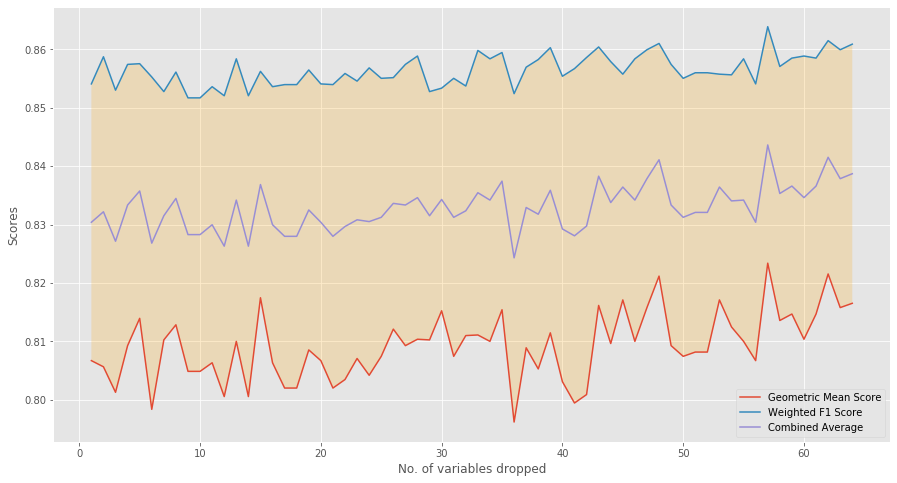

In [46]:
# plot the results

plt.figure(figsize=(15,8))

ax1 = sns.lineplot(x="no_variables_dropped", y="geometric_mean_score", data=score_array)
ax1 = sns.lineplot(x="no_variables_dropped", y="Weighted_F1_score", data=score_array)
ax2 = sns.lineplot(x="no_variables_dropped", y="mean", data=score_array,dashes="--")
ax1.set(xlabel='No. of variables dropped', ylabel='Scores')
plt.legend(labels=['Geometric Mean Score', 'Weighted F1 Score','Combined Average'])
plt.fill_between(score_array.no_variables_dropped, score_array.geometric_mean_score, score_array.Weighted_F1_score, alpha=0.2,facecolor='orange')

In [47]:
# extract details of the iteration that derived the best scores after pruning

score_array[score_array["mean"] == score_array["mean"].max()]

,no_variables_dropped,geometric_mean_score,Weighted_F1_score,mean
56,57,0.82339,0.86387,0.84363


In [48]:
# create a list to house all variables to be pruned

to_drop = feature_importance.sort_values(by = "var_impt", ascending=False)[-57:len(feature_importance)]

In [49]:
to_drop_list = to_drop.reset_index().iloc[:,1]

In [50]:
to_drop_list

0                               Oth_religion
1                              avg_hse_sales
2                    hsehold_usual_residents
3                       Skilled_trades_occup
4                     Males_ptTime_less15hrs
5                      tenure_owned_outright
6                         Professional_occup
7                                      Hindu
8                     1-family_cohab_depKids
9                    1-family_married_noKids
10                            toWork_bicycle
11                                  NS-SEC_7
12                                    Jewish
13                              born_restEUR
14                                   age_0_4
15                                  NS-SEC_1
16                     1-family_lone_depKids
17                                 eth_asian
18                                  NS-SEC_6
19                                   age_5_7
20                                   age_8_9
21                                    Muslim
22        

In [51]:
# create a new dataframe for hosting variables after pruning

df_01_data_dropped = df_01_data[:]

In [52]:
df_01_data_dropped = df_01_data_dropped.drop(columns=to_drop_list)

In [53]:
df_01_data_dropped.head()

,Pop_size,avg_pop_churn,age_18_19,age_20_24,age_25_29,age_45_59,age_65_74,age_75_84,age_85_89,age_90_over,...,Lv1_qual,Lv2_qual,Lv3_qual,Lv4_qual,Other_qual,toWork_home,toWork_underground_light_rail,toWork_train,toWork_carVan,toWork_passenger_carVan
0,0.854701,0.037677,-1.136842,-0.257426,0.486486,2.791919,1.187279,0.060,-0.205128,-0.357143,...,-1.298578,-1.216659,-0.189755,2.116496,-1.503894,0.619050,0.263259,-0.366414,-1.108180,-0.915629
1,-0.256410,0.056527,-1.684211,-0.660066,0.299228,2.604040,0.335689,0.236,0.051282,0.023810,...,-1.334238,-1.406791,1.511886,1.930379,-1.445315,1.981754,0.179981,-0.444810,-1.089724,-0.891658
2,0.316239,1.373138,0.284211,0.085809,0.652510,0.565657,0.890459,1.432,3.256410,-0.166667,...,-0.659970,-0.456627,-0.000490,1.081450,-0.612850,-0.301161,0.270512,-0.313932,-1.214237,-1.145030
3,-3.649573,0.695312,-0.389474,0.059406,0.227799,-0.248485,-0.070671,0.276,0.858974,0.380952,...,-0.137101,-0.754744,-0.386011,0.186940,-0.423848,0.010375,0.518704,-0.332282,-1.131680,-0.773892
4,0.606838,-0.222276,0.894737,0.075908,0.416988,0.355556,-0.568905,0.040,-0.269231,0.571429,...,0.743365,0.352778,-0.379778,-0.228444,0.380182,-0.951796,0.466272,0.357612,-0.176290,0.522624


In [54]:
# split the dataset into training and test set again

x_train_dropped, x_test_dropped, y_train, y_test = train_test_split(df_01_data_dropped, df_01_labels, test_size=0.3, stratify=df_01_labels, random_state=42)

In [55]:
# test the perfomance of this model containing pruned variables

scores = cross_val_score(brf2, x_train_dropped, y_train.values.ravel(), cv=5, scoring = 'f1_weighted')
print ("mean validation - F1 Weighted score:", "F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
brf2 = brf2.fit(x_train_dropped, y_train.values.ravel())
y_pred = brf2.predict(x_test_dropped)
f1 = f1_score(y_test, y_pred, average="weighted")
print ('Wighted F1 score on Test set:', f1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | el

mean validation - F1 Weighted score: F1 score: 0.85 (+/- 0.03)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 4 of 600
building tree 8 of 600building tree 7 of 600

building tree 3 of 600building tree 6 of 600building tree 2 of 600

building tree 1 of 600

building tree 5 of 600
building tree 9 of 600
building tree 10 of 600building tree 11 of 600

building tree 14 of 600building tree 12 of 600
building tree 13 of 600

building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 19 of 600
building tree 20 of 600
building tree 22 of 600
building tree 21 of 600
building tree 24 of 600building tree 23 of 600

building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 29 of 600building tree 28 of 600

building tree 32 of 600
building tree 31 of 600
building tree 30 of 600
building tree 33 of 600
building tree 35 of 600
building tree 34 of 600
building tree 37 of 600
building tree 36 of 600building tree 38 of 600

building tree 39 of 600
building tree 40 of 600
building tree 42 of 600building tree 41 of 600

building tree 43 of 600
building tree 44 of 600
building tree 45 of 600
building tree 46 of 600
building tree 47 of 600
building tree 50 of 600
building tree 48 of 600
building tree 49 of 600building tree 51 of 600

building tree 52 of 600building tree 53 of 600

building tree 54 of 600
building tree 55 of 600
building tree 56 of 600
building tree 58 of 600building tree 60 of 600

building tree 57 of 600
building tree 61

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s



building tree 162 of 600
building tree 161 of 600
building tree 163 of 600
building tree 165 of 600building tree 164 of 600

building tree 166 of 600
building tree 168 of 600
building tree 167 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600building tree 175 of 600building tree 176 of 600


building tree 177 of 600
building tree 179 of 600
building tree 180 of 600
building tree 178 of 600
building tree 181 of 600
building tree 184 of 600
building tree 182 of 600building tree 183 of 600

building tree 186 of 600
building tree 185 of 600
building tree 188 of 600
building tree 187 of 600
building tree 189 of 600
building tree 191 of 600
building tree 190 of 600
building tree 193 of 600
building tree 192 of 600
building tree 194 of 600
building tree 195 of 600
building tree 196 of 600
building tree 197 of 600
building tree 198 of 600
building tree 200 of 600
building tree 202 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.2s



building tree 294 of 600
building tree 295 of 600
building tree 297 of 600
building tree 296 of 600
building tree 299 of 600
building tree 298 of 600
building tree 302 of 600building tree 300 of 600building tree 303 of 600


building tree 301 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 309 of 600building tree 307 of 600

building tree 308 of 600
building tree 311 of 600building tree 312 of 600

building tree 310 of 600
building tree 313 of 600
building tree 315 of 600
building tree 314 of 600
building tree 316 of 600
building tree 317 of 600
building tree 319 of 600building tree 318 of 600

building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 327 of 600
building tree 326 of 600
building tree 328 of 600
building tree 329 of 600
building tree 330 of 600
building tree 332 of 600
building tree 331 of 600
building tree 333 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.1s



building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600building tree 538 of 600

building tree 540 of 600building tree 539 of 600

building tree 541 of 600
building tree 543 of 600
building tree 542 of 600
building tree 545 of 600
building tree 544 of 600
building tree 546 of 600building tree 548 of 600

building tree 547 of 600
building tree 550 of 600
building tree 549 of 600
building tree 551 of 600building tree 552 of 600

building tree 554 of 600
building tree 553 of 600
building tree 555 of 600
building tree 556 of 600
building tree 558 of 600building tree 557 of 600

building tree 559 of 600
building tree 561 of 600
building tree 560 of 600
building tree 562 of 600
building tree 563 of 600
building tree 566 of 600
building tree 564 of 600building tree 565 of 600

building tree 567 of 600
building tree 568 of 600
building tree 569 of 600
building tree 570 of 600
building tree 571 of 600
building tree 572 of 600
building tree 574 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s


Wighted F1 score on Test set: 0.8638699998366508


[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished


In [56]:
print('The geometric mean of Balanced RandomForest classifier on the test set is {}'.format(geometric_mean_score(y_test.values.ravel(),y_pred)))

The geometric mean of Balanced RandomForest classifier on the test set is 0.8233904740078662


In [57]:
unique_label = np.unique(y_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:GEN  pred:NON-GEN
true:GEN            82            18
true:NON-GEN       234          1117


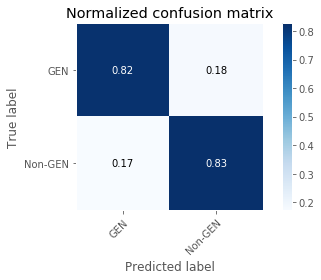

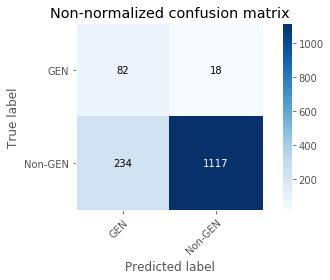

In [58]:
# plot a confusion matrix using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=["GEN","Non-GEN"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=["GEN","Non-GEN"], normalize=False,
                      title='Non-normalized confusion matrix')

In [59]:
# run model on the entire dataset

In [60]:
# model's performance on the entire dataset

y_pred_2001_all = brf2.predict(df_01_data_dropped)
f1 = f1_score(df_01_labels, y_pred_2001_all, average="weighted")
print ('Wighted F1 score on Test set:', f1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s


Wighted F1 score on Test set: 0.8733297490806677


[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.3s finished


In [61]:
print('The geometric mean of Balanced RandomForest classifier on the test set is {}'.format(geometric_mean_score(df_01_labels.values.ravel(),y_pred_2001_all)))

The geometric mean of Balanced RandomForest classifier on the test set is 0.8860558647869127


In [62]:
unique_label = np.unique(df_01_labels)
print(pd.DataFrame(confusion_matrix(df_01_labels, y_pred_2001_all, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:GEN  pred:NON-GEN
true:GEN           316            18
true:NON-GEN       766          3735


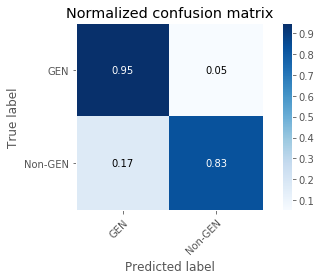

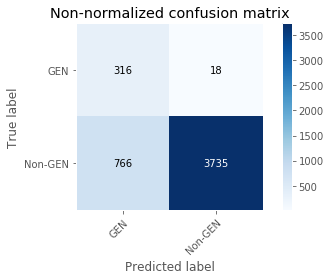

In [63]:
# plot a confusion matrix using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_2001_all, classes=["GEN","Non-GEN"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_2001_all, classes=["GEN","Non-GEN"], normalize=False,
                      title='Non-normalized confusion matrix')

In [64]:
# read in original file and append the predictions

df_pred_all = pd.read_csv("df_modelling_std_01_labels.csv").drop(columns=["Unnamed: 0"])

In [65]:
df_pred_all["predictions"] = y_pred_2001_all

In [66]:
df_pred_all.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_7,age_8_9,age_10_14,age_15,age_16_17,age_18_19,...,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,Class_2_status,Class_3_status,GEN_Class2,GEN_Class3,predictions
0,E01000001,0.854701,0.037677,-1.731343,-1.986667,-1.702703,-1.606870,-1.454545,-1.309735,-1.136842,...,-0.915629,3.578703,-0.142289,8.831109,-0.068483,STB,STB,NON-GEN,NON-GEN,NON-GEN
1,E01000002,-0.256410,0.056527,-1.377399,-1.713333,-1.099099,-1.438931,-1.439394,-1.725664,-1.684211,...,-0.891658,3.246082,-0.020480,7.867334,2.147109,STB,STB,NON-GEN,NON-GEN,GEN
2,E01000003,0.316239,1.373138,-1.053305,-1.226667,-1.090090,-1.923664,-1.242424,-0.646018,0.284211,...,-1.145030,1.368383,0.296554,9.162056,0.126062,STB,STB,NON-GEN,NON-GEN,NON-GEN
3,E01000005,-3.649573,0.695312,0.289979,0.000000,0.342342,0.248092,0.515152,0.221239,-0.389474,...,-0.773892,0.463543,-0.016153,6.427513,0.594204,STB,STB,NON-GEN,NON-GEN,NON-GEN
4,E01000006,0.606838,-0.222276,0.349680,-0.533333,0.261261,0.034351,0.469697,0.168142,0.894737,...,0.522624,0.580377,-0.270168,0.478177,-0.009858,IUP,IUP,NON-GEN,NON-GEN,NON-GEN


In [67]:
# categorising the predictions:
# 0 means accurate predictions
# 1 means predicted value is GEN, but the real category is Non-GEN (False positives)
# 2 means predicted value is NON-GEN, but the real category is GEN (False negatives)

df_pred_all["pred_cat"] = 0

for i in range(len(df_pred_all)):
    if df_pred_all.loc[i,"GEN_Class2"] == "NON-GEN" and df_pred_all.loc[i,"predictions"] == "GEN":
        df_pred_all.loc[i, "pred_cat"] = 1
    elif df_pred_all.loc[i,"GEN_Class2"] == "GEN" and df_pred_all.loc[i,"predictions"] == "NON-GEN":
        df_pred_all.loc[i, "pred_cat"] = 2

In [68]:
df_pred_all.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_7,age_8_9,age_10_14,age_15,age_16_17,age_18_19,...,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,Class_2_status,Class_3_status,GEN_Class2,GEN_Class3,predictions,pred_cat
0,E01000001,0.854701,0.037677,-1.731343,-1.986667,-1.702703,-1.606870,-1.454545,-1.309735,-1.136842,...,3.578703,-0.142289,8.831109,-0.068483,STB,STB,NON-GEN,NON-GEN,NON-GEN,0
1,E01000002,-0.256410,0.056527,-1.377399,-1.713333,-1.099099,-1.438931,-1.439394,-1.725664,-1.684211,...,3.246082,-0.020480,7.867334,2.147109,STB,STB,NON-GEN,NON-GEN,GEN,1
2,E01000003,0.316239,1.373138,-1.053305,-1.226667,-1.090090,-1.923664,-1.242424,-0.646018,0.284211,...,1.368383,0.296554,9.162056,0.126062,STB,STB,NON-GEN,NON-GEN,NON-GEN,0
3,E01000005,-3.649573,0.695312,0.289979,0.000000,0.342342,0.248092,0.515152,0.221239,-0.389474,...,0.463543,-0.016153,6.427513,0.594204,STB,STB,NON-GEN,NON-GEN,NON-GEN,0
4,E01000006,0.606838,-0.222276,0.349680,-0.533333,0.261261,0.034351,0.469697,0.168142,0.894737,...,0.580377,-0.270168,0.478177,-0.009858,IUP,IUP,NON-GEN,NON-GEN,NON-GEN,0


In [69]:
# checkpoint - output file
# df_pred_all.to_csv("df_pred_all.csv")

## Adding Geographic Covariate 1 - Proximity to London's inner boroughs and Richmond upon Thames

In [70]:
# read in dataset consisting the proximal distances between each LSOA and the boundaries of inner boroughs and Richmond upon Thames

proximity_innerBor_Richmond = pd.read_csv("proximity_innerBoroughs_Richmond.csv")

In [71]:
proximity_innerBor_Richmond.head()

,LSOA11CD,LSOA11NM,LAD11CD,LAD11NM,Proximity_to_innerBoroughs_Richmond
0,E01000001,City of London 001A,E09000001,City of London,0.000000
1,E01000002,City of London 001B,E09000001,City of London,0.000000
2,E01000003,City of London 001C,E09000001,City of London,0.000000
3,E01000005,City of London 001E,E09000001,City of London,0.000000
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,1059.179475


In [72]:
# read in original dataset

df_01_lsoa = pd.read_csv("df_modelling_std_01_labels.csv").drop(columns=["Unnamed: 0"])

In [73]:
# remove non-essential variables at this stage

df_01_lsoa = df_01_lsoa.drop(columns=["Class_2_status","Class_3_status","GEN_Class2","GEN_Class3"])

In [74]:
# attach the 1st geog covariate to the original dataset

df_01_geogco = df_01_lsoa.merge(proximity_innerBor_Richmond[["Proximity_to_innerBoroughs_Richmond","LSOA11CD"]], left_on="LSOA11CD", right_on="LSOA11CD")

In [75]:
# create a new dataset which geog covariate 2 can be appended onto later

df_01_geogco2 = df_01_geogco[:]

In [76]:
# prepping the dataset with geog covariate 1 to be modelled and tested

df_01_geogco = df_01_geogco.drop(columns = "LSOA11CD")

In [77]:
df_01_geogco = df_01_geogco.drop(columns=to_drop_list)

In [78]:
df_01_geogco.head()

,Pop_size,avg_pop_churn,age_18_19,age_20_24,age_25_29,age_45_59,age_65_74,age_75_84,age_85_89,age_90_over,...,Lv2_qual,Lv3_qual,Lv4_qual,Other_qual,toWork_home,toWork_underground_light_rail,toWork_train,toWork_carVan,toWork_passenger_carVan,Proximity_to_innerBoroughs_Richmond
0,0.854701,0.037677,-1.136842,-0.257426,0.486486,2.791919,1.187279,0.060,-0.205128,-0.357143,...,-1.216659,-0.189755,2.116496,-1.503894,0.619050,0.263259,-0.366414,-1.108180,-0.915629,0.000000
1,-0.256410,0.056527,-1.684211,-0.660066,0.299228,2.604040,0.335689,0.236,0.051282,0.023810,...,-1.406791,1.511886,1.930379,-1.445315,1.981754,0.179981,-0.444810,-1.089724,-0.891658,0.000000
2,0.316239,1.373138,0.284211,0.085809,0.652510,0.565657,0.890459,1.432,3.256410,-0.166667,...,-0.456627,-0.000490,1.081450,-0.612850,-0.301161,0.270512,-0.313932,-1.214237,-1.145030,0.000000
3,-3.649573,0.695312,-0.389474,0.059406,0.227799,-0.248485,-0.070671,0.276,0.858974,0.380952,...,-0.754744,-0.386011,0.186940,-0.423848,0.010375,0.518704,-0.332282,-1.131680,-0.773892,0.000000
4,0.606838,-0.222276,0.894737,0.075908,0.416988,0.355556,-0.568905,0.040,-0.269231,0.571429,...,0.352778,-0.379778,-0.228444,0.380182,-0.951796,0.466272,0.357612,-0.176290,0.522624,1059.179475


In [79]:
# test the performance of this model with geog covariate 1

scores = cross_val_score(brf2, df_01_geogco, df_01_labels.values.ravel(), cv=5, scoring = 'f1_weighted')
print ("mean validation - F1 Weighted score:", "F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
brf2 = brf2.fit(df_01_geogco, df_01_labels.values.ravel())
y_pred_geogco = brf2.predict(df_01_geogco)
f1 = f1_score(df_01_labels, y_pred_geogco, average="weighted")
print ('Wighted F1 score on Test set:', f1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | ela

mean validation - F1 Weighted score: F1 score: 0.84 (+/- 0.07)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 600
building tree 5 of 600
building tree 8 of 600building tree 7 of 600
building tree 2 of 600building tree 6 of 600

building tree 4 of 600
building tree 3 of 600

building tree 9 of 600
building tree 10 of 600
building tree 12 of 600
building tree 11 of 600building tree 16 of 600

building tree 13 of 600
building tree 14 of 600building tree 15 of 600

building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600
building tree 20 of 600building tree 25 of 600

building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 26 of 600
building tree 27 of 600
building tree 30 of 600
building tree 28 of 600
building tree 29 of 600
building tree 33 of 600
building tree 31 of 600building tree 32 of 600

building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 38 of 600building tree 37 of 600

building tree 39 of 600
building tree 41 of 600
building tree 40 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



building tree 53 of 600
building tree 54 of 600
building tree 56 of 600
building tree 55 of 600
building tree 57 of 600
building tree 58 of 600
building tree 60 of 600building tree 59 of 600

building tree 62 of 600
building tree 61 of 600
building tree 63 of 600
building tree 65 of 600building tree 66 of 600

building tree 64 of 600
building tree 67 of 600
building tree 68 of 600
building tree 69 of 600
building tree 72 of 600
building tree 70 of 600
building tree 71 of 600
building tree 73 of 600
building tree 74 of 600
building tree 75 of 600
building tree 77 of 600building tree 76 of 600

building tree 78 of 600
building tree 80 of 600
building tree 79 of 600
building tree 81 of 600
building tree 82 of 600
building tree 83 of 600
building tree 84 of 600
building tree 86 of 600
building tree 85 of 600
building tree 88 of 600
building tree 87 of 600
building tree 89 of 600
building tree 91 of 600
building tree 90 of 600
building tree 93 of 600
building tree 92 of 600
building tree 9

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.7s



building tree 146 of 600building tree 147 of 600

building tree 148 of 600
building tree 149 of 600
building tree 151 of 600
building tree 150 of 600building tree 152 of 600

building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 159 of 600
building tree 158 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 170 of 600building tree 169 of 600

building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 179 of 600
building tree 178 of 600
building tree 181 of 600
building tree 180 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 186 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.6s


building tree 278 of 600
building tree 279 of 600
building tree 280 of 600
building tree 282 of 600
building tree 281 of 600
building tree 284 of 600building tree 283 of 600

building tree 285 of 600
building tree 286 of 600
building tree 287 of 600
building tree 288 of 600
building tree 289 of 600
building tree 291 of 600
building tree 290 of 600
building tree 294 of 600
building tree 293 of 600
building tree 292 of 600
building tree 295 of 600
building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 299 of 600
building tree 300 of 600
building tree 302 of 600building tree 301 of 600

building tree 303 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 307 of 600
building tree 308 of 600
building tree 310 of 600
building tree 309 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 317 of 600building tree 318 of 600

building tree 316 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.9s



building tree 507 of 600
building tree 508 of 600
building tree 510 of 600
building tree 509 of 600building tree 511 of 600

building tree 512 of 600building tree 514 of 600
building tree 513 of 600

building tree 517 of 600
building tree 516 of 600
building tree 515 of 600
building tree 518 of 600
building tree 519 of 600building tree 520 of 600

building tree 521 of 600
building tree 522 of 600
building tree 523 of 600
building tree 525 of 600
building tree 524 of 600
building tree 526 of 600
building tree 528 of 600
building tree 530 of 600
building tree 529 of 600building tree 527 of 600

building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 537 of 600
building tree 536 of 600building tree 539 of 600

building tree 540 of 600building tree 538 of 600

building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600
building tree 546 of 600

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s


Wighted F1 score on Test set: 0.8820672754523605


[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.3s finished


In [80]:
print('The geometric mean of Balanced RandomForest classifier on the test set is {}'.format(geometric_mean_score(df_01_labels.values.ravel(),y_pred_geogco)))

The geometric mean of Balanced RandomForest classifier on the test set is 0.9155643968898393


In [81]:
unique_label = np.unique(df_01_labels)
print(pd.DataFrame(confusion_matrix(df_01_labels, y_pred_geogco, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:GEN  pred:NON-GEN
true:GEN           334             0
true:NON-GEN       728          3773


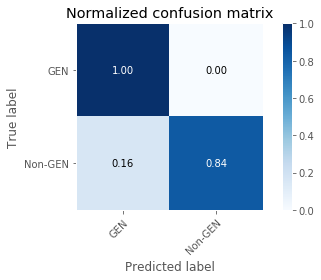

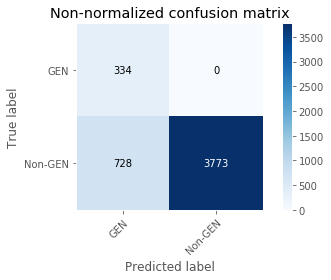

In [82]:
# plot a confusion matrix using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_geogco, classes=["GEN","Non-GEN"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_geogco, classes=["GEN","Non-GEN"], normalize=False,
                      title='Non-normalized confusion matrix')

## Adding Geographic Covariate 2 - Summed PC1 scores across all neighbourhing LSOAs under a queen's contiguity matrix

In [83]:
# read in relevant dataset

neighbour_pca_scores = pd.read_csv("df_neighbours_pca_01_modelling.csv").drop(columns="Unnamed: 0")

In [84]:
neighbour_pca_scores.head()

,LSOA11CD,PCA_score_nbr
0,E01000001,10.765543
1,E01000002,7.136679
2,E01000003,11.481816
3,E01000005,10.364784
4,E01000006,-6.934789


In [85]:
df_01_geogco2.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_7,age_8_9,age_10_14,age_15,age_16_17,age_18_19,...,toWork_train,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other,Proximity_to_innerBoroughs_Richmond
0,E01000001,0.854701,0.037677,-1.731343,-1.986667,-1.702703,-1.606870,-1.454545,-1.309735,-1.136842,...,-0.366414,-0.893246,-0.378079,-1.108180,-0.915629,3.578703,-0.142289,8.831109,-0.068483,0.000000
1,E01000002,-0.256410,0.056527,-1.377399,-1.713333,-1.099099,-1.438931,-1.439394,-1.725664,-1.684211,...,-0.444810,-0.660327,-0.838531,-1.089724,-0.891658,3.246082,-0.020480,7.867334,2.147109,0.000000
2,E01000003,0.316239,1.373138,-1.053305,-1.226667,-1.090090,-1.923664,-1.242424,-0.646018,0.284211,...,-0.313932,-0.515927,-0.203144,-1.214237,-1.145030,1.368383,0.296554,9.162056,0.126062,0.000000
3,E01000005,-3.649573,0.695312,0.289979,0.000000,0.342342,0.248092,0.515152,0.221239,-0.389474,...,-0.332282,0.159427,-1.406440,-1.131680,-0.773892,0.463543,-0.016153,6.427513,0.594204,0.000000
4,E01000006,0.606838,-0.222276,0.349680,-0.533333,0.261261,0.034351,0.469697,0.168142,0.894737,...,0.357612,-0.187429,-0.359832,-0.176290,0.522624,0.580377,-0.270168,0.478177,-0.009858,1059.179475


In [86]:
# merge the original dataset with geog covariate 2

df_01_geogco2 = df_01_geogco2.merge(neighbour_pca_scores[["LSOA11CD","PCA_score_nbr"]], left_on="LSOA11CD", right_on="LSOA11CD")

In [87]:
df_01_geogco2 = df_01_geogco2.drop(columns = "LSOA11CD")

In [88]:
df_01_geogco2 = df_01_geogco2.drop(columns=to_drop_list)

In [89]:
df_01_geogco2.head()

,Pop_size,avg_pop_churn,age_18_19,age_20_24,age_25_29,age_45_59,age_65_74,age_75_84,age_85_89,age_90_over,...,Lv3_qual,Lv4_qual,Other_qual,toWork_home,toWork_underground_light_rail,toWork_train,toWork_carVan,toWork_passenger_carVan,Proximity_to_innerBoroughs_Richmond,PCA_score_nbr
0,0.854701,0.037677,-1.136842,-0.257426,0.486486,2.791919,1.187279,0.060,-0.205128,-0.357143,...,-0.189755,2.116496,-1.503894,0.619050,0.263259,-0.366414,-1.108180,-0.915629,0.000000,10.765543
1,-0.256410,0.056527,-1.684211,-0.660066,0.299228,2.604040,0.335689,0.236,0.051282,0.023810,...,1.511886,1.930379,-1.445315,1.981754,0.179981,-0.444810,-1.089724,-0.891658,0.000000,7.136679
2,0.316239,1.373138,0.284211,0.085809,0.652510,0.565657,0.890459,1.432,3.256410,-0.166667,...,-0.000490,1.081450,-0.612850,-0.301161,0.270512,-0.313932,-1.214237,-1.145030,0.000000,11.481816
3,-3.649573,0.695312,-0.389474,0.059406,0.227799,-0.248485,-0.070671,0.276,0.858974,0.380952,...,-0.386011,0.186940,-0.423848,0.010375,0.518704,-0.332282,-1.131680,-0.773892,0.000000,10.364784
4,0.606838,-0.222276,0.894737,0.075908,0.416988,0.355556,-0.568905,0.040,-0.269231,0.571429,...,-0.379778,-0.228444,0.380182,-0.951796,0.466272,0.357612,-0.176290,0.522624,1059.179475,-6.934789


In [90]:
# test the performance of the model with both geog covariates

scores = cross_val_score(brf2, df_01_geogco2, df_01_labels.values.ravel(), cv=5, scoring = 'f1_weighted')
print ("mean validation - F1 Weighted score:", "F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
brf2 = brf2.fit(df_01_geogco2, df_01_labels.values.ravel())
y_pred_geogco2 = brf2.predict(df_01_geogco2)
f1 = f1_score(df_01_labels, y_pred_geogco2, average="weighted")
print ('Wighted F1 score on Test set:', f1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | ela

mean validation - F1 Weighted score: F1 score: 0.84 (+/- 0.06)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 3 of 600
building tree 4 of 600building tree 1 of 600
building tree 6 of 600building tree 8 of 600

building tree 2 of 600

building tree 5 of 600building tree 7 of 600

building tree 10 of 600
building tree 9 of 600
building tree 12 of 600building tree 11 of 600

building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 21 of 600
building tree 18 of 600
building tree 20 of 600
building tree 22 of 600
building tree 19 of 600
building tree 24 of 600
building tree 23 of 600
building tree 25 of 600
building tree 26 of 600
building tree 28 of 600building tree 27 of 600

building tree 30 of 600
building tree 29 of 600
building tree 32 of 600
building tree 31 of 600
building tree 33 of 600
building tree 34 of 600
building tree 36 of 600
building tree 35 of 600
building tree 40 of 600
building tree 38 of 600building tree 37 of 600

building tree 39 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.7s


building tree 124 of 600

building tree 123 of 600
building tree 125 of 600
building tree 126 of 600building tree 127 of 600

building tree 128 of 600
building tree 129 of 600
building tree 130 of 600
building tree 131 of 600
building tree 132 of 600
building tree 133 of 600
building tree 134 of 600
building tree 135 of 600
building tree 136 of 600
building tree 138 of 600
building tree 137 of 600
building tree 139 of 600
building tree 140 of 600
building tree 142 of 600building tree 143 of 600

building tree 141 of 600
building tree 144 of 600
building tree 146 of 600
building tree 145 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 153 of 600
building tree 152 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 159 of 600
building tree 157 of 600
building tree 158 of 600
building tree 161 of 600
building tree 160 of 600
building tree 162 of 600

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.6s



building tree 297 of 600
building tree 298 of 600
building tree 300 of 600building tree 299 of 600

building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 314 of 600
building tree 312 of 600building tree 313 of 600

building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 319 of 600building tree 318 of 600

building tree 320 of 600building tree 321 of 600

building tree 322 of 600
building tree 323 of 600
building tree 325 of 600building tree 324 of 600

building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 331 of 600
building tree 330 of 600
building tree 332 of 600building tree 333 of 600

building tree 334 of 600
building tree 335 of 600
building tree 336 of 600

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.8s


building tree 507 of 600building tree 506 of 600

building tree 508 of 600
building tree 509 of 600
building tree 510 of 600
building tree 511 of 600building tree 512 of 600

building tree 514 of 600
building tree 513 of 600
building tree 515 of 600
building tree 516 of 600
building tree 517 of 600
building tree 519 of 600
building tree 518 of 600
building tree 520 of 600
building tree 521 of 600
building tree 522 of 600
building tree 523 of 600
building tree 524 of 600
building tree 525 of 600
building tree 527 of 600
building tree 526 of 600building tree 529 of 600building tree 528 of 600


building tree 530 of 600
building tree 531 of 600
building tree 532 of 600
building tree 534 of 600building tree 533 of 600

building tree 536 of 600
building tree 535 of 600building tree 537 of 600

building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600building tree 543 of 600

building tree 545 of 600building tree 546 of 600bu

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s


Wighted F1 score on Test set: 0.8832361380837098


[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished


In [91]:
print('The geometric mean of Balanced RandomForest classifier on the test set is {}'.format(geometric_mean_score(df_01_labels.values.ravel(),y_pred_geogco2)))

The geometric mean of Balanced RandomForest classifier on the test set is 0.9165345316222824


In [92]:
unique_label = np.unique(df_01_labels)
print(pd.DataFrame(confusion_matrix(df_01_labels, y_pred_geogco2, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

              pred:GEN  pred:NON-GEN
true:GEN           334             0
true:NON-GEN       720          3781


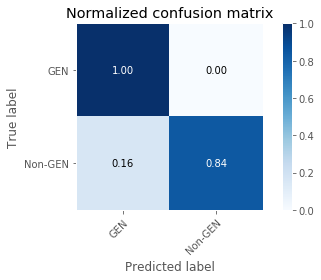

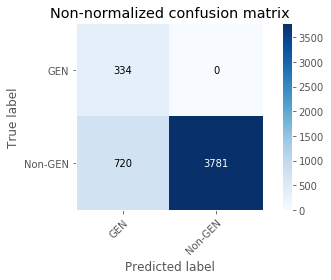

In [93]:
# plot a confusion matrix using both normalised and non-normalised values
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(None)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_geogco2, classes=["GEN","Non-GEN"], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(df_01_labels, y_pred_geogco2, classes=["GEN","Non-GEN"], normalize=False,
                      title='Non-normalized confusion matrix')

## Predict Future Trends with 2011-2016 Data

In [94]:
# read in relevant dataset

df_11 = pd.read_csv("df_modelling_std_11.csv")

In [95]:
df_11.head()

,LSOA11CD,Pop_size,avg_pop_churn,age_0_4,age_5_7,age_8_9,age_10_14,age_15,age_16_17,age_18_19,...,toWork_underground_light_rail,toWork_train,toWork_bus,toWork_motorcycle,toWork_carVan,toWork_passenger_carVan,toWork_taxi,toWork_bicycle,toWork_walk,toWork_other
0,E01000001,-0.658537,0.517292,-1.383142,-1.615385,-1.265306,-1.564,-1.107692,-1.504132,-1.732673,...,0.170795,-0.306083,-0.835334,-0.546198,-0.859595,-0.631409,1.793259,0.805561,11.685667,1.749058
1,E01000002,-0.759582,0.617433,-1.088123,-0.916084,-1.316327,-1.436,-0.984615,-1.264463,-1.445545,...,0.227091,-0.233313,-0.974646,-0.233249,-0.871737,-0.858955,2.703046,1.137534,10.966777,2.137273
2,E01000003,-1.073171,-0.214230,-1.180077,-1.797203,-1.642857,-1.560,-1.169231,0.123967,0.366337,...,0.091431,-0.240467,-0.275673,-0.482598,-0.834654,-0.852303,-0.105336,1.677591,9.131364,2.061122
3,E01000005,-2.331010,0.483485,-1.057471,0.174825,0.030612,-0.284,0.292308,-0.388430,-0.425743,...,0.113814,-0.031168,0.294310,-0.902586,-0.798896,-0.695636,-0.283444,0.940659,5.935153,-0.633620
4,E01000006,0.170732,-0.044254,0.773946,0.594406,0.510204,0.076,-0.107692,-0.247934,-0.336634,...,0.575088,0.317257,-0.549085,-0.991452,0.062273,-0.191442,-0.179201,-0.358449,0.177392,-0.514019


In [96]:
neighbour_pca_scores_11 = pd.read_csv("df_neighbours_pca_11_modelling.csv").drop(columns="Unnamed: 0")

In [97]:
neighbour_pca_scores_11.head()

,LSOA11CD,PCA_scores_11_nbr
0,E01000001,11.841484
1,E01000002,8.827107
2,E01000003,12.152155
3,E01000005,7.999082
4,E01000006,-5.566358


In [98]:
# merge geog covariate 1

df_11_merge = df_11.merge(proximity_innerBor_Richmond[["LSOA11CD","Proximity_to_innerBoroughs_Richmond"]], left_on="LSOA11CD",right_on="LSOA11CD",how="left")

In [99]:
# merge geog covariate 2

df_11_merge = df_11_merge.merge(neighbour_pca_scores_11[["LSOA11CD","PCA_scores_11_nbr"]], left_on="LSOA11CD",right_on="LSOA11CD",how="left")

In [100]:
# removed pruned variables

df_11_merge = df_11_merge.drop(columns=to_drop_list)

In [101]:
df_11_merge = df_11_merge.drop(columns="LSOA11CD")

In [102]:
df_11_merge.head()

,Pop_size,avg_pop_churn,age_18_19,age_20_24,age_25_29,age_45_59,age_65_74,age_75_84,age_85_89,age_90_over,...,Lv3_qual,Lv4_qual,Other_qual,toWork_home,toWork_underground_light_rail,toWork_train,toWork_carVan,toWork_passenger_carVan,Proximity_to_innerBoroughs_Richmond,PCA_scores_11_nbr
0,-0.658537,0.517292,-1.732673,-0.899489,0.066547,1.642058,1.322091,1.489451,0.573171,0.195652,...,-1.291667,1.986175,-0.741379,2.023367,0.170795,-0.306083,-0.859595,-0.631409,0.000000,11.841484
1,-0.759582,0.617433,-1.445545,-1.413969,-0.500000,1.814318,2.161889,0.405063,0.512195,1.413043,...,-1.291667,2.059908,-1.189655,2.212408,0.227091,-0.233313,-0.871737,-0.858955,0.000000,8.827107
2,-1.073171,-0.214230,0.366337,-0.415673,0.271583,0.545861,0.978078,1.687764,1.439024,1.086957,...,-1.083333,1.027650,-0.620690,0.496353,0.091431,-0.240467,-0.834654,-0.852303,0.000000,12.152155
3,-2.331010,0.483485,-0.425743,0.991482,0.575540,0.360179,0.826307,0.109705,-0.268293,0.260870,...,-0.250000,0.000000,0.362069,-0.360463,0.113814,-0.031168,-0.798896,-0.695636,0.000000,7.999082
4,0.170732,-0.044254,-0.336634,0.214651,0.627698,-0.648770,-0.394604,-0.413502,-0.365854,-0.086957,...,-0.541667,-0.073733,0.775862,-0.247468,0.575088,0.317257,0.062273,-0.191442,1059.179475,-5.566358


In [103]:
# predict labels

y_pred_2011 = brf2.predict(df_11_merge)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished


In [104]:
# append the predictions with the original dataset

df_11['predictions'] = y_pred_2011

In [105]:
# check the breakdown

df_11.groupby('predictions').size()

predictions
GEN         883
NON-GEN    3952
dtype: int64

In [106]:
# checkpoint - output file
# df_11.to_csv("predictions_modelling1.csv")